In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import stft, get_window, butter, filtfilt


###FFT (Fast Fourier Transform)


 La FFT est utile pour obtenir une vue globale des composantes fréquentielles présentes dans le signal GPR sur toute sa durée. Elle peut aider à identifier les fréquences dominantes et les caractéristiques spectrales générales du signal.

In [255]:


def load_gpr_data(file_path):
    """Charger les données GPR à partir d'un fichier CSV."""
    data = pd.read_csv(file_path)
    return data

def apply_antialiasing_filter(signal, fs, cutoff_freq):
    """Cette fonction applique un filtre passe-bas anti-aliasing pour éviter les artefacts de repliement (aliasing) dans le signal.."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    if normal_cutoff >= 1.0:
        raise ValueError("La fréquence de coupure doit être inférieure à la fréquence de Nyquist.")
    b, a = butter(5, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def appliquer_fft_positives_m1(data, sampling_rate=None, anti_aliasing=False, windowing=None):
    """Appliquer la FFT sur chaque point de mesure dans les données GPR (Méthode 1) avec options."""
    fft_results = {}
    
    # Fréquence d'échantillonnage calculée à partir des données
    fs_default = 1 / (data['Unnamed: 0'][1] - data['Unnamed: 0'][0])
    
    # Utiliser la fréquence d'échantillonnage fournie par l'utilisateur ou la valeur par défaut
    fs = sampling_rate if sampling_rate else fs_default
    
    if fs <= 0:
        raise ValueError("La fréquence d'échantillonnage doit être positive.")
    
    # Fréquence de coupure pour le filtre anti-aliasing
    cutoff_freq = fs / 2 * 0.9  # Utiliser 90% de la fréquence de Nyquist pour éviter les problèmes
    
    # Appliquer la FFT pour chaque colonne de point de mesure
    for column in data.columns[1:]:  # Ignorer la première colonne qui est le temps
        signal = data[column].values
        N = len(signal)  # Taille de la FFT (nombre de points dans le signal)
        
        # Option : Appliquer un filtre anti-aliasing
        if anti_aliasing:
            signal = apply_antialiasing_filter(signal, fs, cutoff_freq)
        
        # Option : Appliquer une fenêtre
        #Le fenêtrage aide à réduire les effets de bord et à améliorer la résolution fréquentielle.

        if windowing:
            window = get_window(windowing, N)
            signal = signal * window
        
        # Appliquer la FFT
        fft_result = np.fft.fft(signal)
        
        # Prendre uniquement les fréquences positives
        fft_positive = fft_result[:N//2]  # Première moitié des résultats de la FFT
        freqs = np.fft.fftfreq(N, d=1/fs)[:N//2]  # Fréquences correspondantes jusqu'à fs/2
        
        # Stocker les résultats
        fft_results[column] = (freqs, np.abs(fft_positive))  # Stocker les fréquences et amplitudes positives
    
    # Convertir les résultats en DataFrame
    fft_df = pd.DataFrame({
        'Frequence': freqs,
        **{col: amp for col, (_, amp) in fft_results.items()}
    })
    
    return fft_df

def enregistrer_fft_csv(fft_df, output_file):
    """Enregistrer les résultats de la FFT dans un fichier CSV."""
    fft_df.to_csv(output_file, index=False)

def plot_all_fft(fft_df):
    """Tracer les résultats de la FFT pour tous les points de mesure."""
    plt.figure(figsize=(14, 7))
    for column in fft_df.columns[1:]:
        plt.plot(fft_df['Frequence'], fft_df[column], label=column)
    
    plt.title('FFT du signal GPR pour tous les points de mesure')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.show()

def get_user_options():
    """Obtenir les options de l'utilisateur pour la FFT."""
    sampling_rate = input("Entrez la fréquence d'échantillonnage (ou laissez vide pour utiliser la valeur par défaut) : ")
    sampling_rate = float(sampling_rate) if sampling_rate else None

    anti_aliasing = input("Voulez-vous appliquer un filtre anti-aliasing ? (oui/non) : ").strip().lower()
    anti_aliasing = True if anti_aliasing == 'oui' else False

    windowing = input("Entrez le type de fenêtre à appliquer (hamming, hann, blackman, ou laissez vide pour ne pas utiliser de fenêtre) : ").strip().lower()
    windowing = windowing if windowing else None

    return sampling_rate, anti_aliasing, windowing


In [136]:

def detecter_top_frequences(fft_df, top_n=5):
    top_freqs_df = pd.DataFrame()
    
    for col in fft_df.columns[1:]:
        # Trier les amplitudes en ordre décroissant et prendre les indices correspondants
        sorted_indices = np.argsort(fft_df[col])[::-1]
        
        # Prendre les top_n fréquences dominantes
        top_frequencies = fft_df['Frequence'].iloc[sorted_indices].head(top_n).to_numpy()
        top_amplitudes = fft_df[col].iloc[sorted_indices].head(top_n).to_numpy()
        
        # Ajouter les fréquences et amplitudes dominantes au DataFrame
        top_freqs_df[f"{col}_Top_{top_n}_Freqs"] = top_frequencies
        top_freqs_df[f"{col}_Top_{top_n}_Amplitudes"] = top_amplitudes
    
    return top_freqs_df

def tracer_top_frequences(top_frequencies_df, top_n=5):
    num_points = top_frequencies_df.shape[1] // 2
    num_cols = 3
    num_rows = (num_points + num_cols - 1) // num_cols  # Pour arrondir vers le haut
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    
    for i in range(0, top_frequencies_df.shape[1], 2):
        point = i // 2 + 1
        freqs = top_frequencies_df.iloc[:, i]
        amplitudes = top_frequencies_df.iloc[:, i + 1]
        
        ax = axes[point - 1]
        ax.scatter(freqs, amplitudes, label=f'Point {point}', s=100)
        ax.set_title(f'Point {point}')
        ax.set_xlabel('Fréquence (Hz)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
    
    # Supprimer les axes non utilisés
    for j in range(point, len(axes)):
        fig.delaxes(axes[j])
    
    fig.tight_layout()
    plt.show()

def visualiser_matrice_fft_par_pointZOOM(fft_df, max_freq=20):
    # Vérifier que le DataFrame n'est pas None
    if fft_df is None:
        print("Erreur : Le DataFrame fft_df est None.")
        return
    
    try:
        # Visualisation de chaque point de mesure
        freqs = fft_df['Frequence']
        mask = freqs <= max_freq  # Limiter les fréquences affichées à max_freq Hz
        
        for col in fft_df.columns[1:]:
            plt.figure(figsize=(12, 8))
            plt.plot(freqs[mask], fft_df[col][mask])
            plt.title(f'Amplitude des fréquences pour {col}')
            plt.xlabel('Fréquence (Hz)')
            plt.ylabel('Amplitude')
            plt.grid(True)
            plt.tight_layout()
            plt.xlim(0, max_freq)  # Limiter l'axe x à 0-100 Hz
            plt.show()
    except Exception as e:
        print(f"Erreur lors de la visualisation de la matrice FFT : {e}")

def visualiser_matrice_fft_par_point(fft_df):
    # Vérifier que le DataFrame n'est pas None
    if fft_df is None:
        print("Erreur : Le DataFrame fft_df est None.")
        return
    
    try:
        # Visualisation de chaque point de mesure
        freqs = fft_df['Frequence']
        for col in fft_df.columns[1:]:
            plt.figure(figsize=(12, 8))
            plt.plot(freqs, fft_df[col])
            plt.title(f'Amplitude des fréquences pour {col}')
            plt.xlabel('Fréquence (Hz)')
            plt.ylabel('Amplitude')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Erreur lors de la visualisation de la matrice FFT : {e}")

def tracer_top_frequences_bars(top_frequencies_df, top_n=5):
    num_points = top_frequencies_df.shape[1] // 2
    fig, ax = plt.subplots(figsize=(15, 8))
    
    for i in range(0, top_frequencies_df.shape[1], 2):
        point = i // 2 + 1
        freqs = top_frequencies_df.iloc[:, i]
        amplitudes = top_frequencies_df.iloc[:, i + 1]
        
        for j in range(top_n):
            ax.bar(point + j * 0.1, freqs[j], width=0.1, label=f'Freq {j+1}' if point == 1 else "")
    
    ax.set_title('Top 5 Fréquences Dominantes pour chaque Point')
    ax.set_xlabel('Point de Mesure')
    ax.set_ylabel('Fréquence (Hz)')
    ax.grid(True)
    ax.legend()
    
    plt.show()



##STFT (Short-Time Fourier Transform)


 La STFT est particulièrement utile pour analyser comment les composantes fréquentielles du signal GPR évoluent au fil du temps. Elle est bien adaptée pour des signaux non stationnaires, ce qui est souvent le cas avec les données GPR

In [263]:
def appliquer_stft_interactive(data, fs, windowing, nperseg):
    """Appliquer la STFT sur chaque point de mesure avec les options choisies par l'utilisateur."""
    stft_results = {}
    stft_dfs = {}
    
    for column in data.columns[1:]:  # Ignorer la première colonne qui est le temps
        signal = data[column].values
        signal -= np.mean(signal)  # Centrer le signal
        
        # Appliquer la STFT
        f, t, Zxx = stft(signal, fs=fs, window=windowing, nperseg=nperseg)
        
        # Stocker les résultats
        stft_results[column] = np.abs(Zxx)
        
        # Convertir les résultats en DataFrame
        stft_df = pd.DataFrame(np.abs(Zxx), index=f, columns=t)
        stft_dfs[column] = stft_df
    
    return f, t, stft_results, stft_dfs

def plot_stft(f, t, stft_results, column):
    """Tracer les résultats de la STFT pour un point de mesure spécifique."""
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, stft_results[column], shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'STFT of {column}')
    plt.colorbar(label='Magnitude')
    plt.show()

def get_user_input_2():
    """Obtenir les paramètres STFT de l'utilisateur."""
    fs = float(input("Enter the sampling frequency: "))
    windowing = input("Enter the window type (e.g., 'hann', 'hamming', 'blackman'): ")
    if not windowing:
        print("Windowing type cannot be empty. Using default 'hann' window.")
        windowing = 'hann'
    nperseg = int(input("Enter the number of points per segment: "))
    return fs, windowing, nperseg



In [120]:

# Utilisation des fonctions
file_path =  r"C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\2A1L-ty en bas-fichier brut matrix.csv"
data = load_gpr_data(file_path)

# Obtenir les options de l'utilisateur
sampling_rate, anti_aliasing, windowing = get_user_options()

# Appliquer la FFT avec les options choisies par l'utilisateur
fft_df = appliquer_fft_positives_m1(data, sampling_rate=sampling_rate, anti_aliasing=anti_aliasing, windowing=windowing)
output_file = r"C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\fft1.csv"
enregistrer_fft_csv(fft_df, output_file)


Entrez la fréquence d'échantillonnage (ou laissez vide pour utiliser la valeur par défaut) :  
Voulez-vous appliquer un filtre anti-aliasing ? (oui/non) :  
Entrez le type de fenêtre à appliquer (hamming, hann, blackman, ou laissez vide pour ne pas utiliser de fenêtre) :  


In [122]:
fft_df

Frequence       Point 1       Point 2       Point 3       Point 4  \
0       0.000000  8.180444e+06  8.175258e+06  8.176613e+06  8.176884e+06   
1       0.200115  1.383877e+06  1.339443e+06  1.314849e+06  1.318406e+06   
2       0.400231  1.115388e+06  1.110367e+06  1.069308e+06  1.062142e+06   
3       0.600346  9.858375e+05  1.023837e+06  1.062861e+06  1.051467e+06   
4       0.800461  1.115763e+06  1.040935e+06  1.010720e+06  1.005214e+06   
...          ...           ...           ...           ...           ...   
4091  818.671555  2.601627e+03  3.406567e+03  1.225150e+03  3.700039e+03   
4092  818.871670  3.170172e+02  1.777690e+03  4.731725e+03  1.741599e+03   
4093  819.071785  8.550201e+02  4.617967e+02  2.809620e+03  3.694979e+03   
4094  819.271901  5.366952e+02  1.725308e+03  9.790821e+02  1.789312e+03   
4095  819.472016  2.481356e+03  3.387799e+03  2.711681e+03  2.940730e+03   

           Point 5       Point 6       Point 7       Point 8       Point 9  \
0     8.162223e+06  8.169115e+06  8.170244e+06  8.184261e+06  8.167538e+06   
1     1.320981e+06  1.333330e+06  1.339515e+06  1.321374e+06  1.320282e+06   
2     1.087897e+06  1.123664e+06  1.128221e+06  1.070629e+06  1.043536e+06   
3     1.017890e+06  9.783208e+05  9.303829e+05  9.038892e+05  9.077278e+05   
4     1.000137e+06  1.026584e+06  1.071364e+06  1.136657e+06  1.187971e+06   
...            ...           ...           ...           ...           ...   
4091  1.819682e+03  7.285751e+02  2.906877e+03  2.753167e+03  1.211346e+03   
4092  2.784185e+03  1.281035e+03  1.699879e+03  2.661972e+03  1.019041e+03   
4093  3.029426e+03  6.586202e+02  4.033893e+03  5.291024e+03  3.370133e+03   
4094  3.142809e+03  1.231927e+03  3.620870e+03  7.283337e+03  2.374171e+03   
4095  8.151963e+02  7.967764e+02  5.270390e+03  6.362607e+03  3.283675e+03   

      ...      Point 25      Point 26      Point 27      Point 28  \
0     ...  8.173636e+06  8.169456e+06  8.162815e+06  8.166190e+06   
1     ...  1.333088e+06  1.323049e+06  1.325197e+06  1.309733e+06   
2     ...  9.873397e+05  9.860365e+05  9.795288e+05  9.639814e+05   
3     ...  8.971775e+05  9.218242e+05  9.790897e+05  1.034487e+06   
4     ...  1.190175e+06  1.165403e+06  1.163317e+06  1.148216e+06   
...   ...           ...           ...           ...           ...   
4091  ...  1.607488e+03  2.611583e+03  4.274939e+02  1.692089e+03   
4092  ...  5.271068e+02  1.676993e+03  4.376203e+03  3.043889e+03   
4093  ...  1.250568e+03  3.624886e+03  3.714685e+03  5.930894e+03   
4094  ...  3.861439e+03  4.053735e+03  4.213929e+03  3.828207e+03   
4095  ...  1.669607e+02  4.159782e+03  3.319663e+03  2.086862e+03   

          Point 29      Point 30      Point 31      Point 32      Point 33  \
0     8.153606e+06  8.173879e+06  8.161267e+06  8.172569e+06  8.171081e+06   
1     1.312366e+06  1.312682e+06  1.317735e+06  1.316412e+06  1.304432e+06   
2     1.008727e+06  1.062024e+06  1.065493e+06  1.055435e+06  1.032549e+06   
3     1.033224e+06  1.000903e+06  9.727074e+05  9.641640e+05  9.571832e+05   
4     1.166995e+06  1.180910e+06  1.233718e+06  1.275246e+06  1.314611e+06   
...            ...           ...           ...           ...           ...   
4091  4.540315e+03  4.152422e+03  4.663071e+02  3.418136e+03  5.592907e+03   
4092  1.273586e+03  2.727367e+03  6.364548e+03  3.518571e+03  1.990735e+03   
4093  2.607754e+03  2.063982e+03  7.583549e+03  4.509162e+03  4.246123e+03   
4094  2.783885e+03  2.687483e+03  4.620807e+03  7.431706e+03  5.678665e+03   
4095  1.450200e+03  2.897621e+03  5.538402e+03  3.839611e+03  5.049357e+03   

          Point 34  
0     8.165435e+06  
1     1.254592e+06  
2     9.714330e+05  
3     9.520362e+05  
4     1.326168e+06  
...            ...  
4091  2.652374e+03  
4092  3.757899e+03  
4093  5.373930e+03  
4094  4.312441e+03  
4095  5.833085e+03  

[4096 rows x 35 columns]

Les amplitudes élevées à la fréquence 0 (également appelée composante DC) c'est-à-dire la moyenne du signal.
Si le signal a une composante moyenne non nulle (par exemple, un décalage constant), cela se manifestera par une amplitude élevée à la fréquence 0.

In [265]:
##Solution pour eviter les valeurs eleve a la frequence 0 :

In [125]:
def appliquer_fft_positives_m1_sans_dc_simple(fichier_entree, fichier_sortie, echantillonnage):
    # Charger le fichier CSV
    data_df = pd.read_csv(fichier_entree)
    
    # Extraire la première colonne (temps)
    temps = data_df.iloc[:, 0].to_numpy()
    
    # Supprimer la première colonne (temps) car elle ne fait pas partie des données de mesure
    data_df = data_df.drop(columns=data_df.columns[0])
    
    # Calculer les fréquences correspondantes
    n = len(temps)
    freqs = fftfreq(n, d=echantillonnage)
    
    # Garder uniquement les fréquences positives
    mask = freqs >= 0
    freqs = freqs[mask]
    
    # Appliquer la transformation de Fourier et garder uniquement les fréquences positives
    fft_df = pd.DataFrame()
    for col in data_df.columns:
        # Soustraire la moyenne pour enlever la composante continue
        signal = data_df[col].to_numpy()
        signal_centre = signal - np.mean(signal)
        
        fft_col = np.abs(fft(signal_centre))[mask]
        fft_df[col] = fft_col
    
    # Ajouter la colonne des fréquences au DataFrame
    fft_df.insert(0, 'Frequence', freqs)
    
    # Sauvegarder les résultats dans un nouveau fichier CSV
    fft_df.to_csv(fichier_sortie, index=False)
    print(f"Transformation de Fourier appliquée et résultats sauvegardés dans {fichier_sortie}")
    
    return fft_df


In [93]:
# Exemple d'utilisation de la fonction
fichier_entree = r"C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\2A1L-ty en bas-fichier brut matrix.csv"
fichier_sortie = r"C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\hiii.csv"

echantillonnage = 0.000610  # Remplacez par le pas de temps entre chaque mesure, ici pris de la première ligne du fichier fourni


fft_df_sans_dc =appliquer_fft_positives_m1_sans_dc_simple(fichier_entree, fichier_sortie, echantillonnage)

Transformation de Fourier appliquée et résultats sauvegardés dans C:\Users\kamar\OneDrive\Bureau\stage\Experimentation\Experimentation\1er essai- petit bac et petit tuyau en bas\hiii.csv


In [95]:
fft_df_sans_dc

Frequence       Point 1       Point 2       Point 3       Point 4  \
0       0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1       0.200115  1.383877e+06  1.339443e+06  1.314849e+06  1.318406e+06   
2       0.400231  1.115388e+06  1.110367e+06  1.069308e+06  1.062142e+06   
3       0.600346  9.858375e+05  1.023837e+06  1.062861e+06  1.051467e+06   
4       0.800461  1.115763e+06  1.040935e+06  1.010720e+06  1.005214e+06   
...          ...           ...           ...           ...           ...   
4091  818.671555  2.601627e+03  3.406567e+03  1.225150e+03  3.700039e+03   
4092  818.871670  3.170172e+02  1.777690e+03  4.731725e+03  1.741599e+03   
4093  819.071785  8.550201e+02  4.617967e+02  2.809620e+03  3.694979e+03   
4094  819.271901  5.366952e+02  1.725308e+03  9.790821e+02  1.789312e+03   
4095  819.472016  2.481356e+03  3.387799e+03  2.711681e+03  2.940730e+03   

           Point 5       Point 6       Point 7       Point 8       Point 9  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     1.320981e+06  1.333330e+06  1.339515e+06  1.321374e+06  1.320282e+06   
2     1.087897e+06  1.123664e+06  1.128221e+06  1.070629e+06  1.043536e+06   
3     1.017890e+06  9.783208e+05  9.303829e+05  9.038892e+05  9.077278e+05   
4     1.000137e+06  1.026584e+06  1.071364e+06  1.136657e+06  1.187971e+06   
...            ...           ...           ...           ...           ...   
4091  1.819682e+03  7.285751e+02  2.906877e+03  2.753167e+03  1.211346e+03   
4092  2.784185e+03  1.281035e+03  1.699879e+03  2.661972e+03  1.019041e+03   
4093  3.029426e+03  6.586202e+02  4.033893e+03  5.291024e+03  3.370133e+03   
4094  3.142809e+03  1.231927e+03  3.620870e+03  7.283337e+03  2.374171e+03   
4095  8.151963e+02  7.967764e+02  5.270390e+03  6.362607e+03  3.283675e+03   

      ...      Point 25      Point 26      Point 27      Point 28  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  1.333088e+06  1.323049e+06  1.325197e+06  1.309733e+06   
2     ...  9.873397e+05  9.860365e+05  9.795288e+05  9.639814e+05   
3     ...  8.971775e+05  9.218242e+05  9.790897e+05  1.034487e+06   
4     ...  1.190175e+06  1.165403e+06  1.163317e+06  1.148216e+06   
...   ...           ...           ...           ...           ...   
4091  ...  1.607488e+03  2.611583e+03  4.274939e+02  1.692089e+03   
4092  ...  5.271068e+02  1.676993e+03  4.376203e+03  3.043889e+03   
4093  ...  1.250568e+03  3.624886e+03  3.714685e+03  5.930894e+03   
4094  ...  3.861439e+03  4.053735e+03  4.213929e+03  3.828207e+03   
4095  ...  1.669607e+02  4.159782e+03  3.319663e+03  2.086862e+03   

          Point 29      Point 30      Point 31      Point 32      Point 33  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     1.312366e+06  1.312682e+06  1.317735e+06  1.316412e+06  1.304432e+06   
2     1.008727e+06  1.062024e+06  1.065493e+06  1.055435e+06  1.032549e+06   
3     1.033224e+06  1.000903e+06  9.727074e+05  9.641640e+05  9.571832e+05   
4     1.166995e+06  1.180910e+06  1.233718e+06  1.275246e+06  1.314611e+06   
...            ...           ...           ...           ...           ...   
4091  4.540315e+03  4.152422e+03  4.663071e+02  3.418136e+03  5.592907e+03   
4092  1.273586e+03  2.727367e+03  6.364548e+03  3.518571e+03  1.990735e+03   
4093  2.607754e+03  2.063982e+03  7.583549e+03  4.509162e+03  4.246123e+03   
4094  2.783885e+03  2.687483e+03  4.620807e+03  7.431706e+03  5.678665e+03   
4095  1.450200e+03  2.897621e+03  5.538402e+03  3.839611e+03  5.049357e+03   

          Point 34  
0     0.000000e+00  
1     1.254592e+06  
2     9.714330e+05  
3     9.520362e+05  
4     1.326168e+06  
...            ...  
4091  2.652374e+03  
4092  3.757899e+03  
4093  5.373930e+03  
4094  4.312441e+03  
4095  5.833085e+03  

[4096 rows x 35 columns]

In [127]:
top_frequencies_df = detecter_top_frequences(fft_df)
top_frequencies_df

Point 1_Top_5_Freqs  Point 1_Top_5_Amplitudes  Point 2_Top_5_Freqs  \
0             0.000000              8.180444e+06             0.000000   
1             1.200692              1.525447e+06             1.200692   
2             3.602075              1.501991e+06             2.601498   
3             0.200115              1.383877e+06             0.200115   
4             1.000576              1.295969e+06             2.001153   

   Point 2_Top_5_Amplitudes  Point 3_Top_5_Freqs  Point 3_Top_5_Amplitudes  \
0              8.175258e+06             0.000000              8.176613e+06   
1              1.679697e+06             1.200692              1.775912e+06   
2              1.581117e+06             2.601498              1.643621e+06   
3              1.339443e+06             3.401960              1.435522e+06   
4              1.310554e+06             0.200115              1.314849e+06   

   Point 4_Top_5_Freqs  Point 4_Top_5_Amplitudes  Point 5_Top_5_Freqs  \
0             0.000000              8.176884e+06             0.000000   
1             1.200692              1.865418e+06             1.200692   
2             2.601498              1.535185e+06             1.801037   
3             1.801037              1.397790e+06             2.601498   
4             3.401960              1.347308e+06             0.200115   

   Point 5_Top_5_Amplitudes  ...  Point 30_Top_5_Freqs  \
0              8.162223e+06  ...              0.000000   
1              1.953676e+06  ...              1.200692   
2              1.457284e+06  ...              2.601498   
3              1.337277e+06  ...              0.200115   
4              1.320981e+06  ...              3.602075   

   Point 30_Top_5_Amplitudes  Point 31_Top_5_Freqs  Point 31_Top_5_Amplitudes  \
0               8.173879e+06              0.000000               8.161267e+06   
1               1.679685e+06              1.200692               1.579033e+06   
2               1.400000e+06              3.602075               1.538701e+06   
3               1.312682e+06              0.200115               1.317735e+06   
4               1.304813e+06              2.801614               1.270532e+06   

   Point 32_Top_5_Freqs  Point 32_Top_5_Amplitudes  Point 33_Top_5_Freqs  \
0              0.000000               8.172569e+06              0.000000   
1              3.602075               1.603335e+06              3.602075   
2              1.200692               1.516155e+06              1.200692   
3              0.200115               1.316412e+06              0.800461   
4              2.801614               1.291768e+06              2.801614   

   Point 33_Top_5_Amplitudes  Point 34_Top_5_Freqs  Point 34_Top_5_Amplitudes  
0               8.171081e+06              0.000000               8.165435e+06  
1               1.631112e+06              3.602075               1.470826e+06  
2               1.473591e+06              1.200692               1.452933e+06  
3               1.314611e+06              0.800461               1.326168e+06  
4               1.308029e+06              0.200115               1.254592e+06  

[5 rows x 68 columns]

In [131]:
top_frequencies_df = detecter_top_frequences(fft_df_sans_dc)
top_frequencies_df

Point 1_Top_5_Freqs  Point 1_Top_5_Amplitudes  Point 2_Top_5_Freqs  \
0             1.200692              1.525447e+06             1.200692   
1             3.602075              1.501991e+06             2.601498   
2             0.200115              1.383877e+06             0.200115   
3             1.000576              1.295969e+06             2.001153   
4             2.601498              1.262163e+06             2.801614   

   Point 2_Top_5_Amplitudes  Point 3_Top_5_Freqs  Point 3_Top_5_Amplitudes  \
0              1.679697e+06             1.200692              1.775912e+06   
1              1.581117e+06             2.601498              1.643621e+06   
2              1.339443e+06             3.401960              1.435522e+06   
3              1.310554e+06             0.200115              1.314849e+06   
4              1.271824e+06             2.801614              1.281418e+06   

   Point 4_Top_5_Freqs  Point 4_Top_5_Amplitudes  Point 5_Top_5_Freqs  \
0             1.200692              1.865418e+06             1.200692   
1             2.601498              1.535185e+06             1.801037   
2             1.801037              1.397790e+06             2.601498   
3             3.401960              1.347308e+06             0.200115   
4             0.200115              1.318406e+06             3.401960   

   Point 5_Top_5_Amplitudes  ...  Point 30_Top_5_Freqs  \
0              1.953676e+06  ...              1.200692   
1              1.457284e+06  ...              2.601498   
2              1.337277e+06  ...              0.200115   
3              1.320981e+06  ...              3.602075   
4              1.091977e+06  ...              3.401960   

   Point 30_Top_5_Amplitudes  Point 31_Top_5_Freqs  Point 31_Top_5_Amplitudes  \
0               1.679685e+06              1.200692               1.579033e+06   
1               1.400000e+06              3.602075               1.538701e+06   
2               1.312682e+06              0.200115               1.317735e+06   
3               1.304813e+06              2.801614               1.270532e+06   
4               1.286601e+06              0.800461               1.233718e+06   

   Point 32_Top_5_Freqs  Point 32_Top_5_Amplitudes  Point 33_Top_5_Freqs  \
0              3.602075               1.603335e+06              3.602075   
1              1.200692               1.516155e+06              1.200692   
2              0.200115               1.316412e+06              0.800461   
3              2.801614               1.291768e+06              2.801614   
4              0.800461               1.275246e+06              0.200115   

   Point 33_Top_5_Amplitudes  Point 34_Top_5_Freqs  Point 34_Top_5_Amplitudes  
0               1.631112e+06              3.602075               1.470826e+06  
1               1.473591e+06              1.200692               1.452933e+06  
2               1.314611e+06              0.800461               1.326168e+06  
3               1.308029e+06              0.200115               1.254592e+06  
4               1.304432e+06              2.801614               1.184901e+06  

[5 rows x 68 columns]

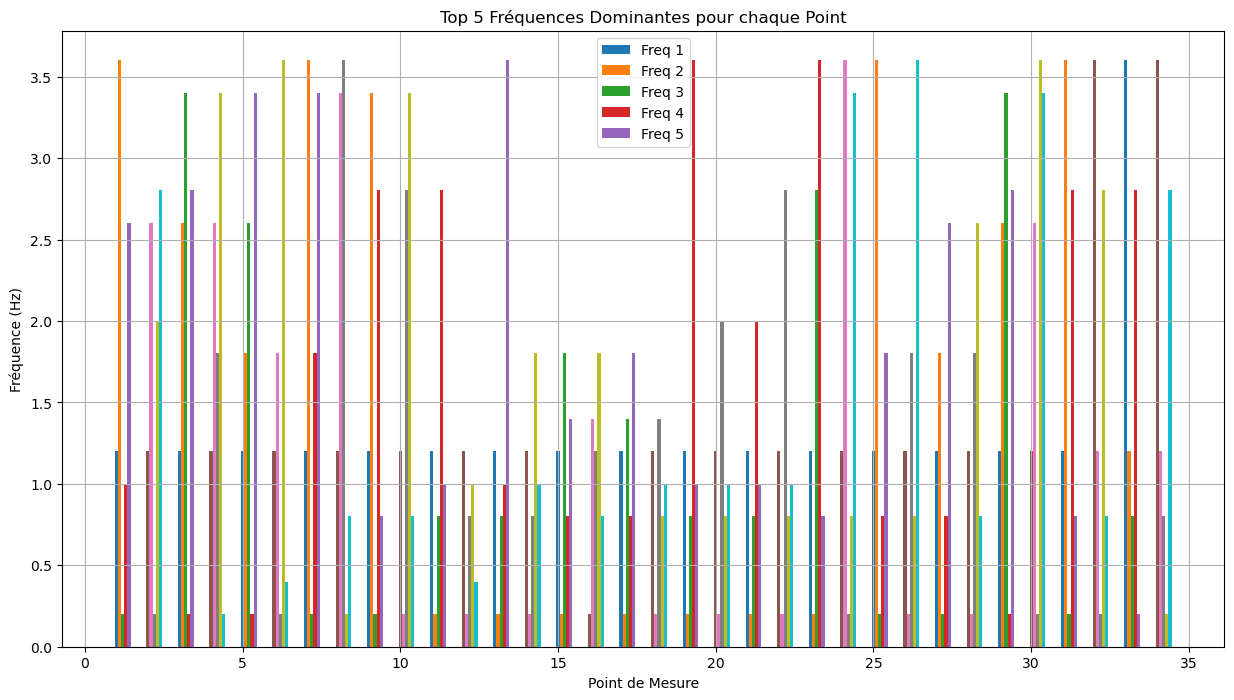

In [138]:
tracer_top_frequences_bars(top_frequencies_df)


##interpretations :

Les fréquences dominantes varient de manière significative le long du profil. Certaines fréquences restent stables sur plusieurs points de mesure, indiquant la présence de couches souterraines homogènes.

On observe des pics de fréquences à certains points de mesure, par exemple, autour de 3,5 Hz à plusieurs points. Ces pics peuvent indiquer des objets enfouis ou des interfaces distinctes entre différents types de matériaux.

Les transitions rapides des fréquences dominantes, visibles par les changements abrupts de hauteur des barres colorées, suggèrent des interfaces nettes entre différentes couches de matériaux souterrains.

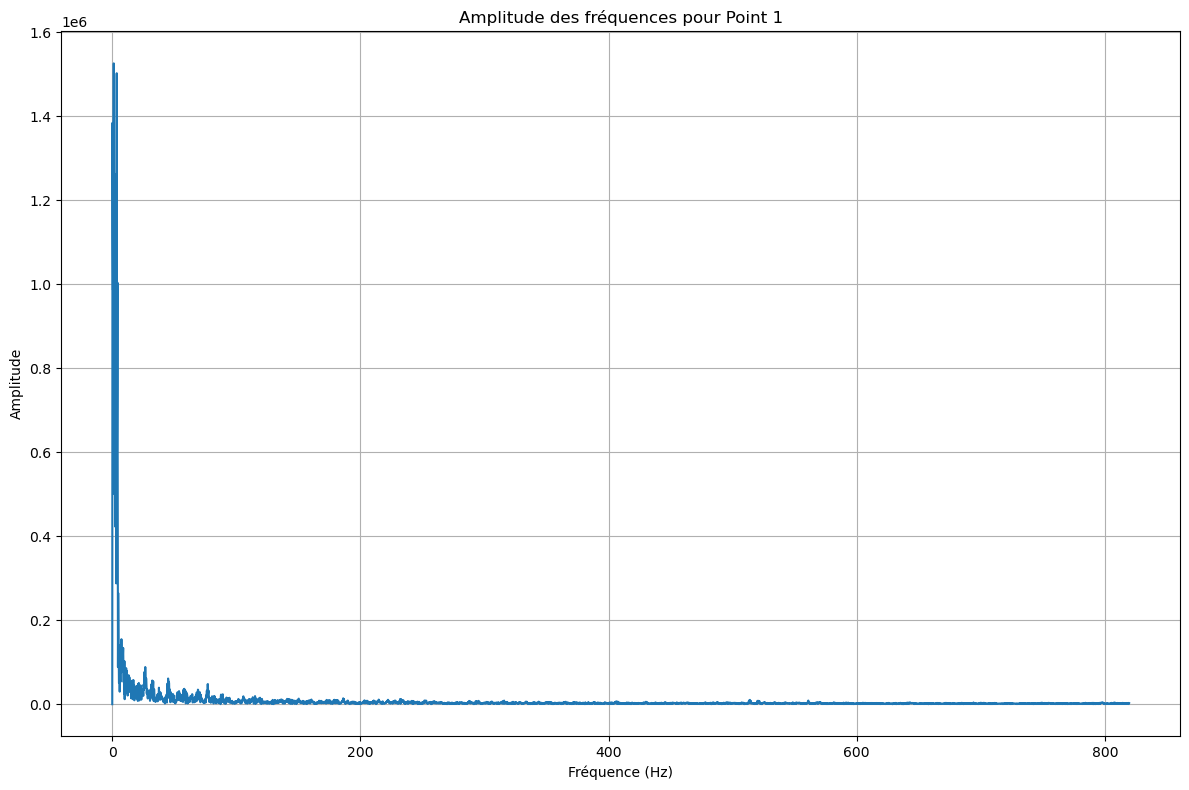

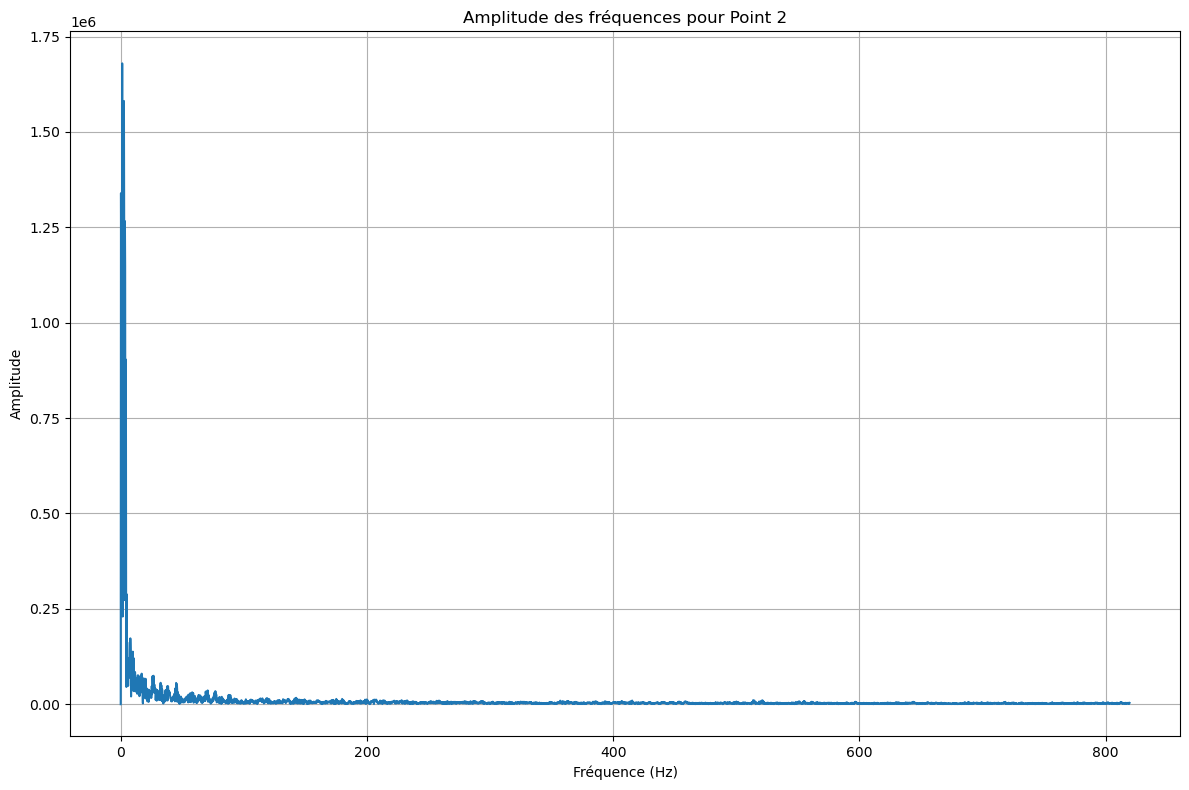

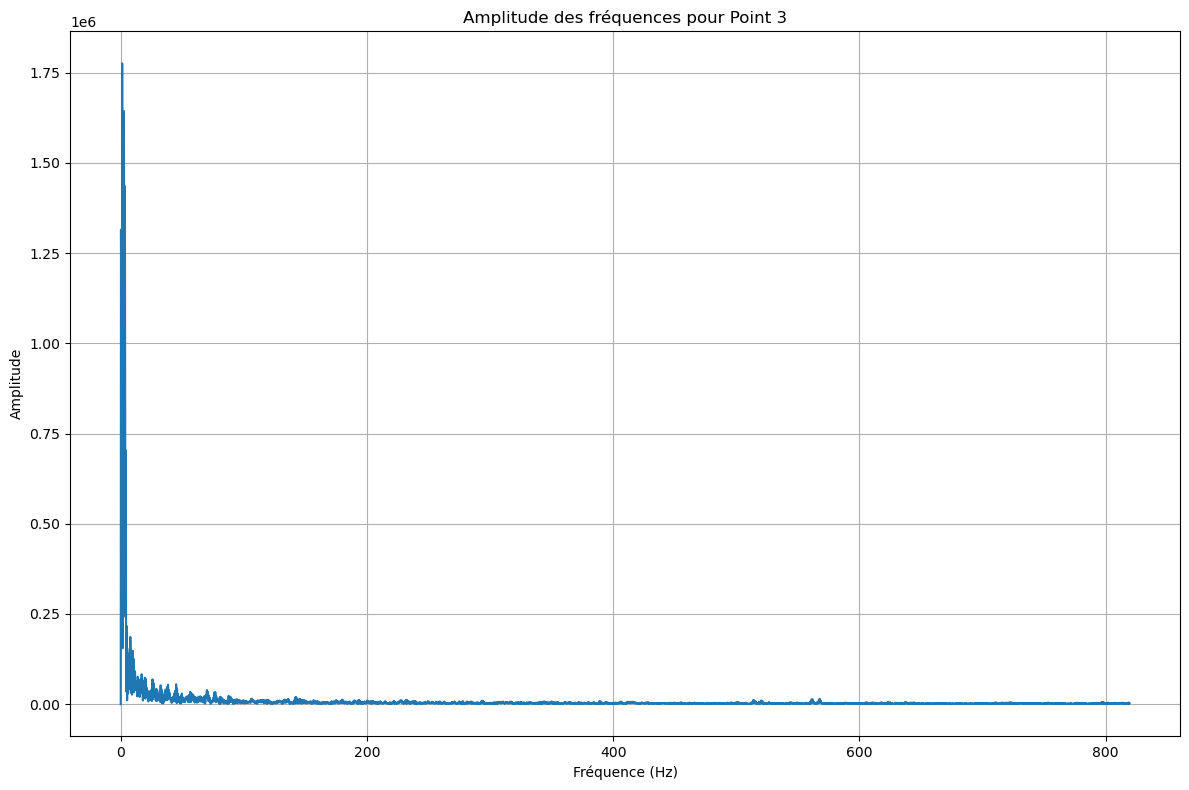

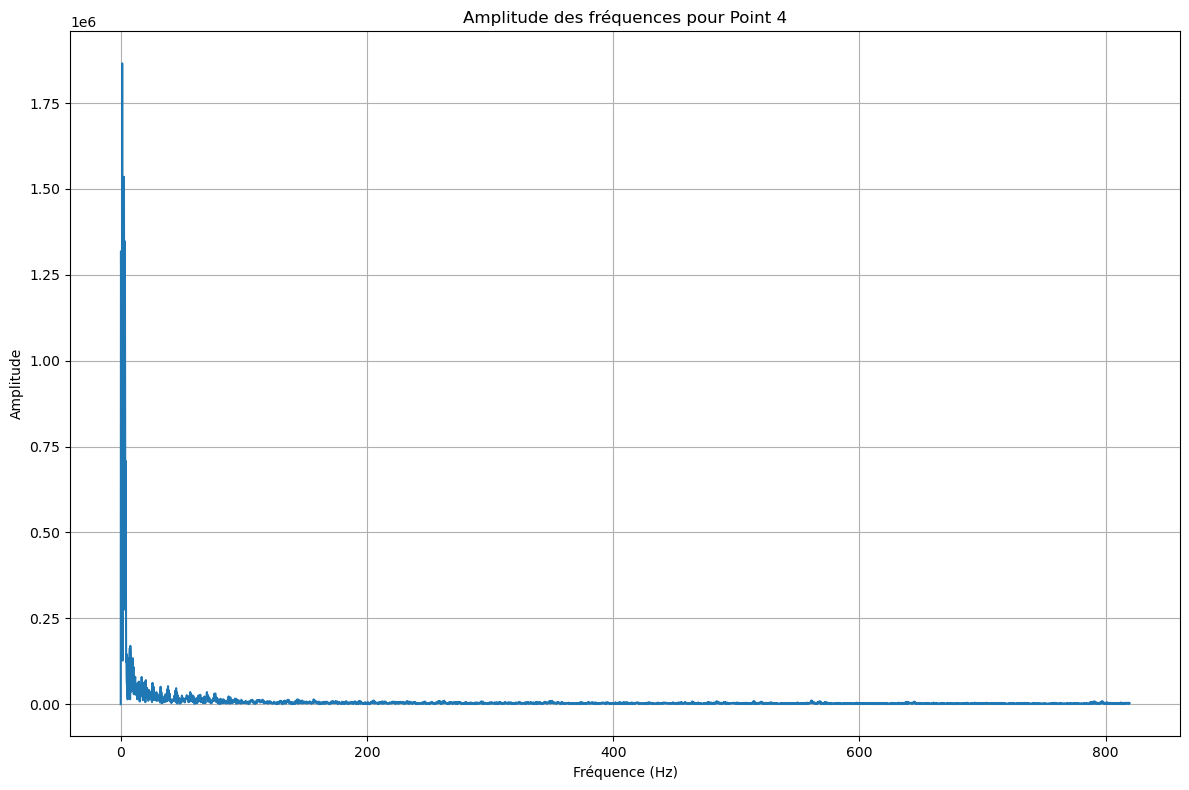

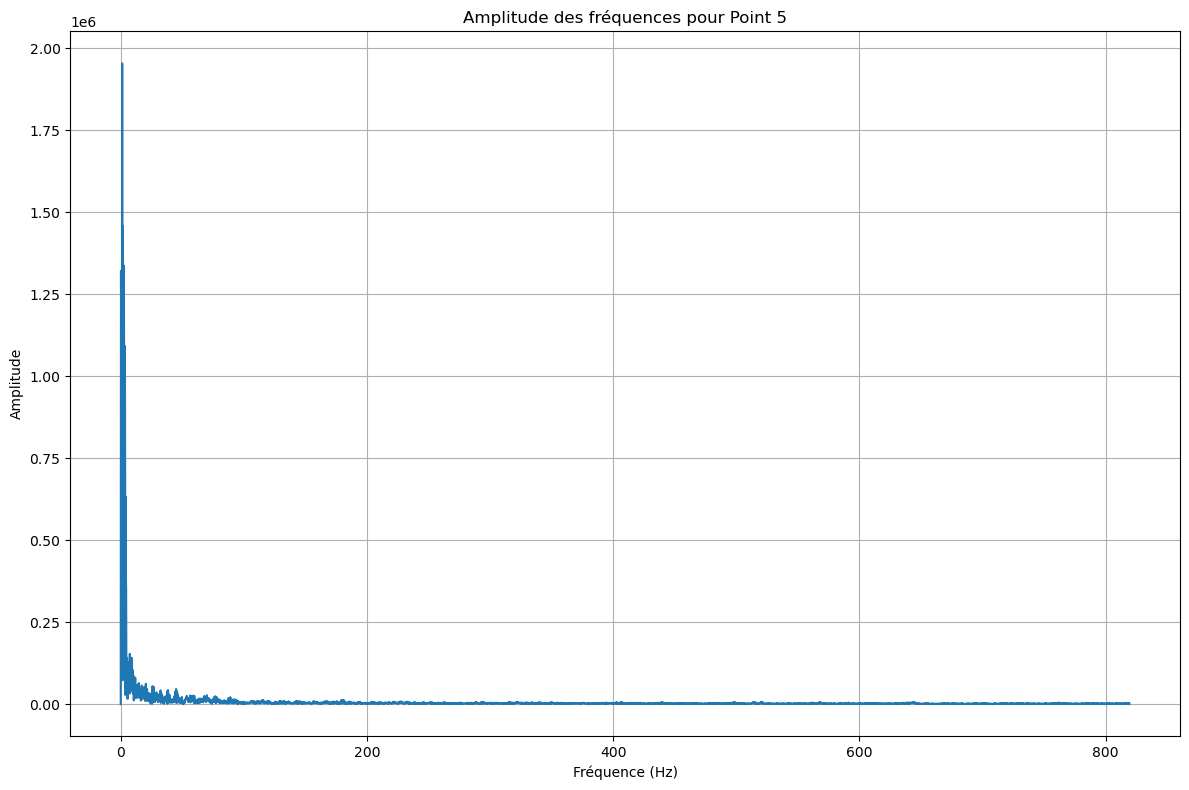

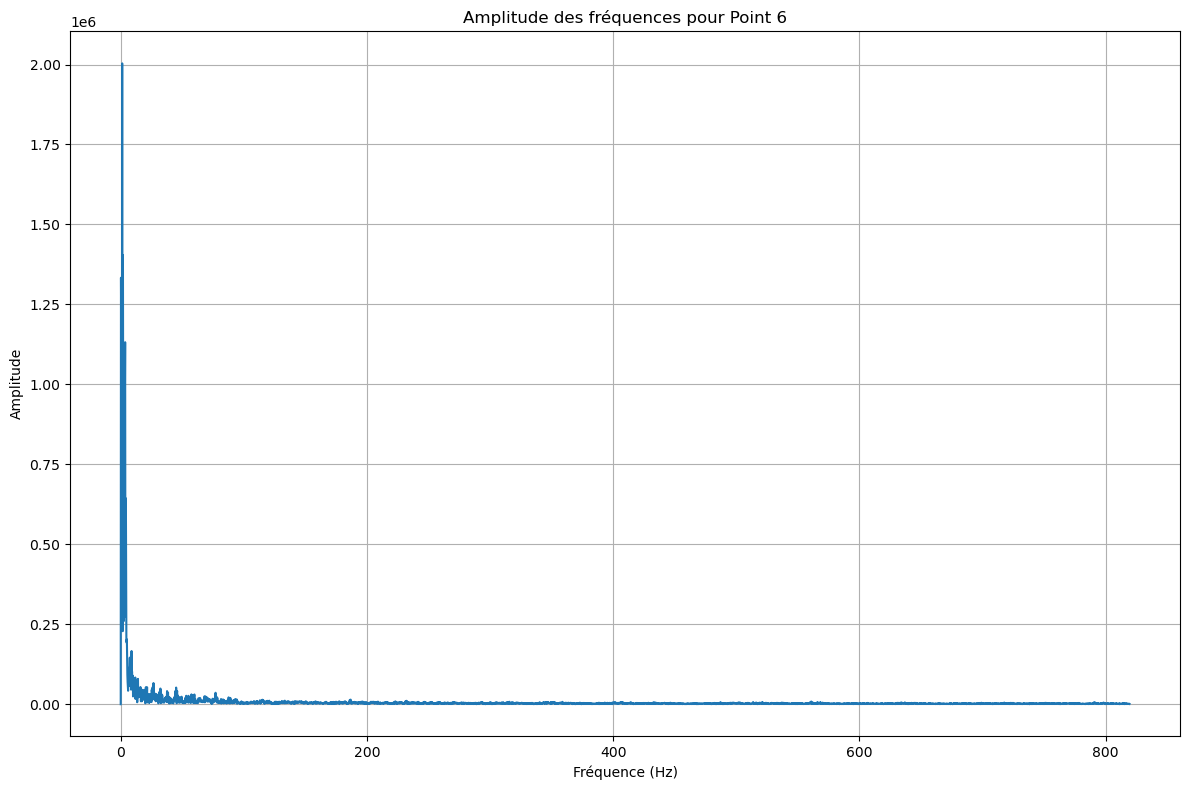

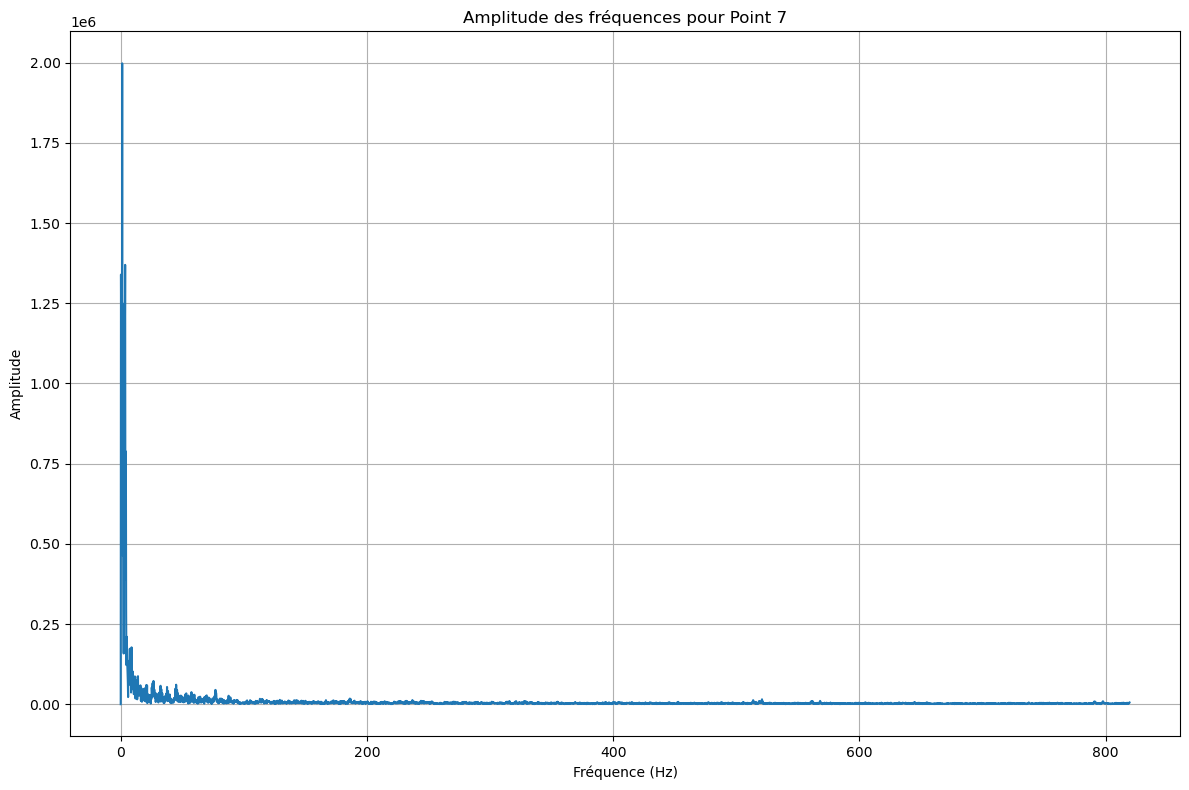

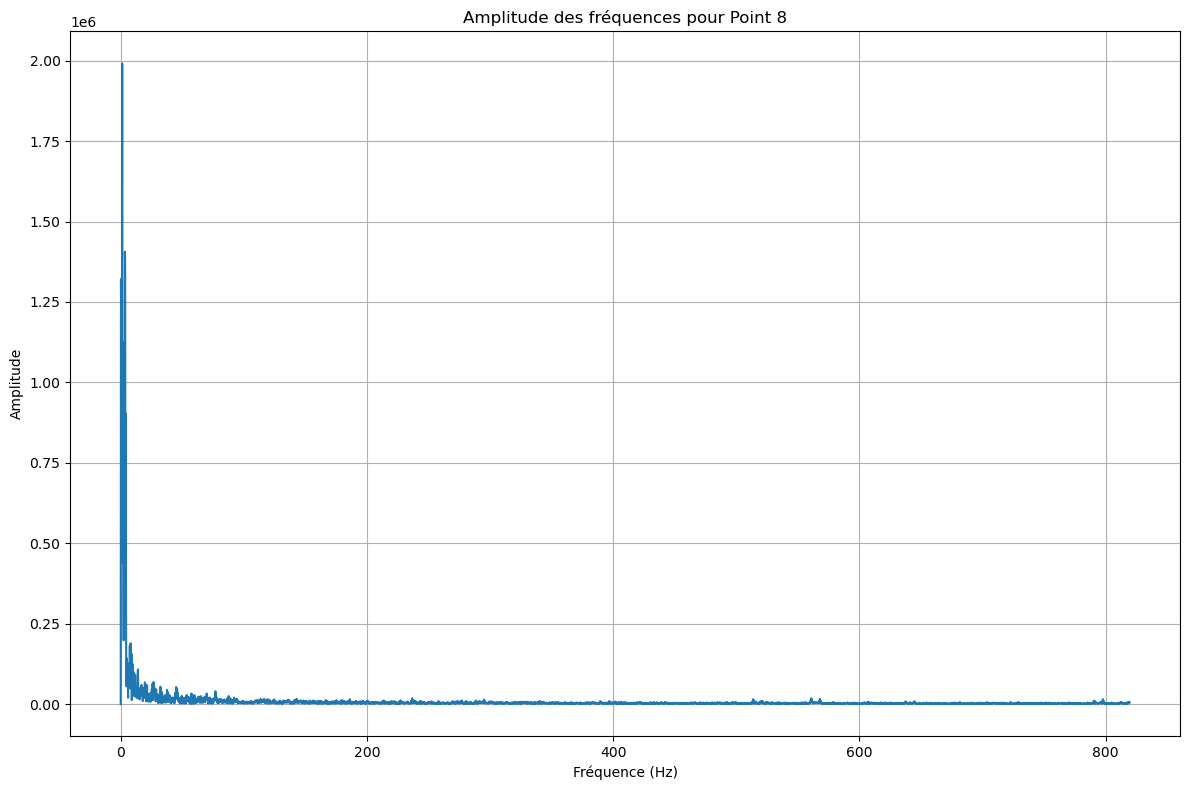

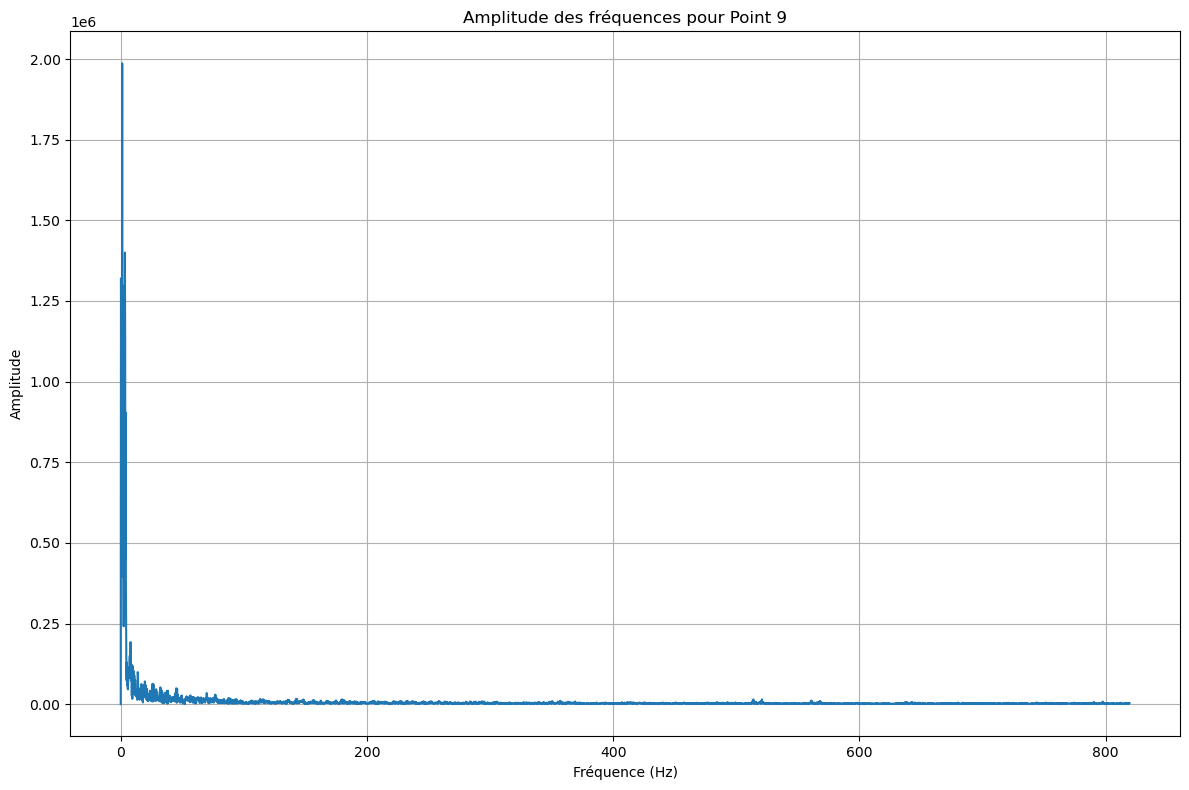

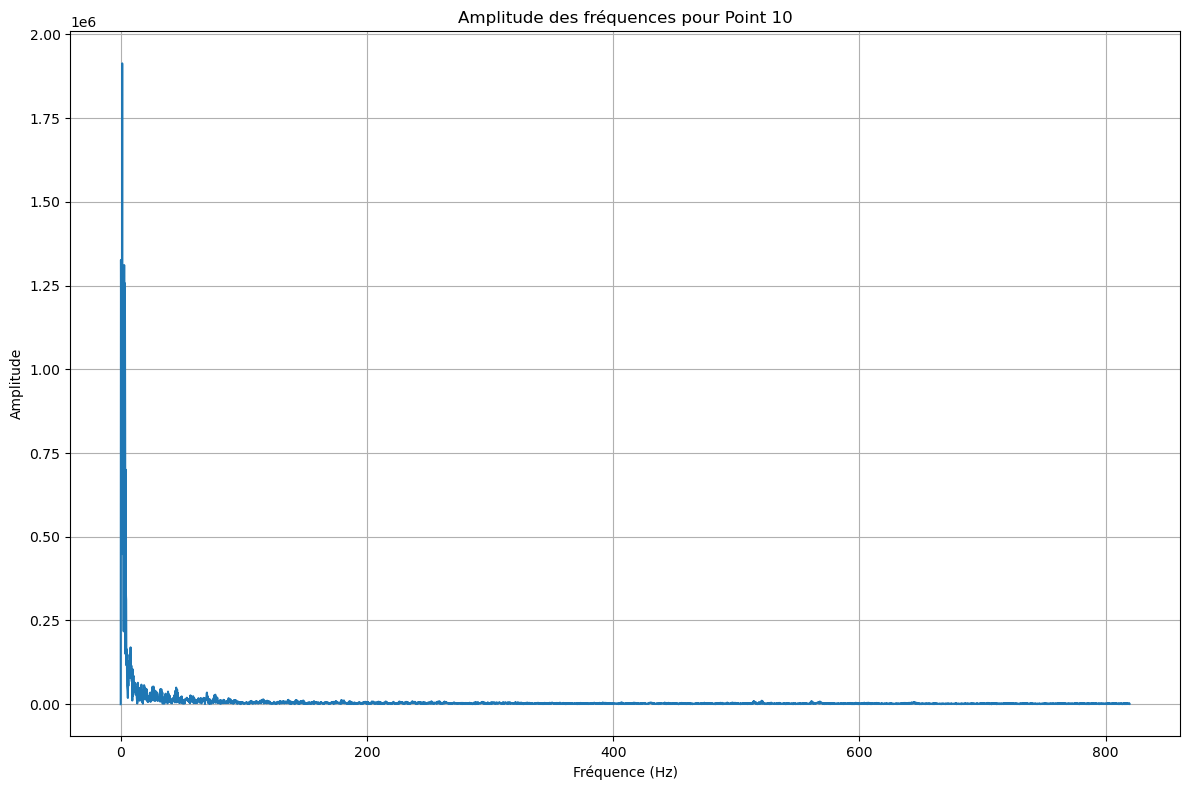

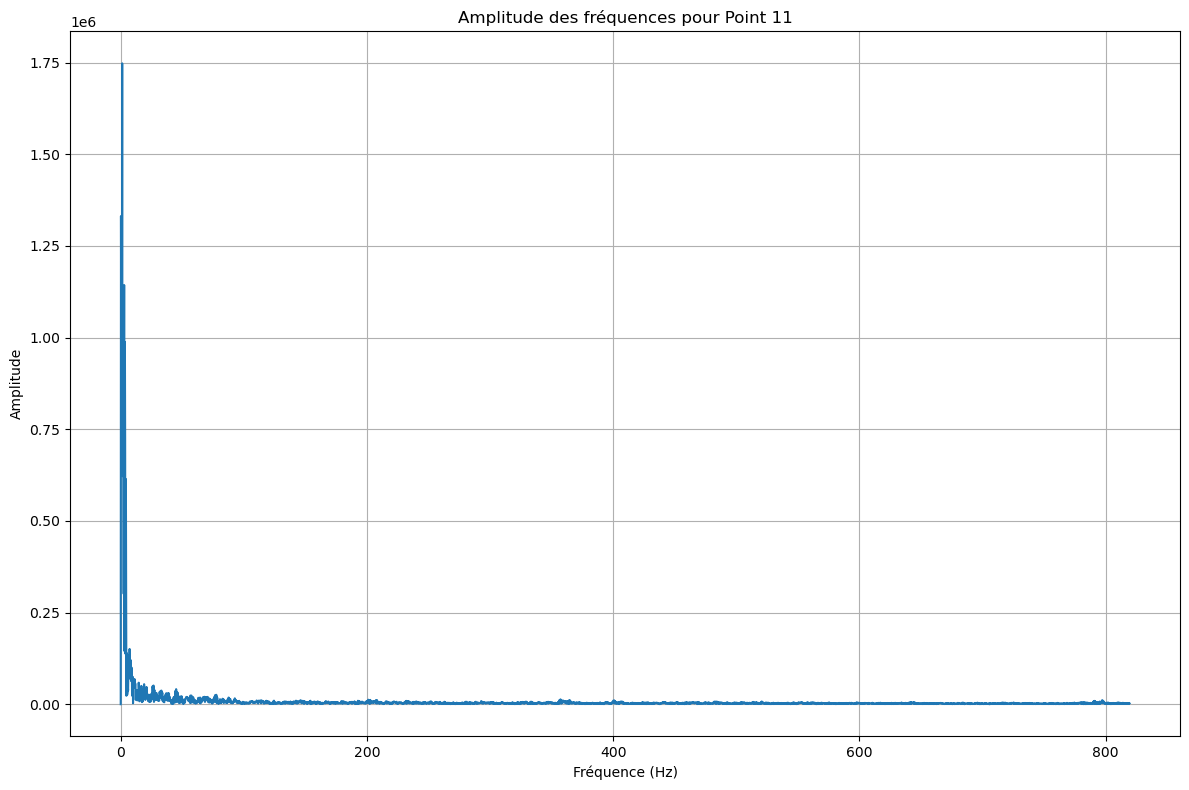

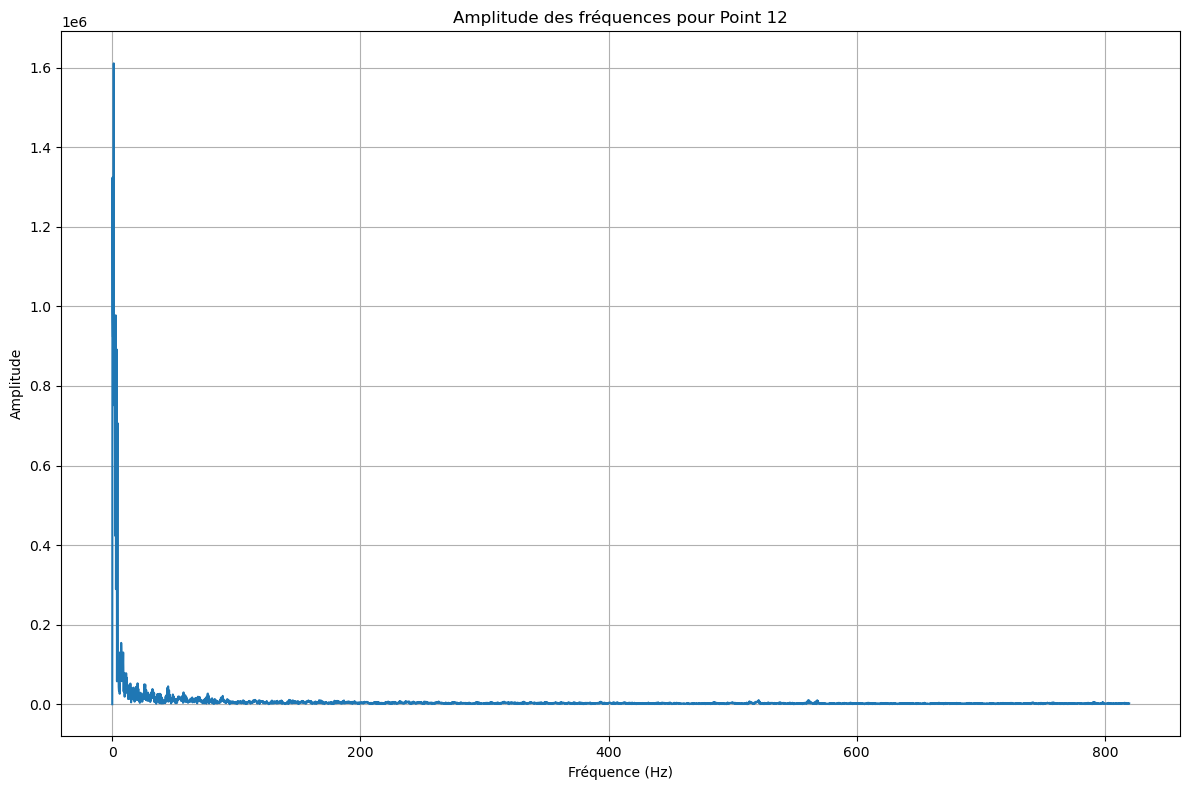

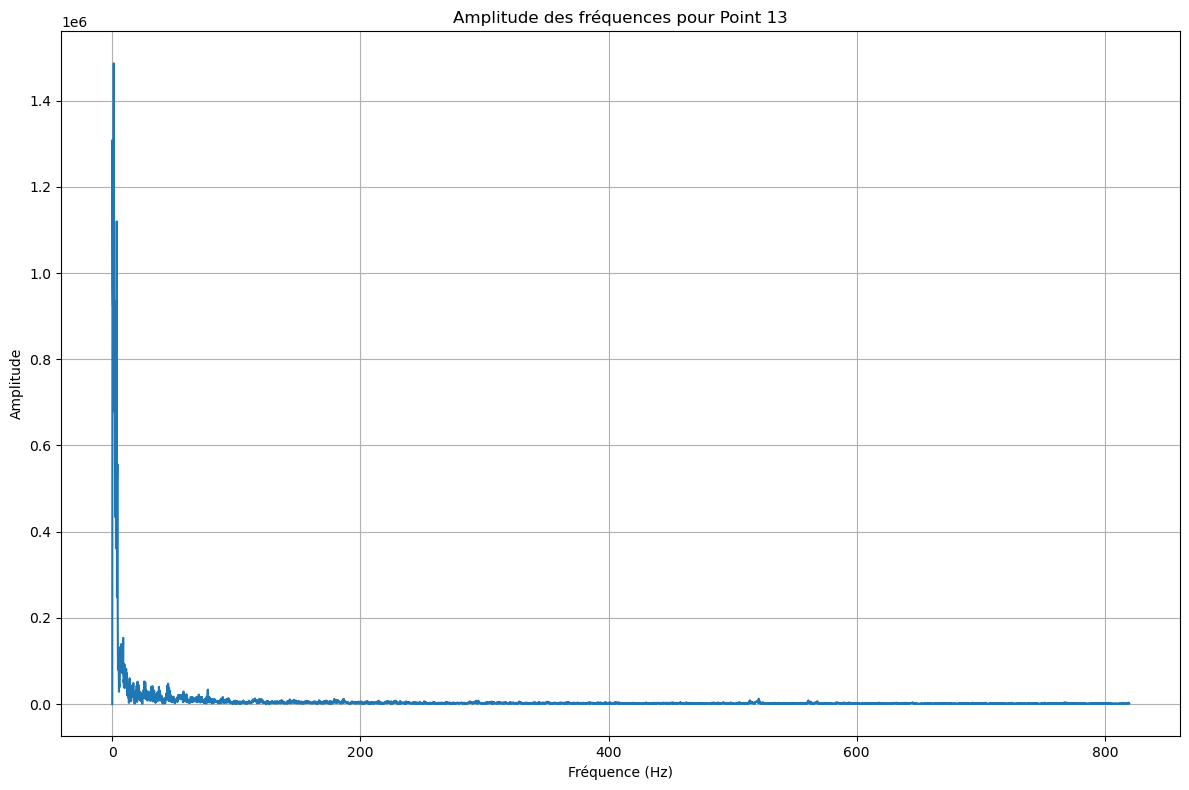

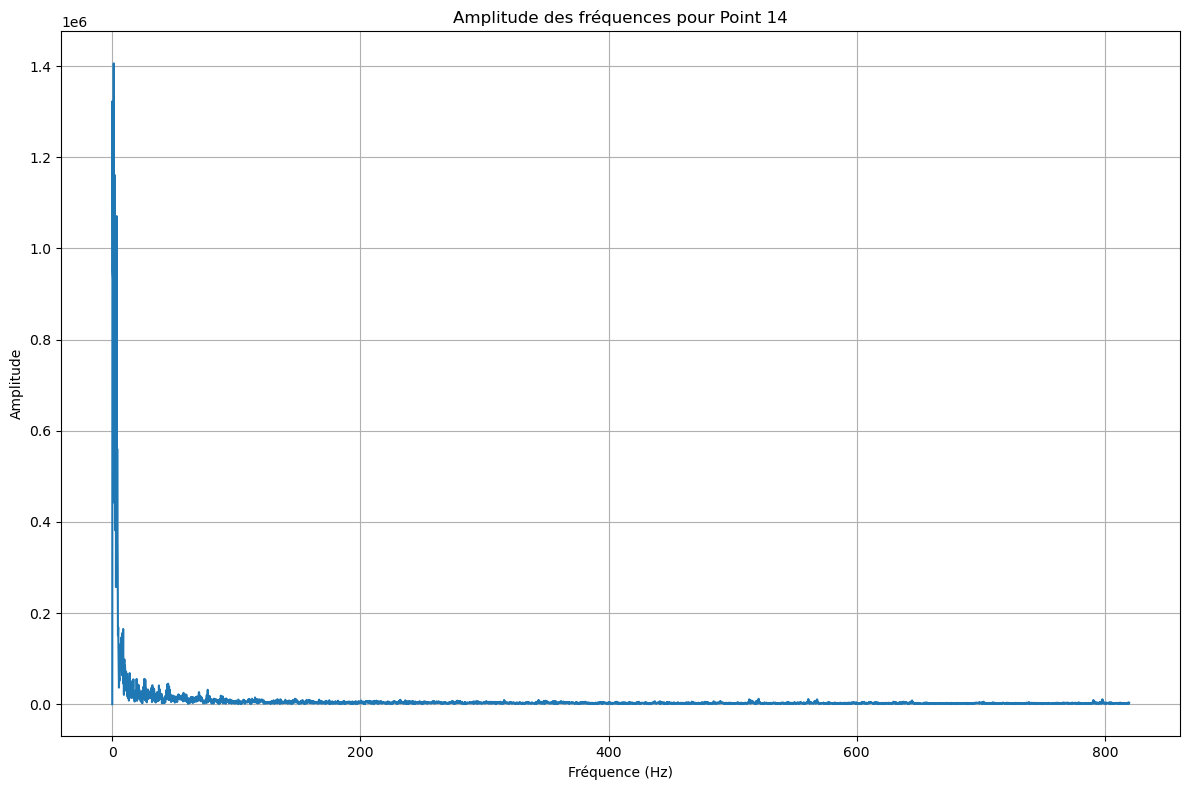

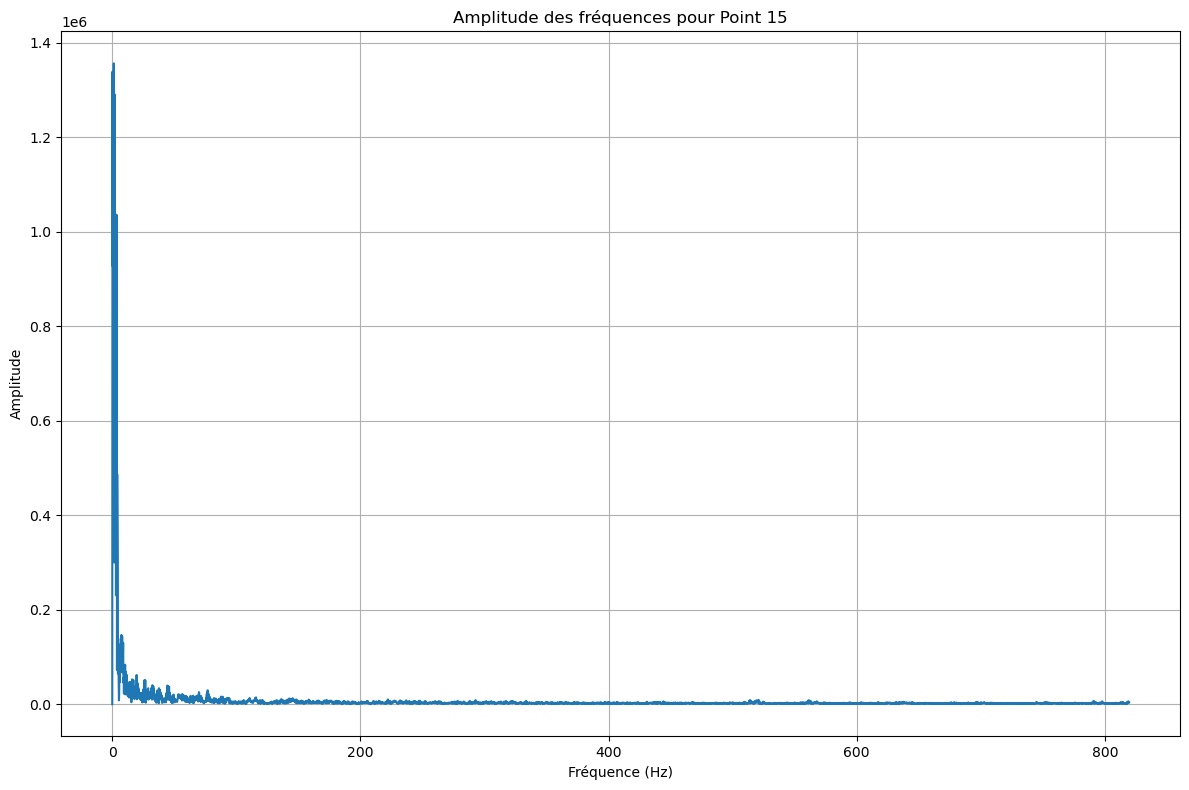

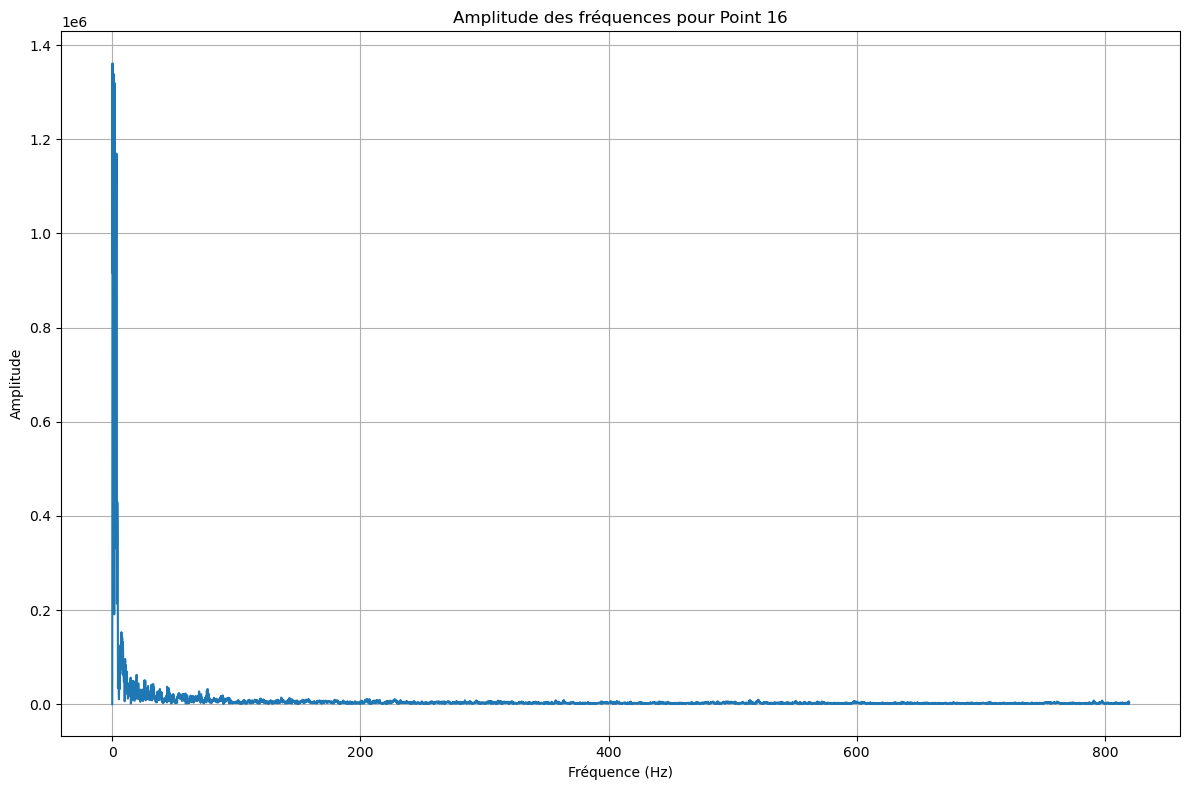

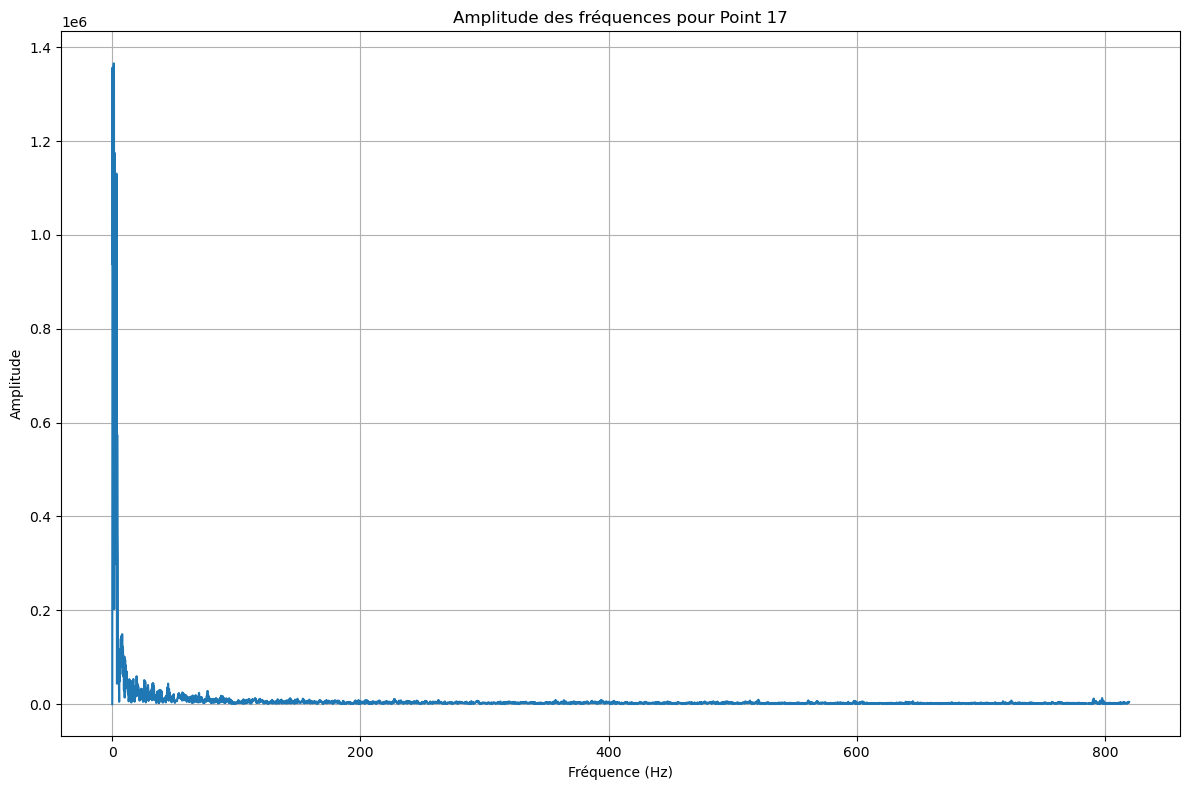

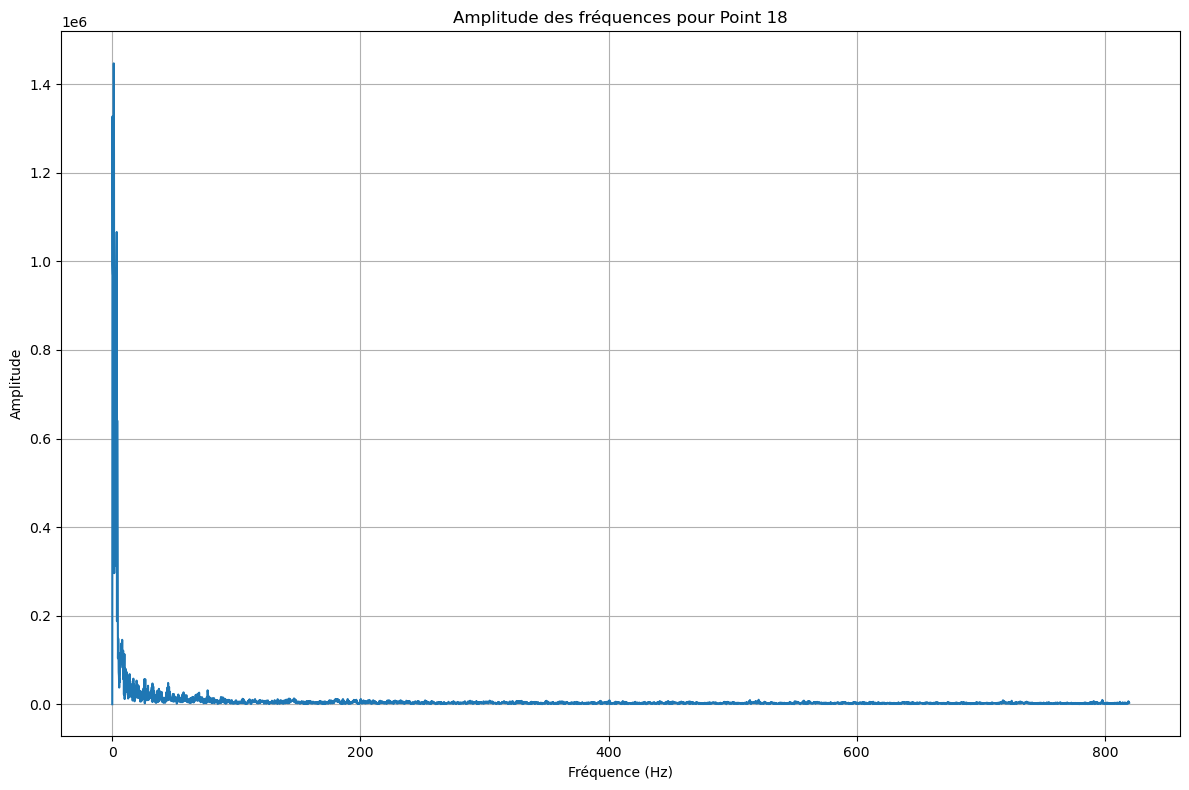

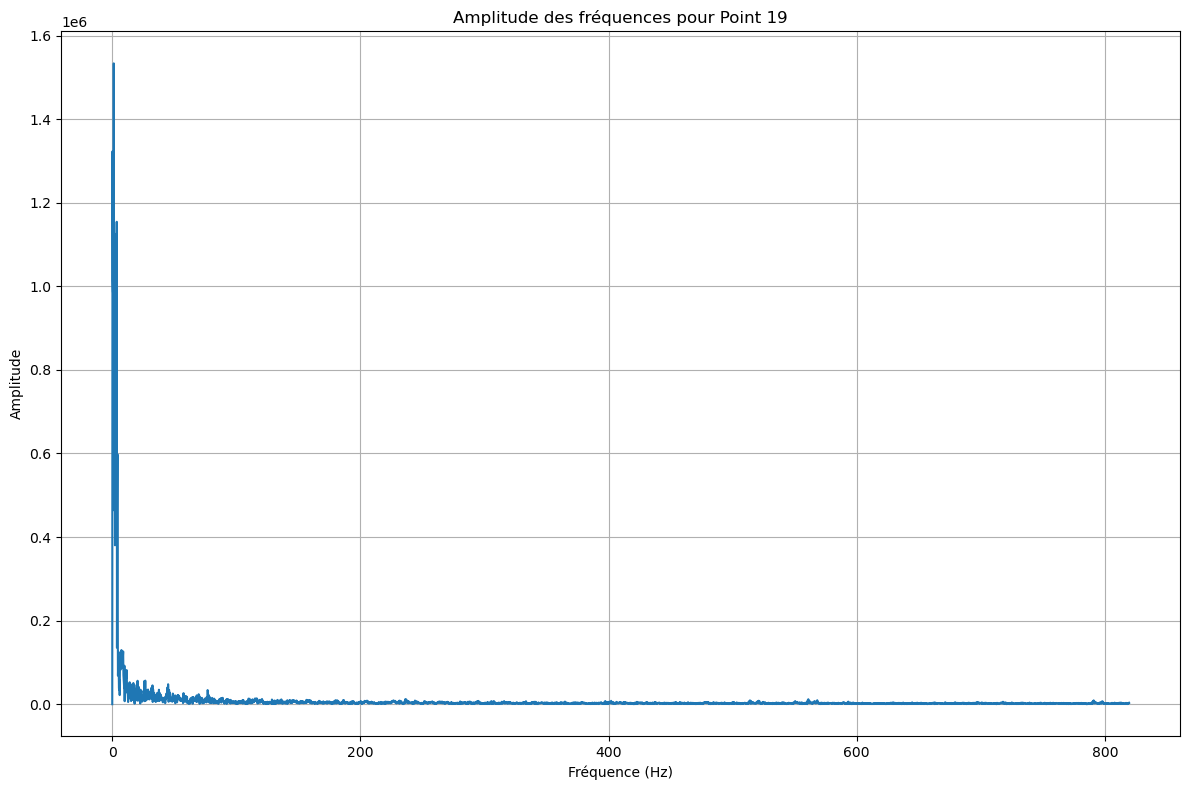

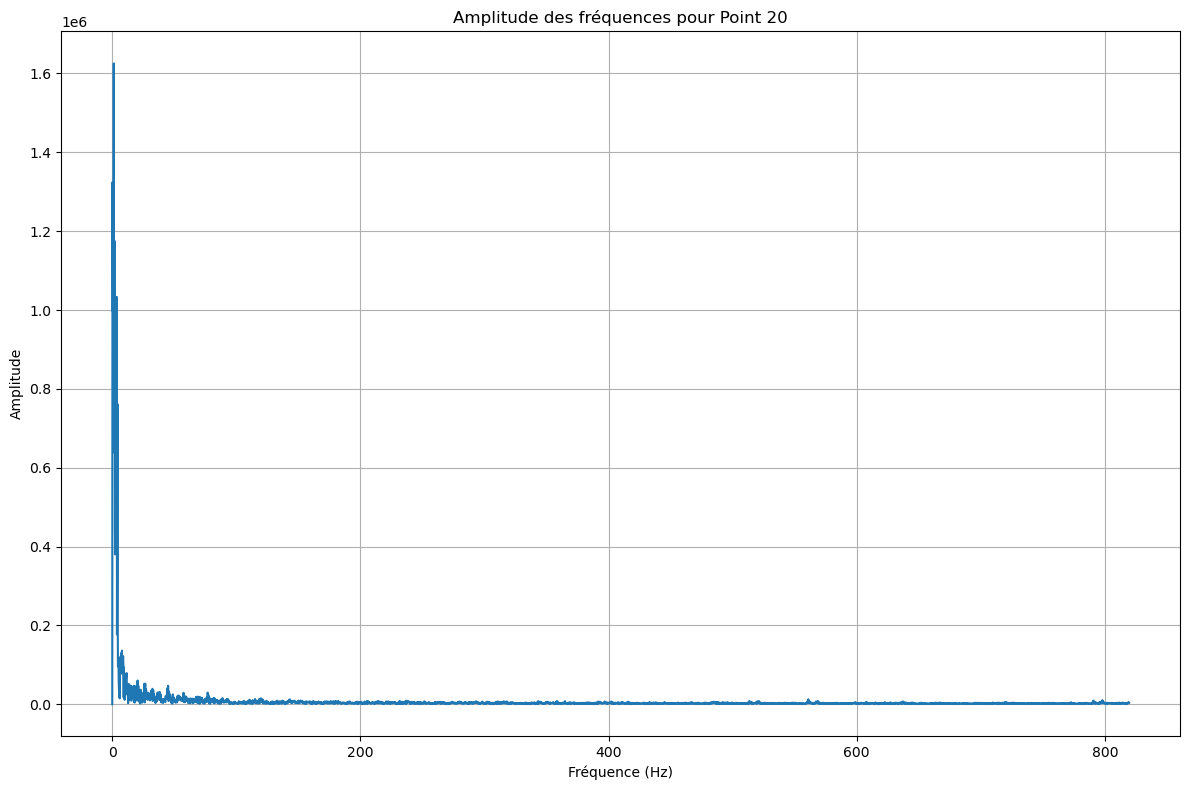

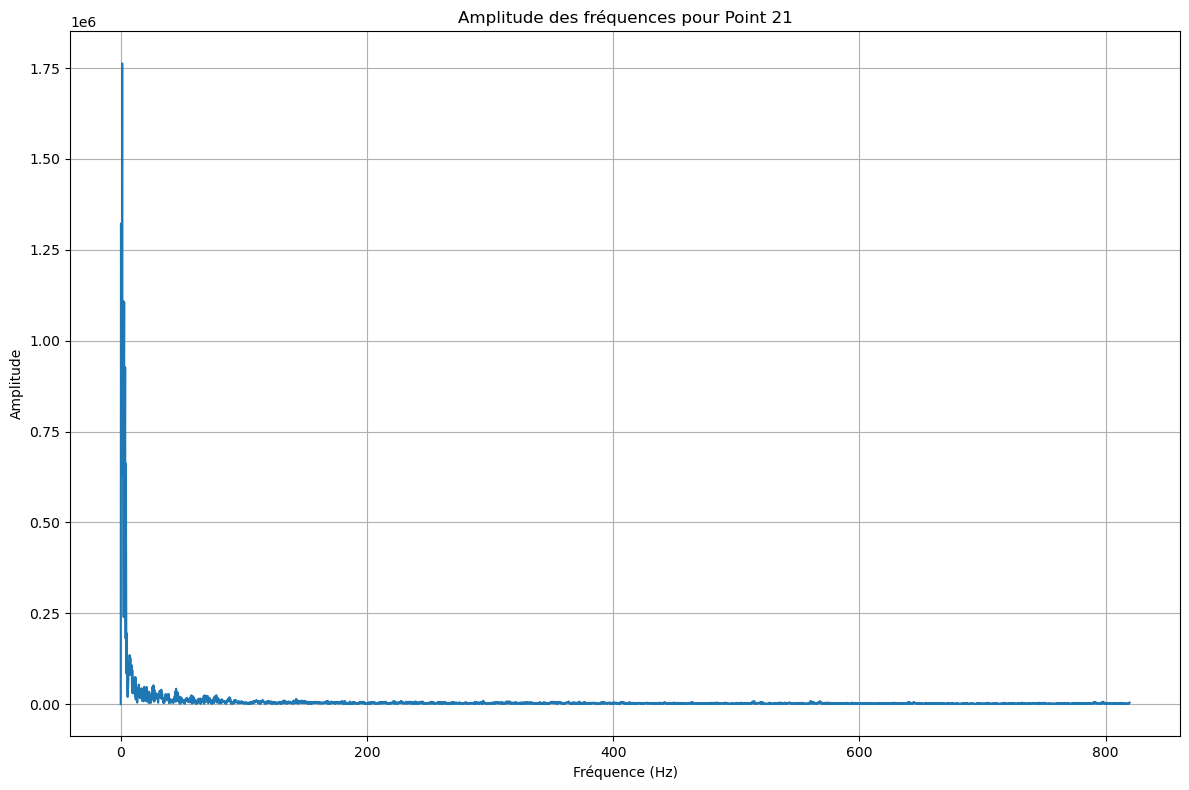

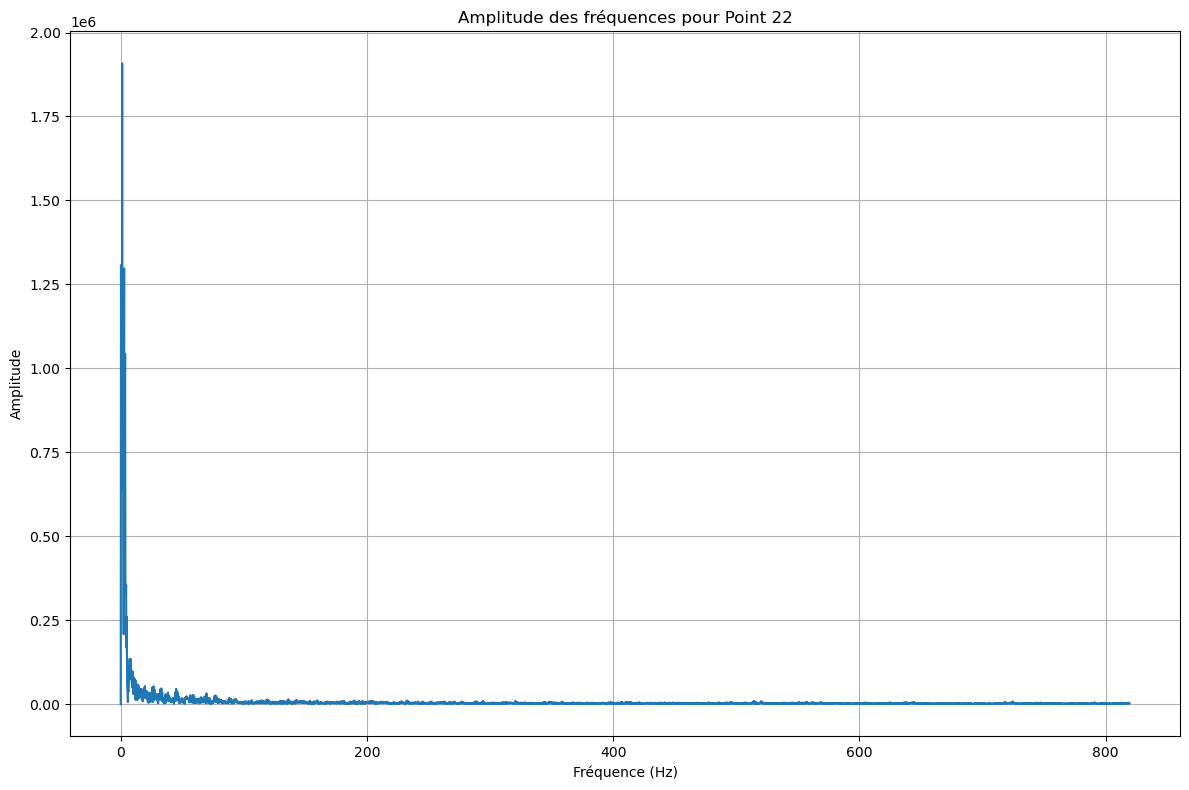

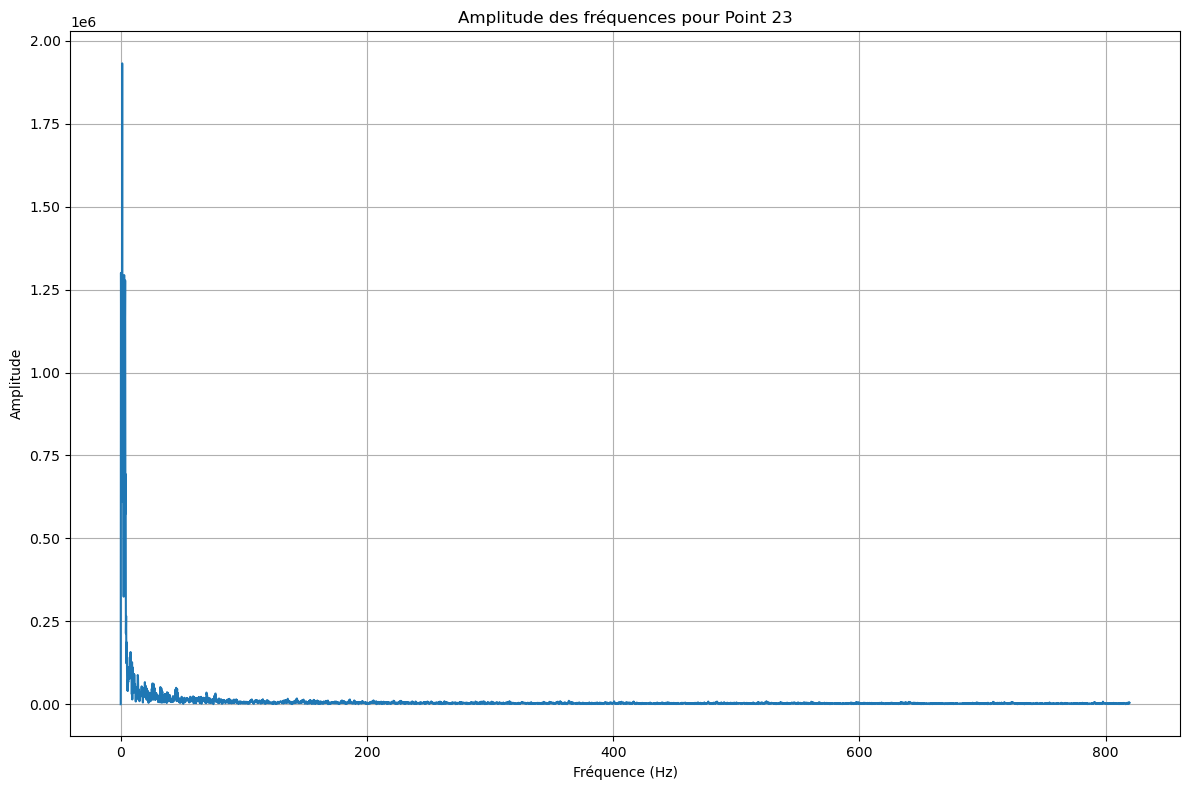

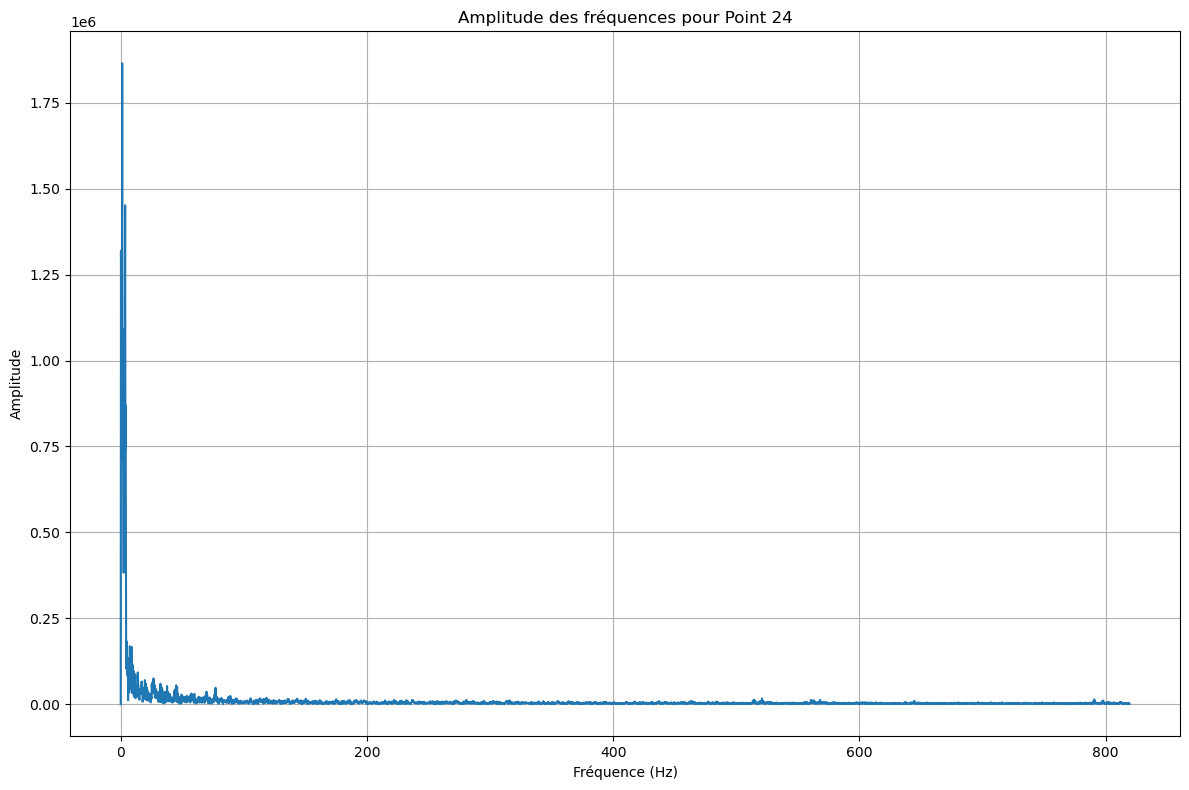

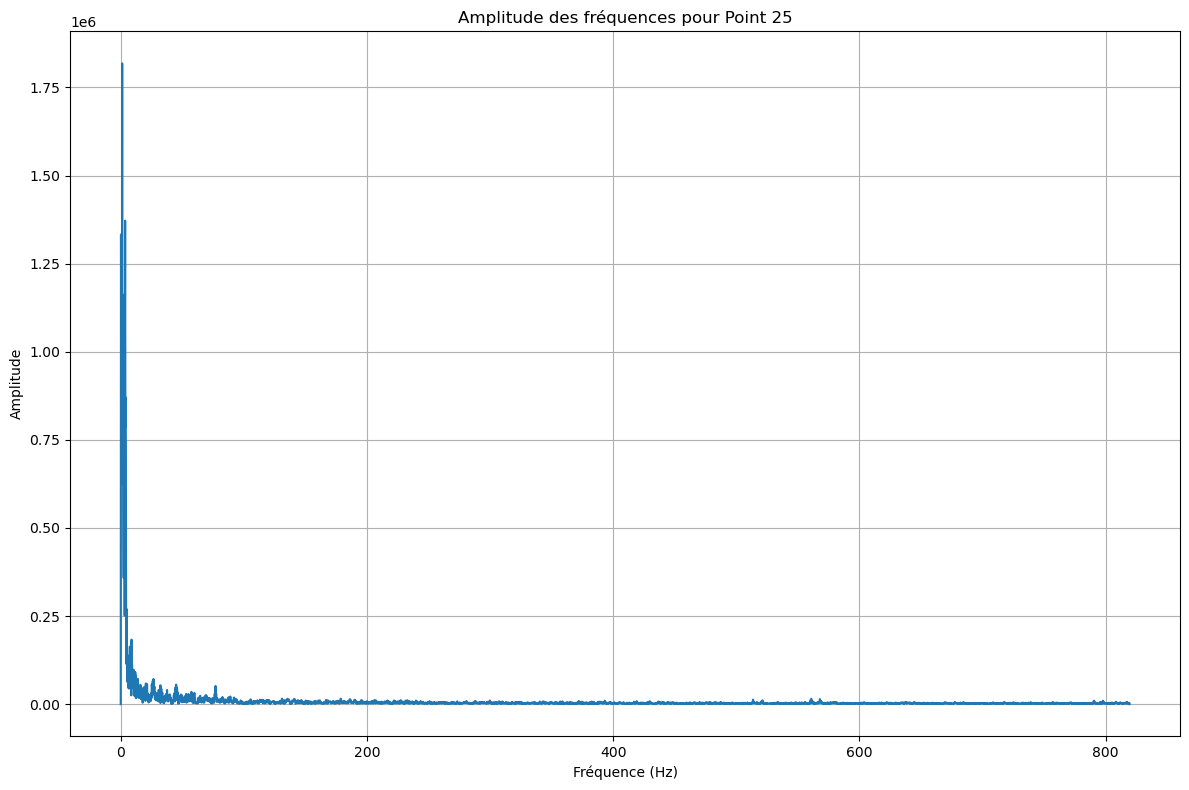

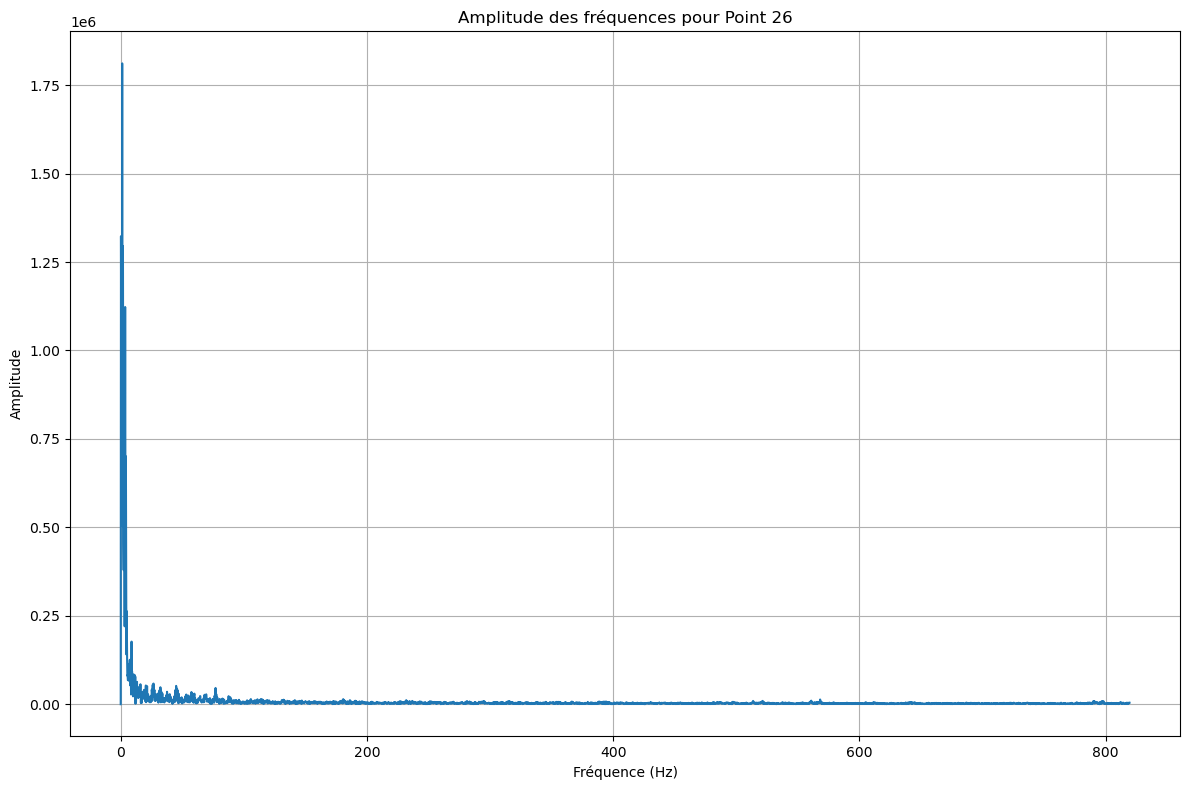

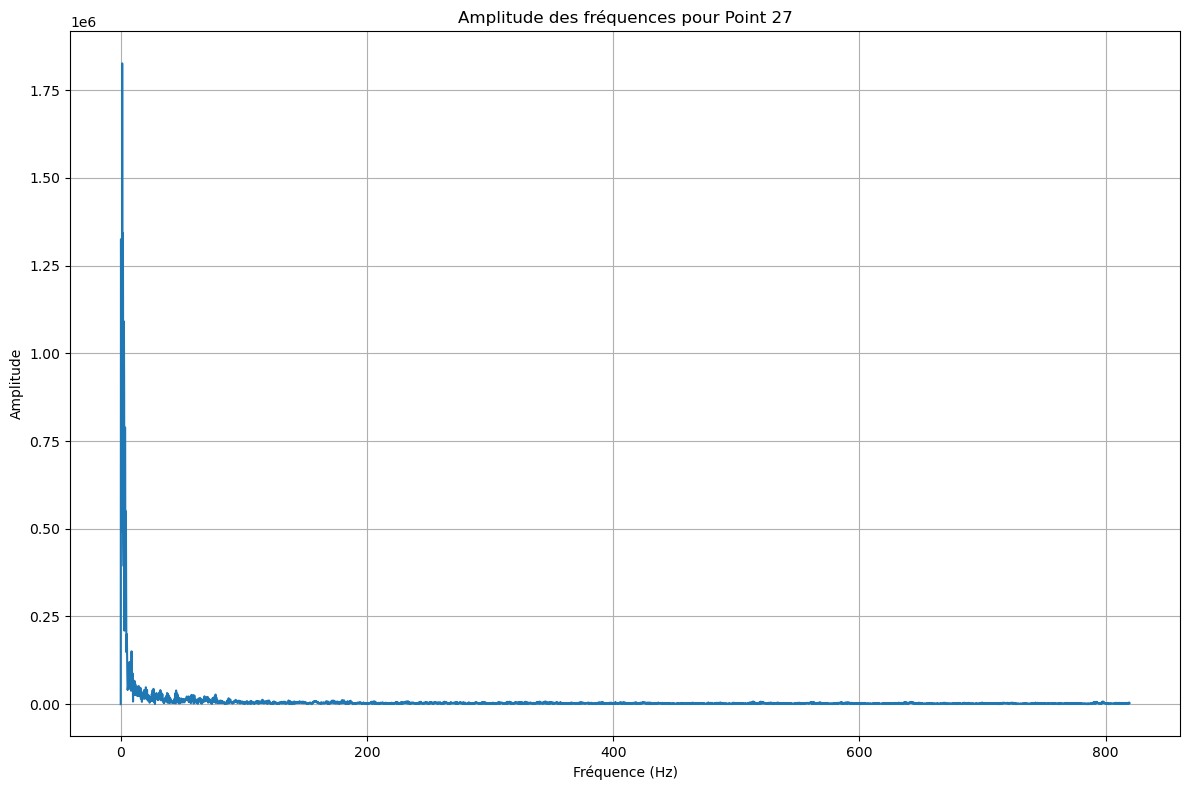

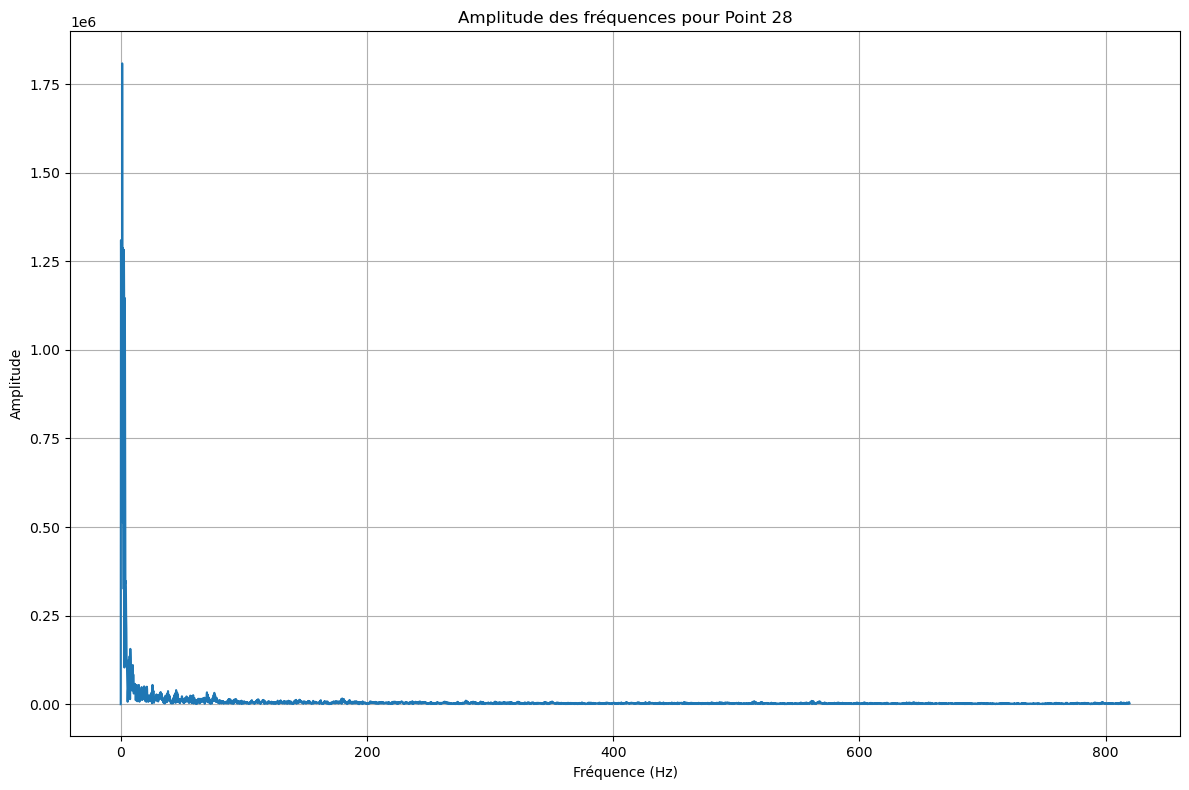

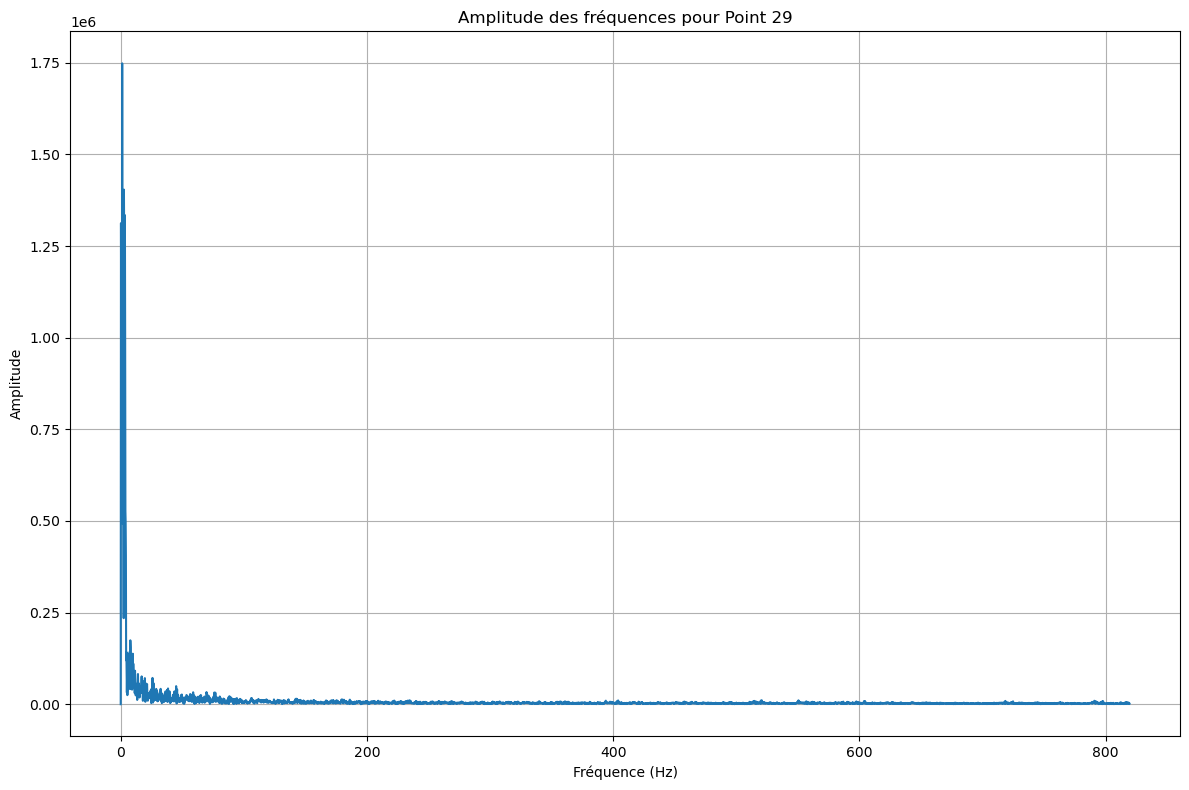

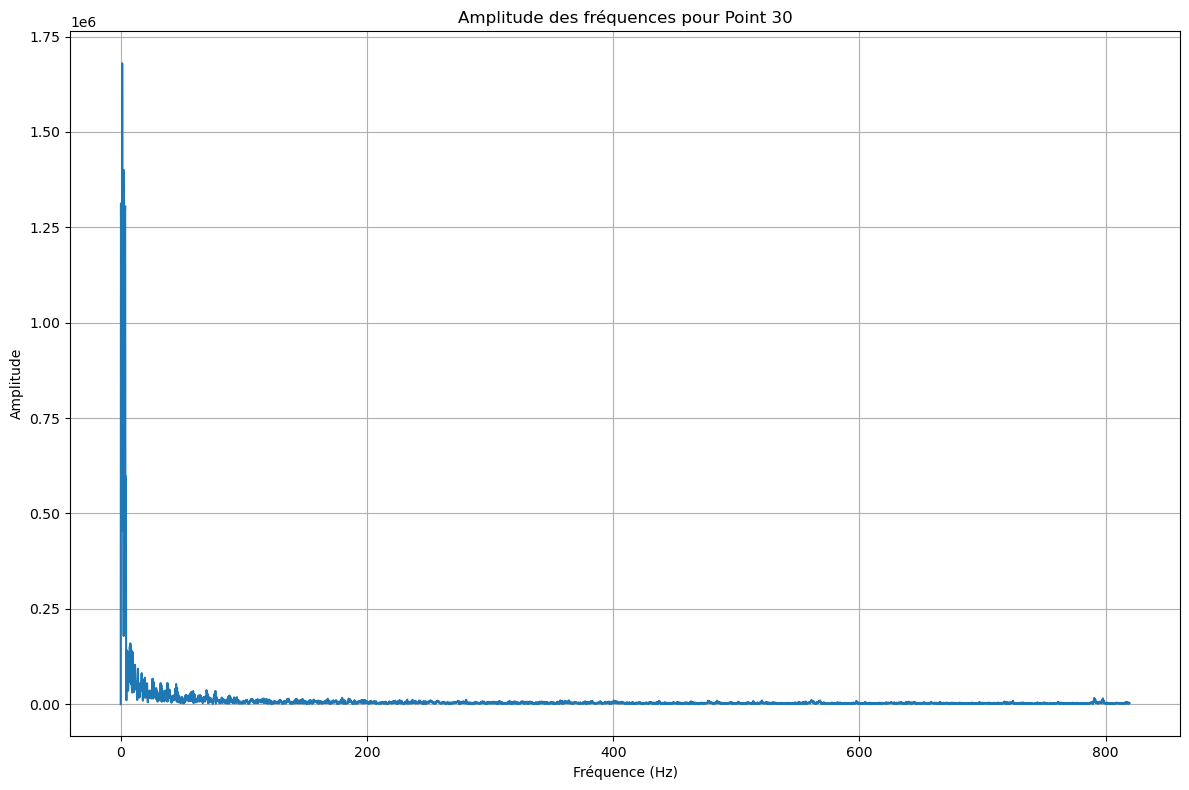

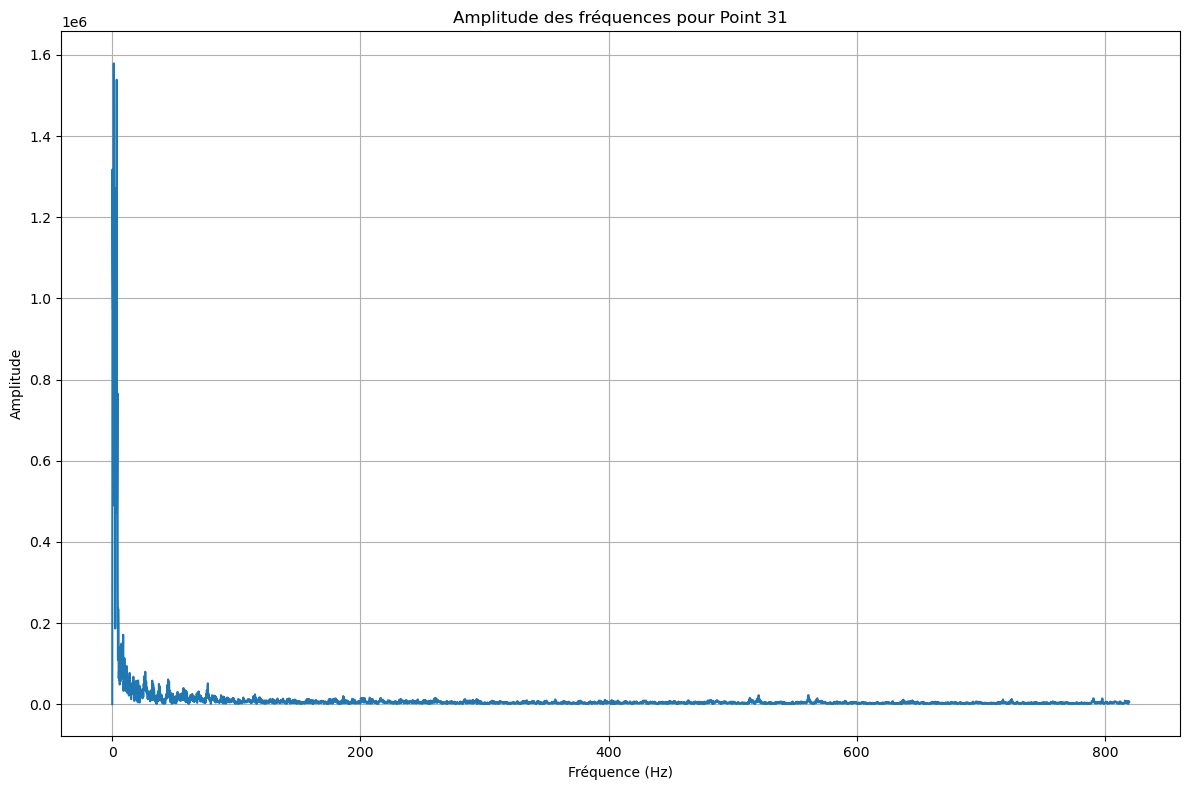

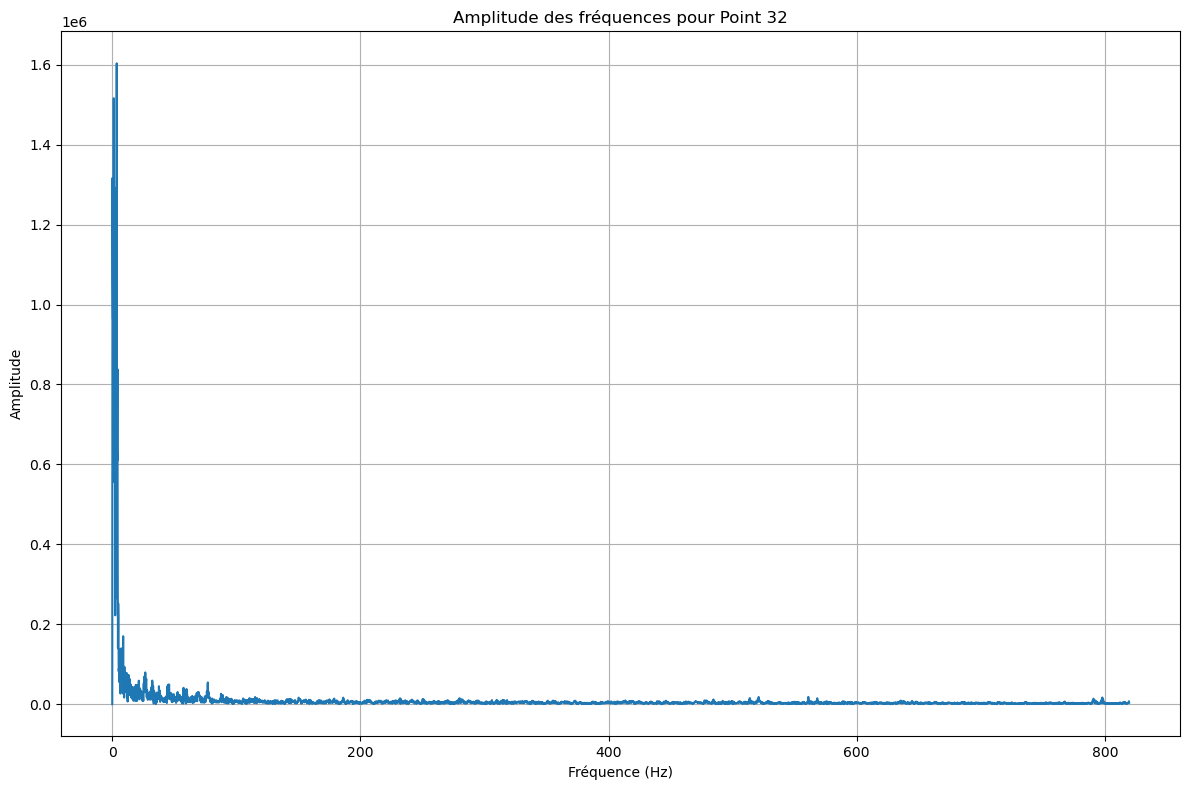

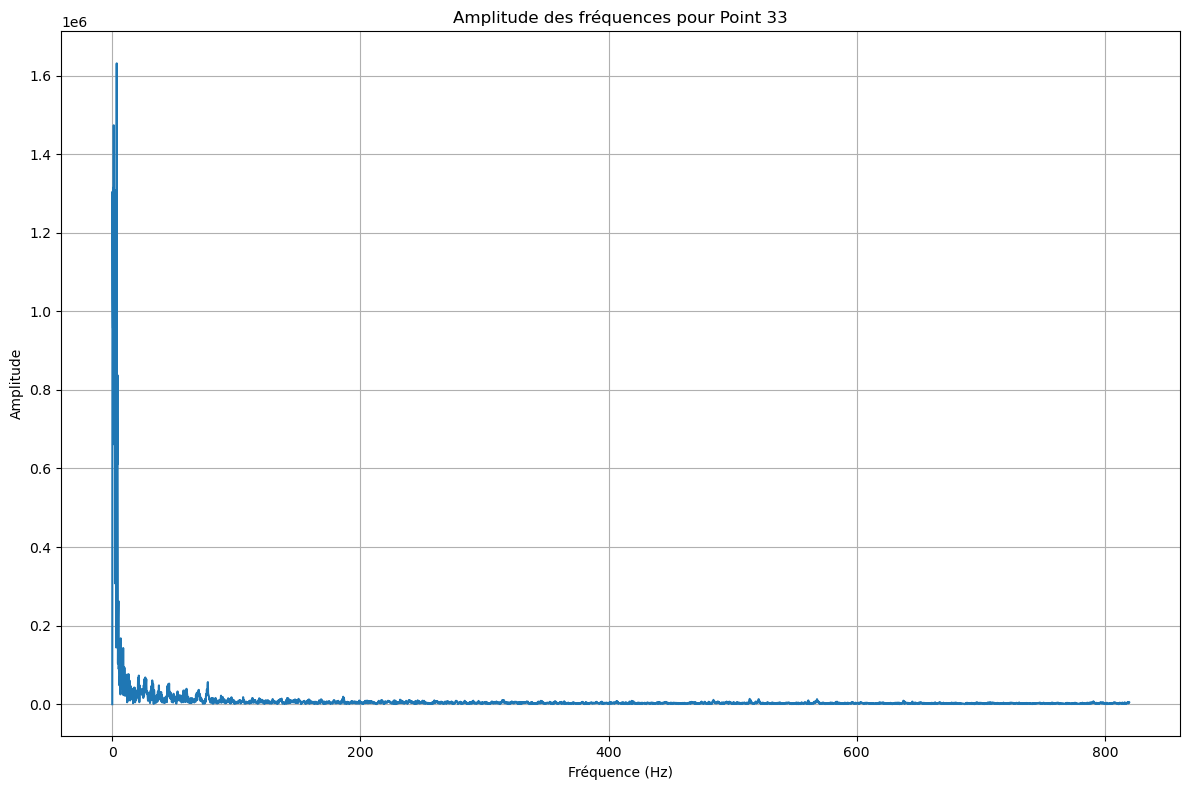

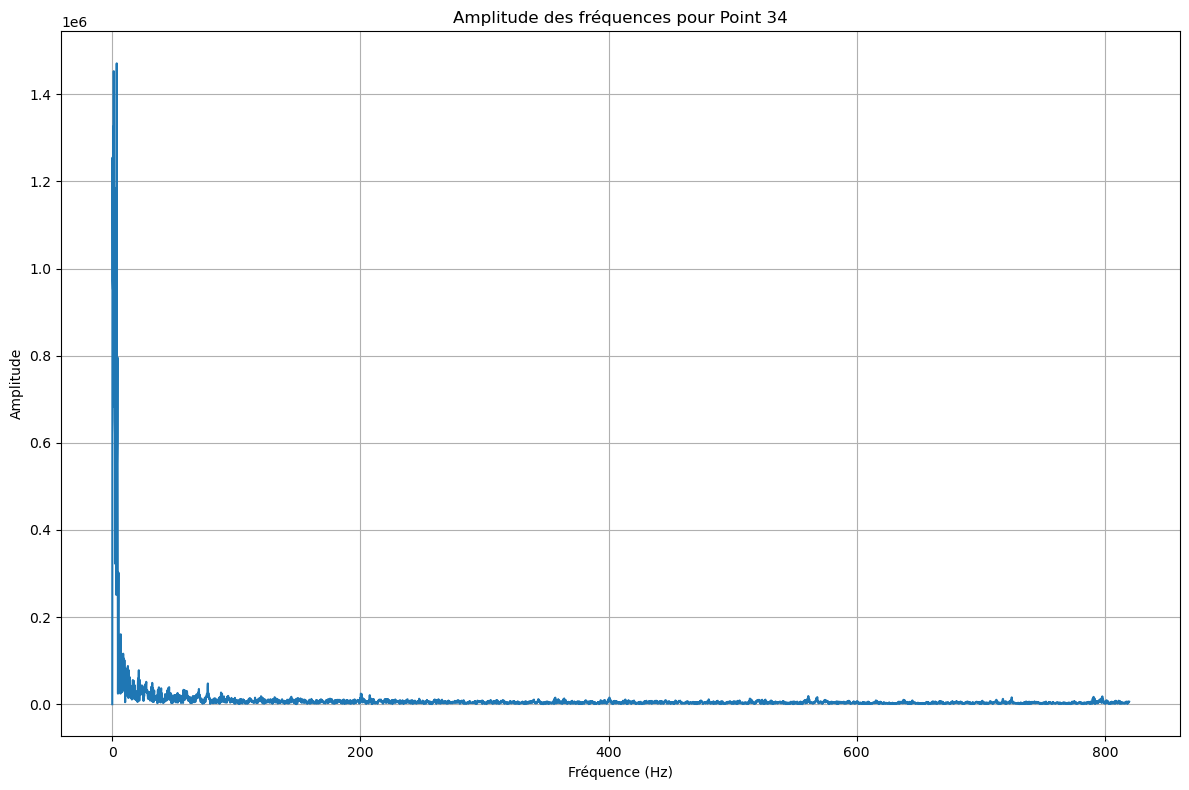

In [142]:
visualiser_matrice_fft_par_point(fft_df_sans_dc)


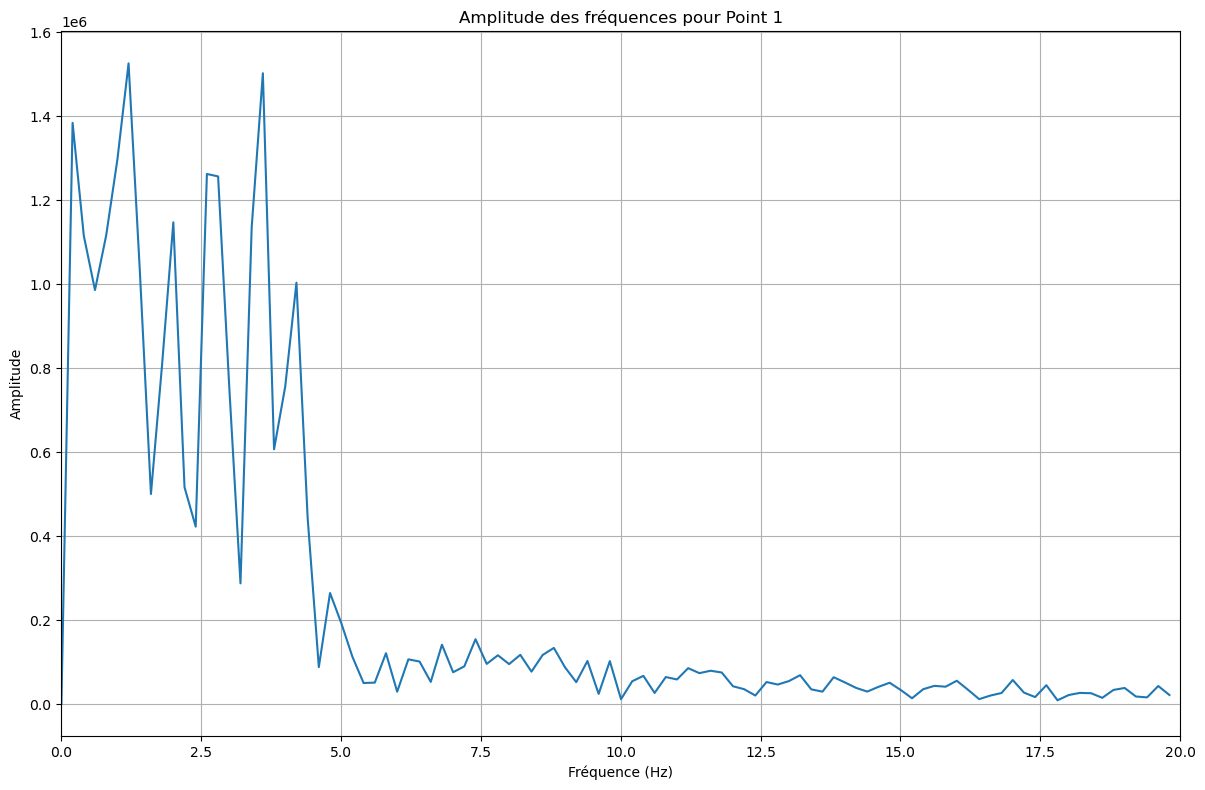

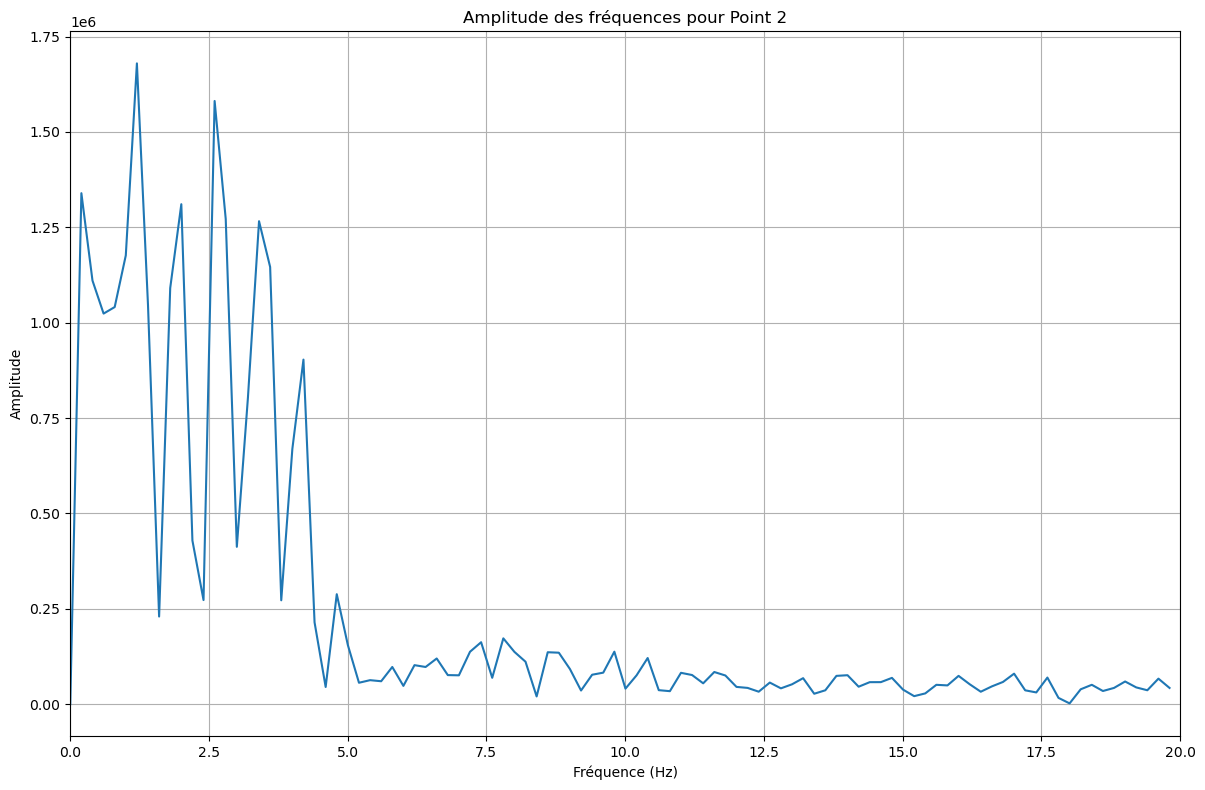

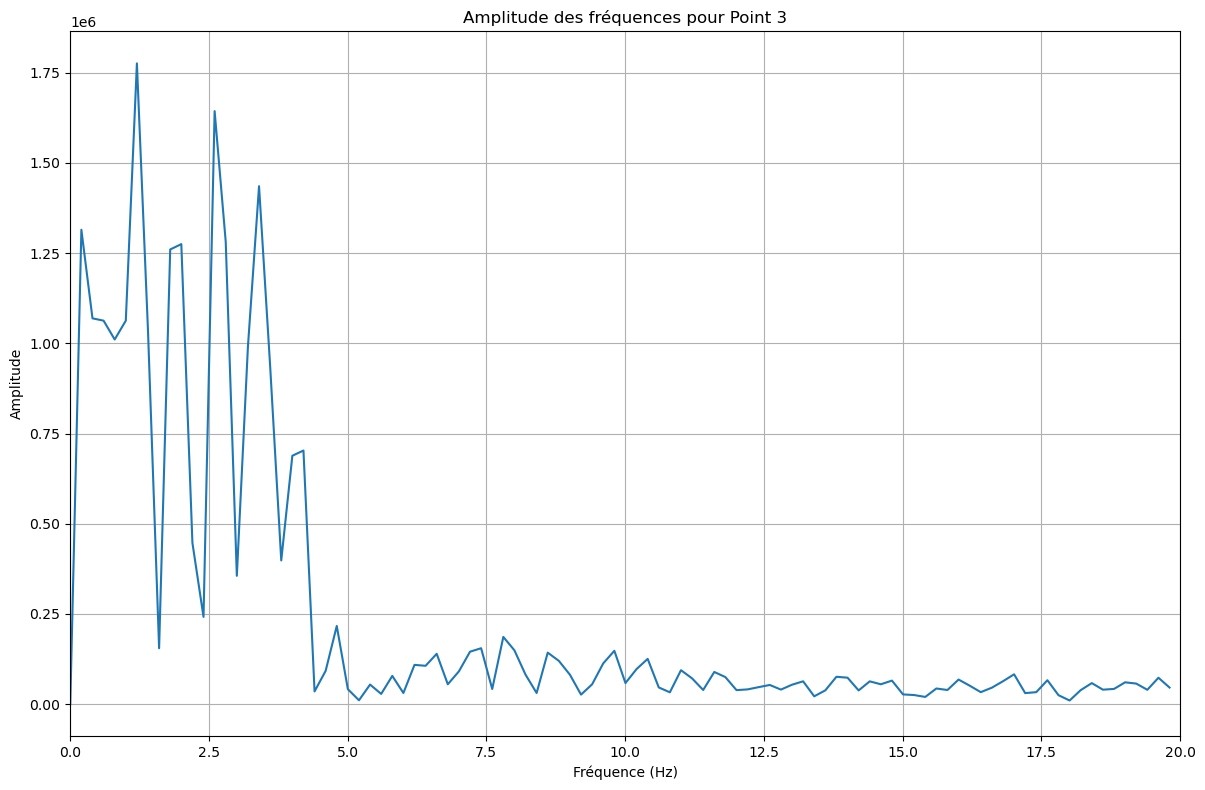

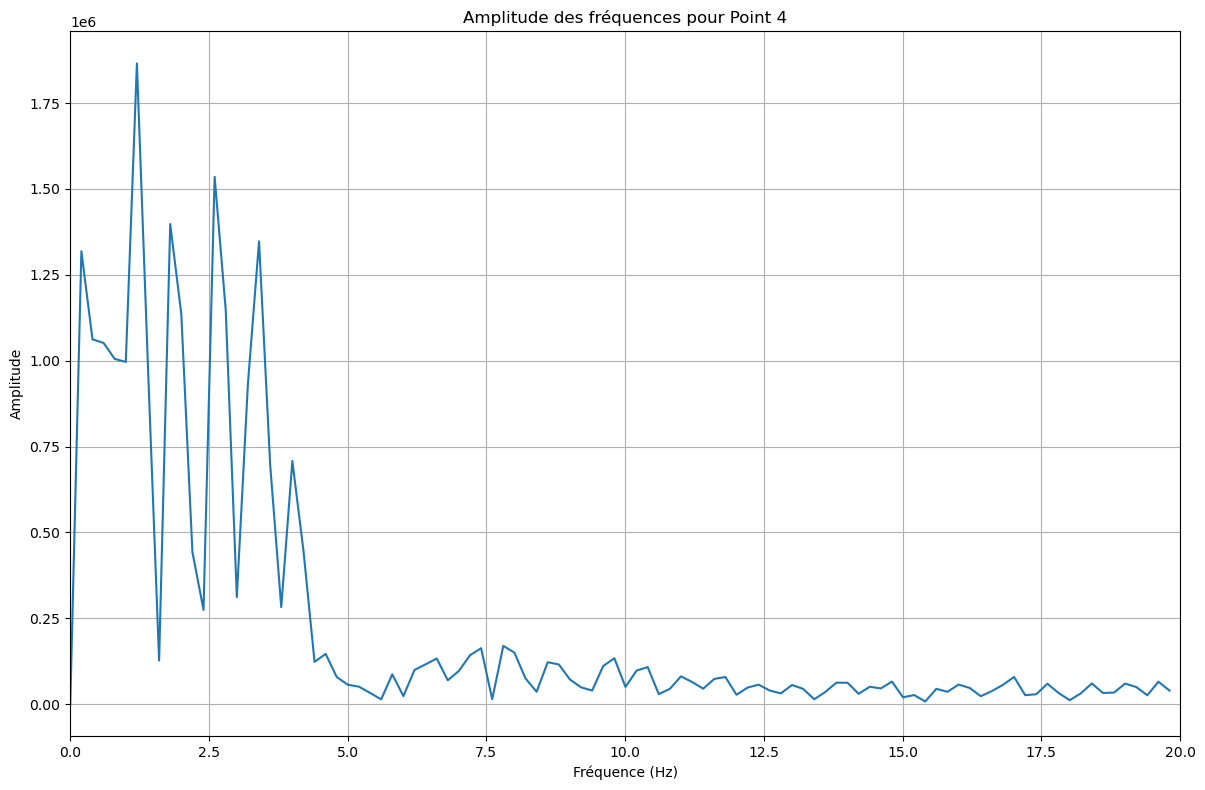

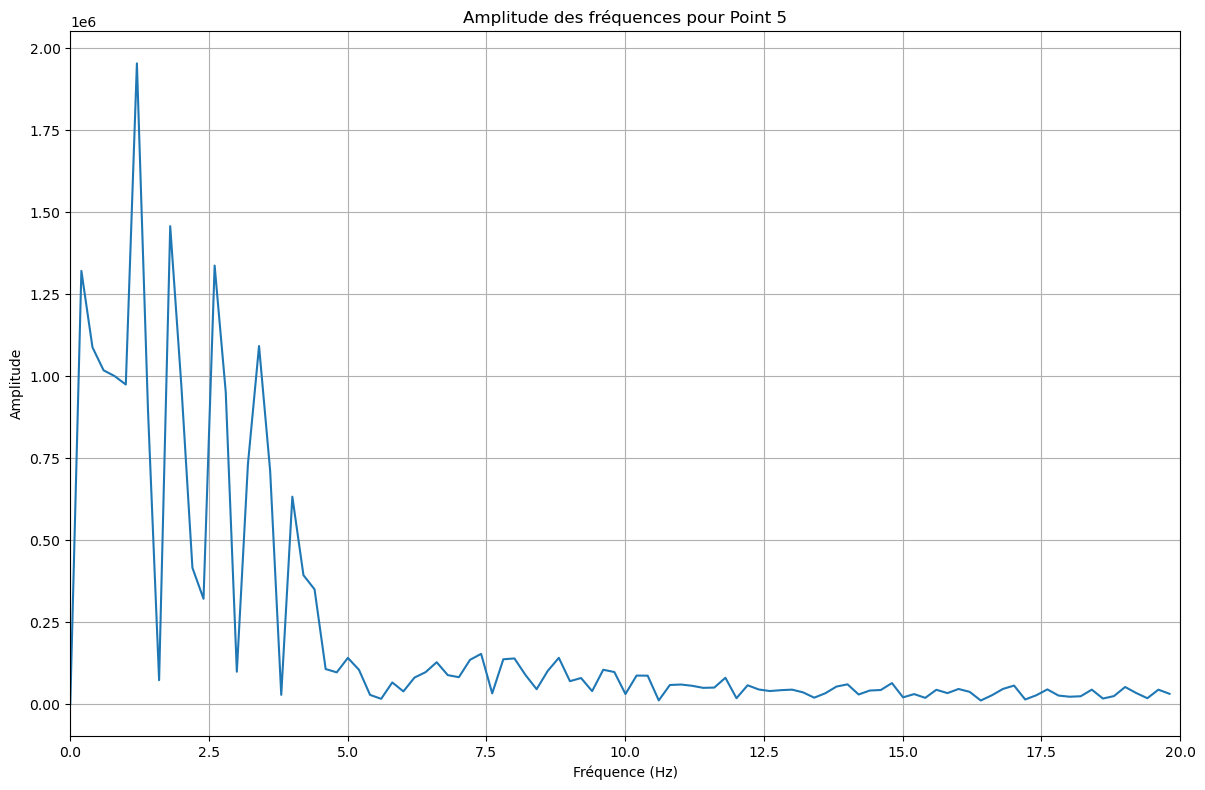

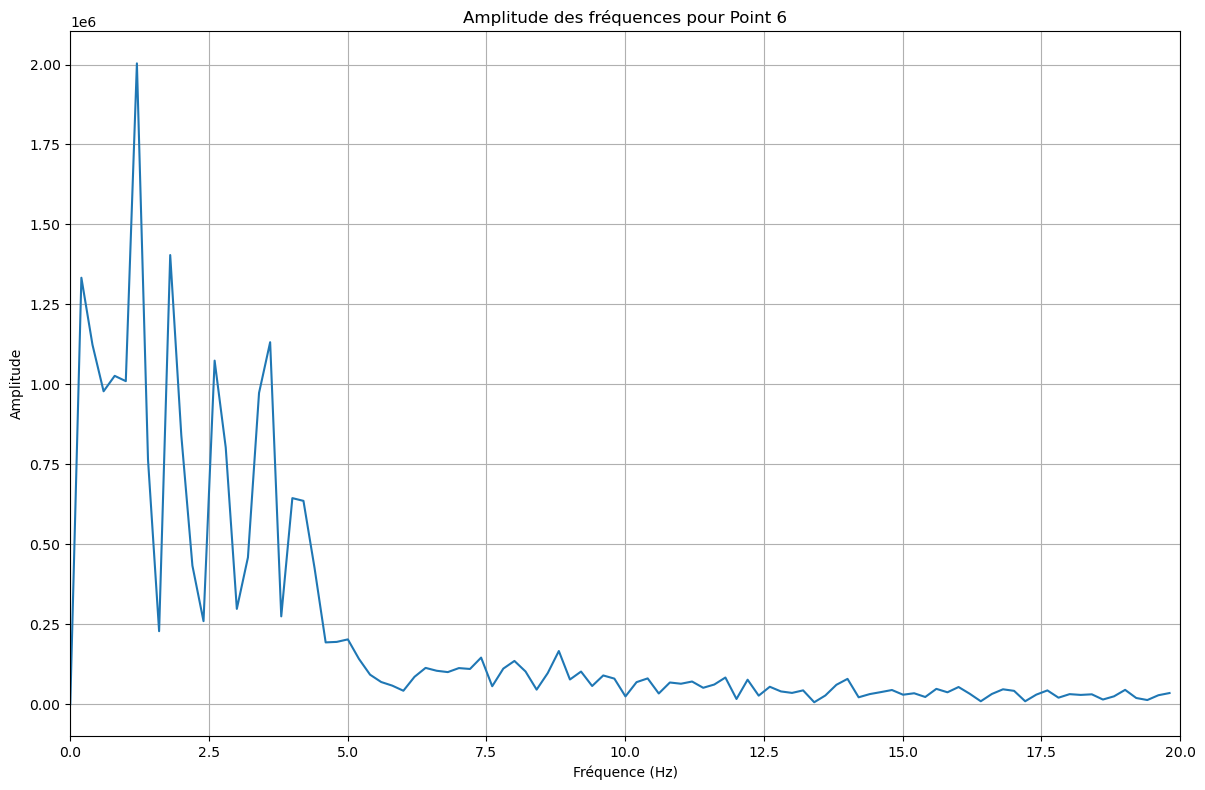

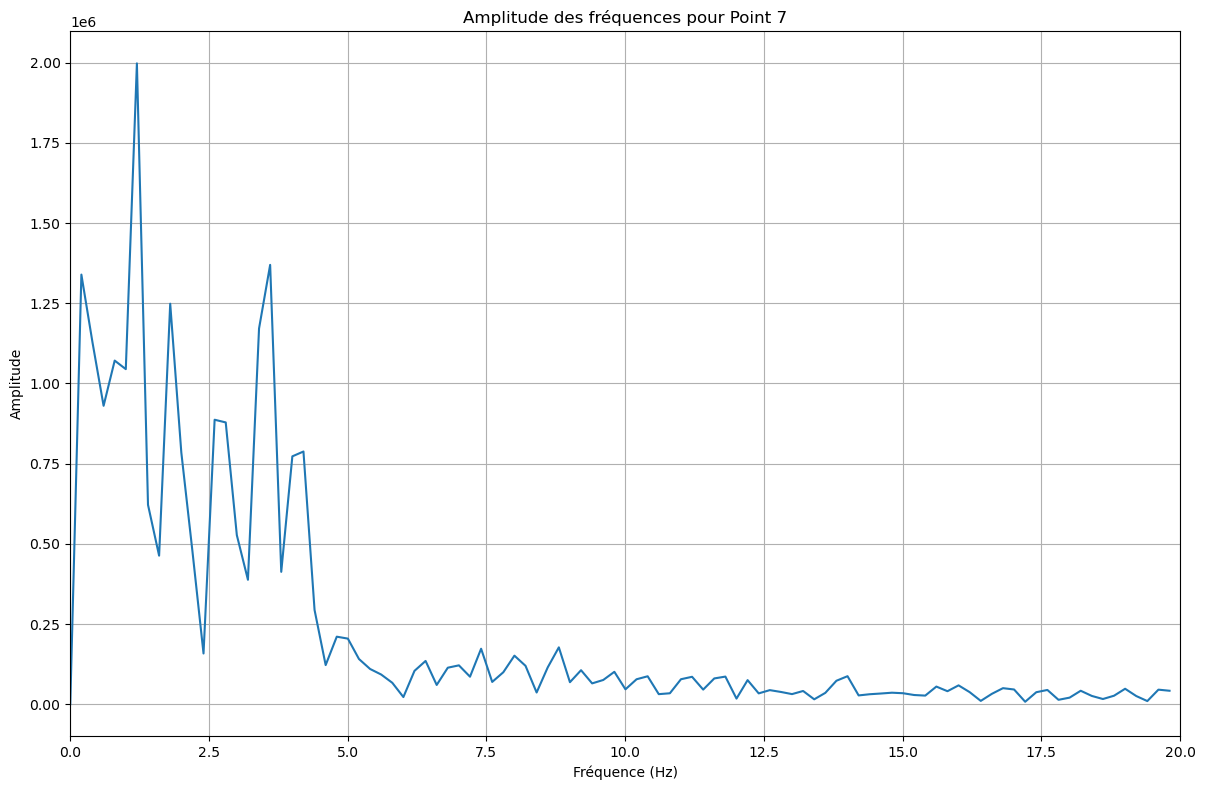

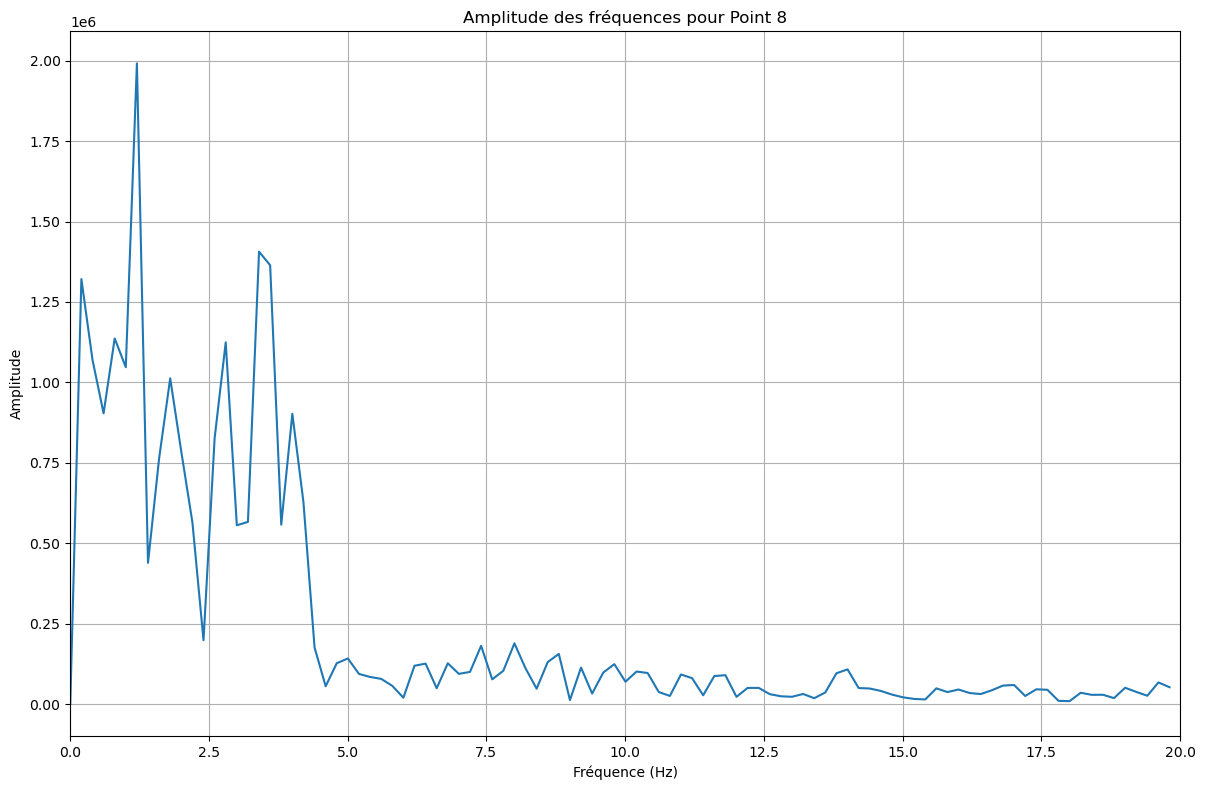

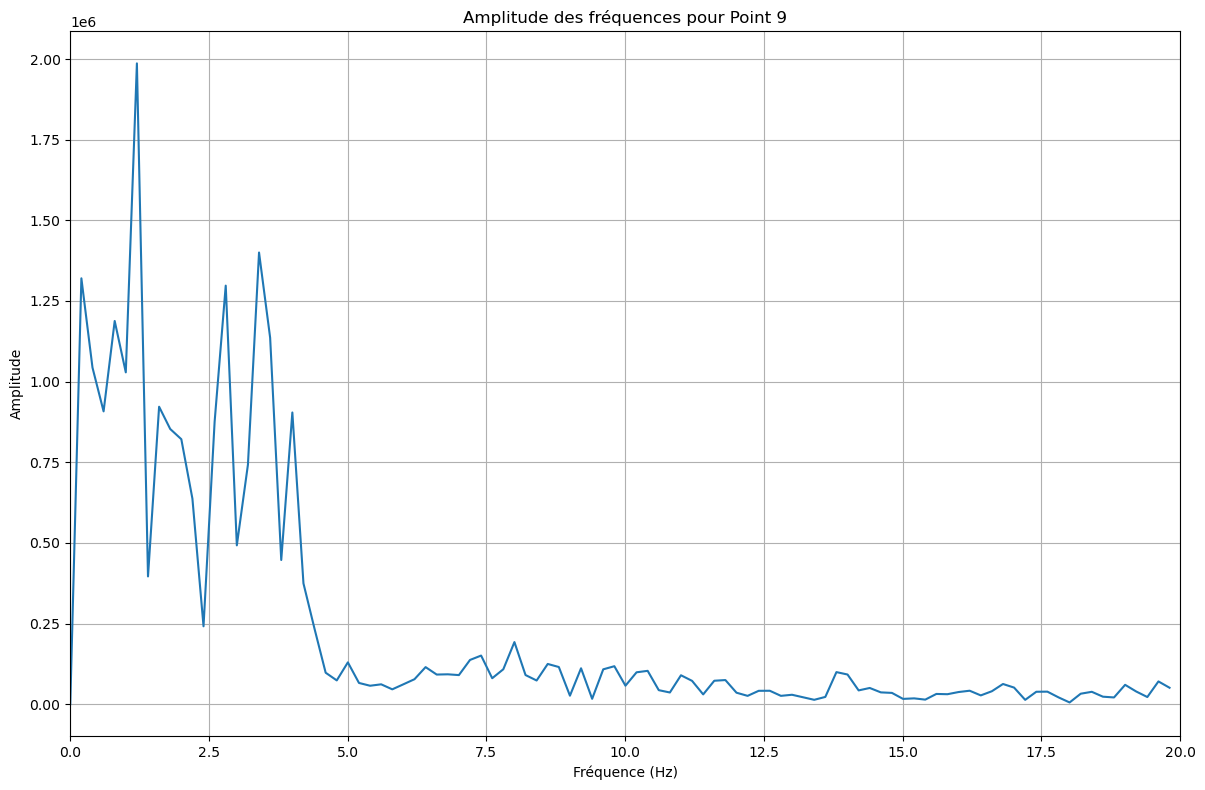

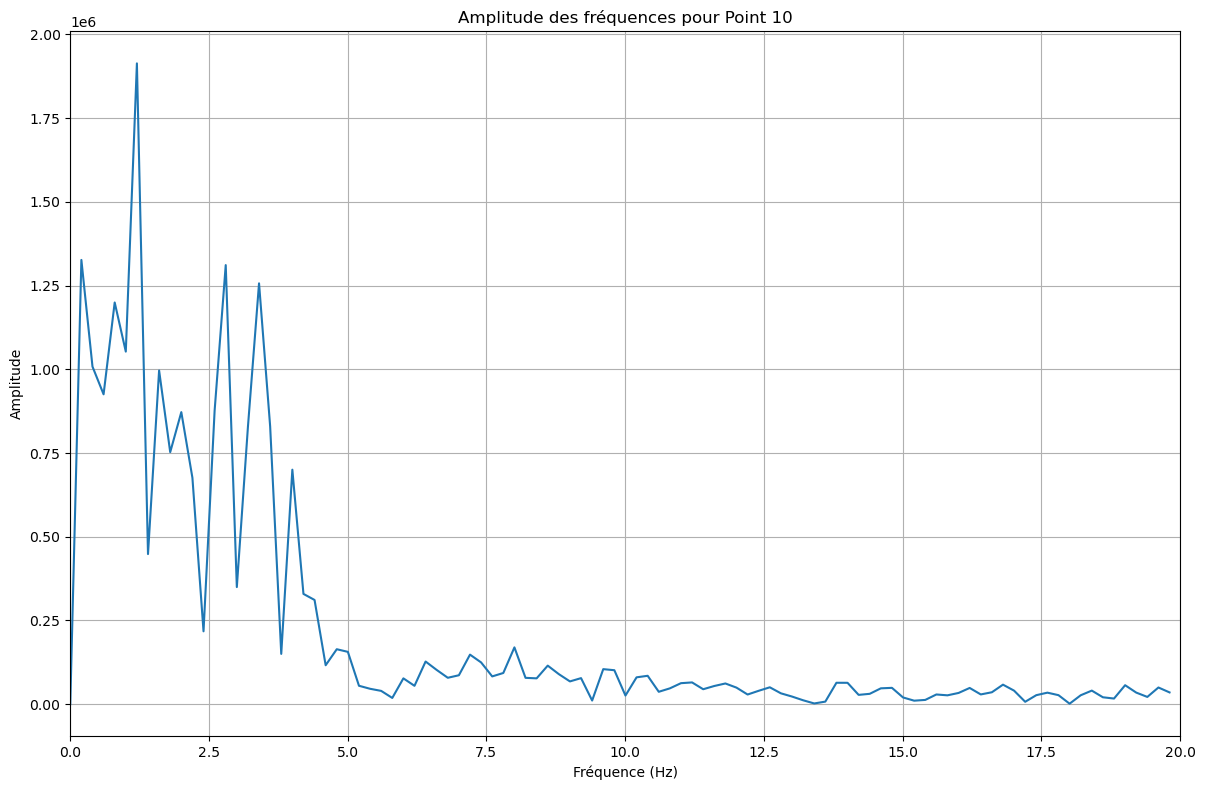

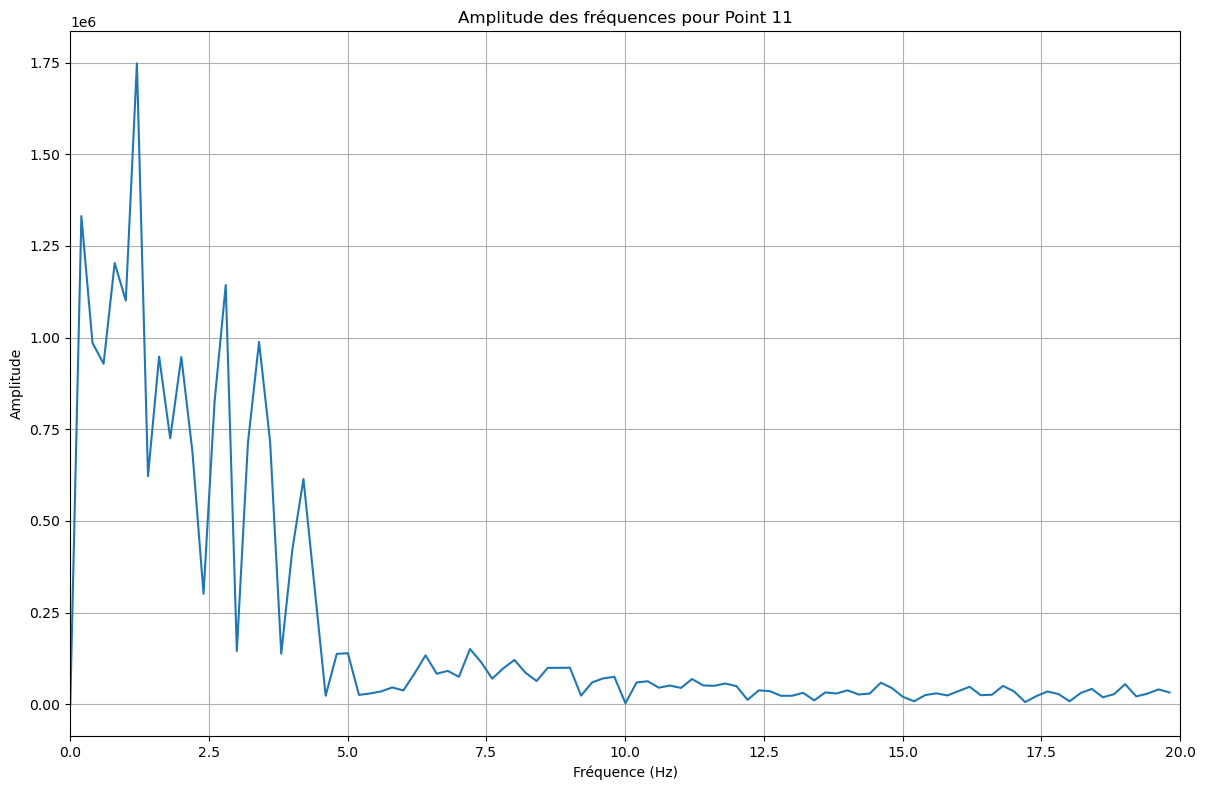

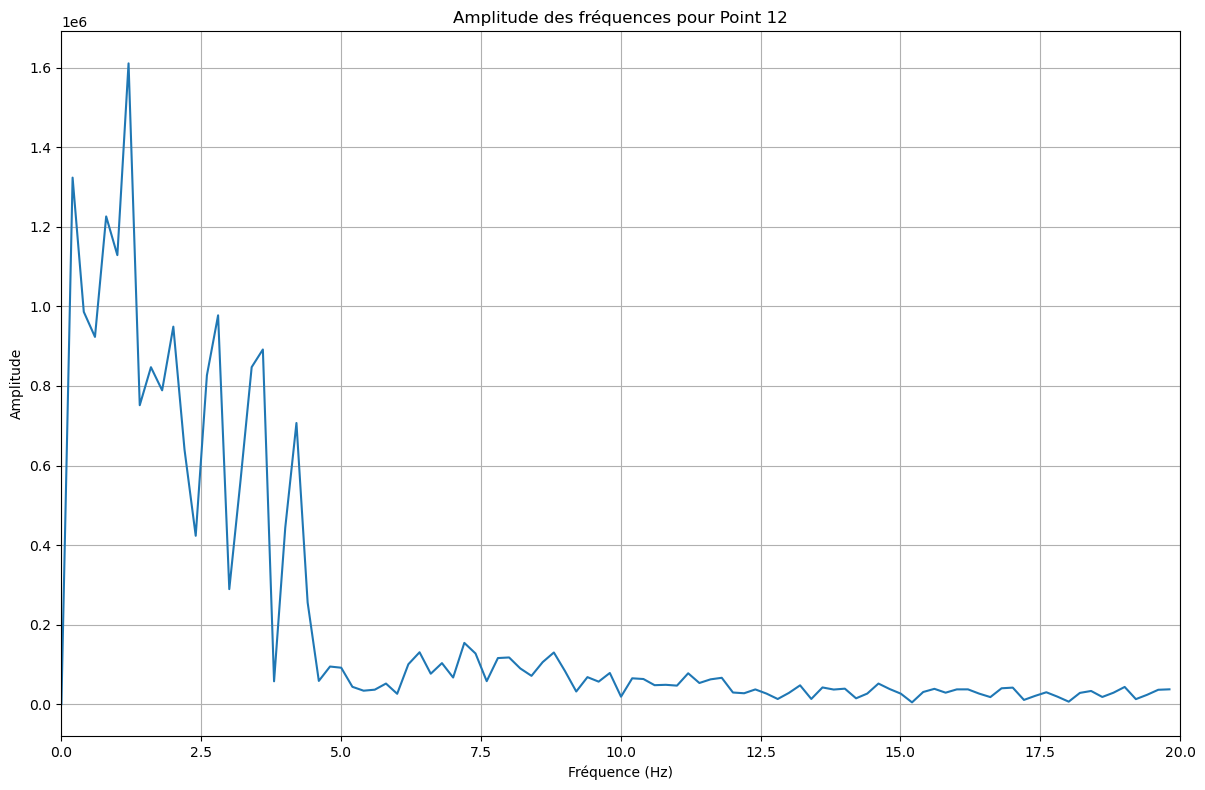

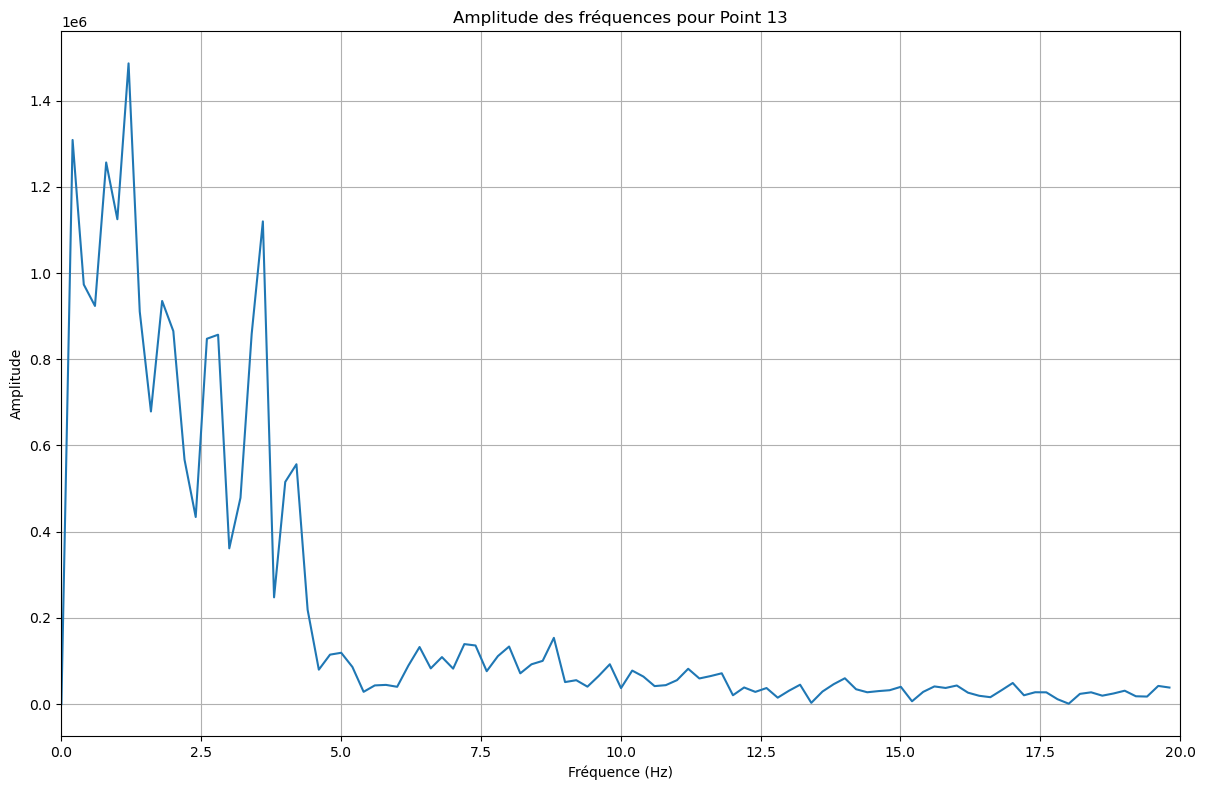

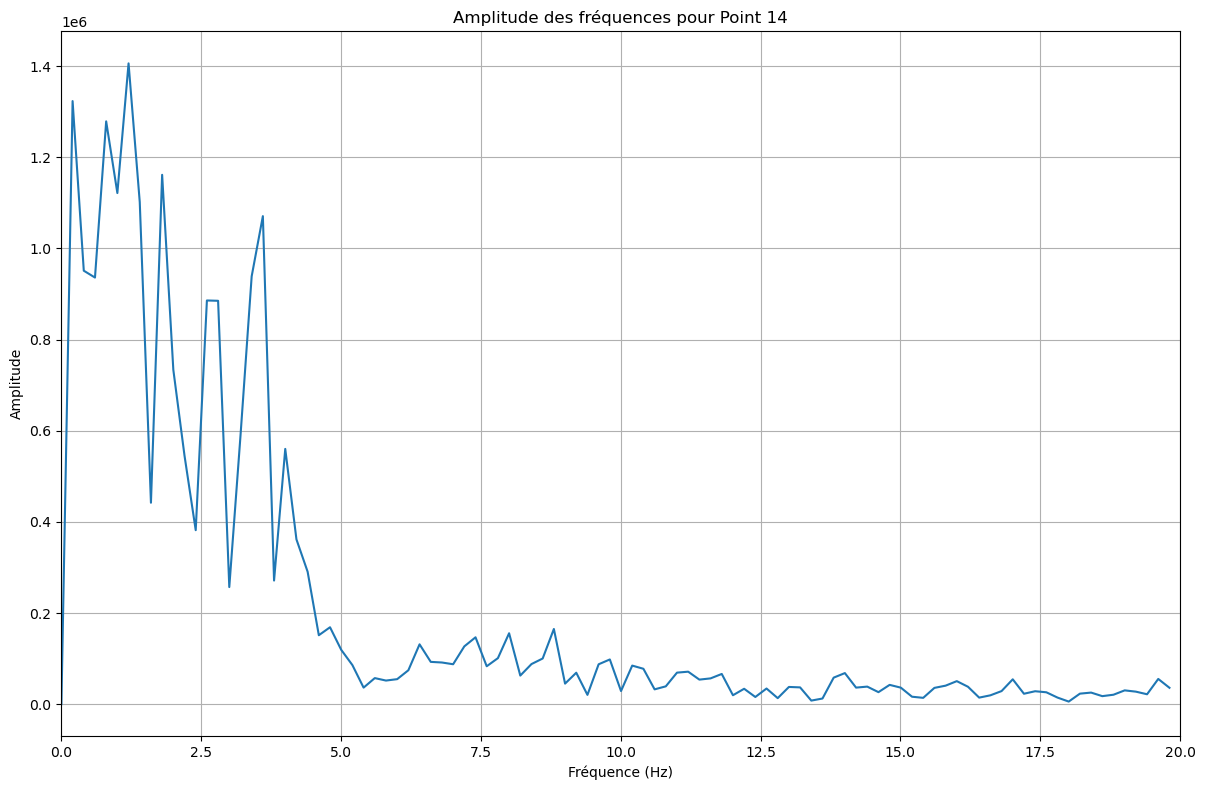

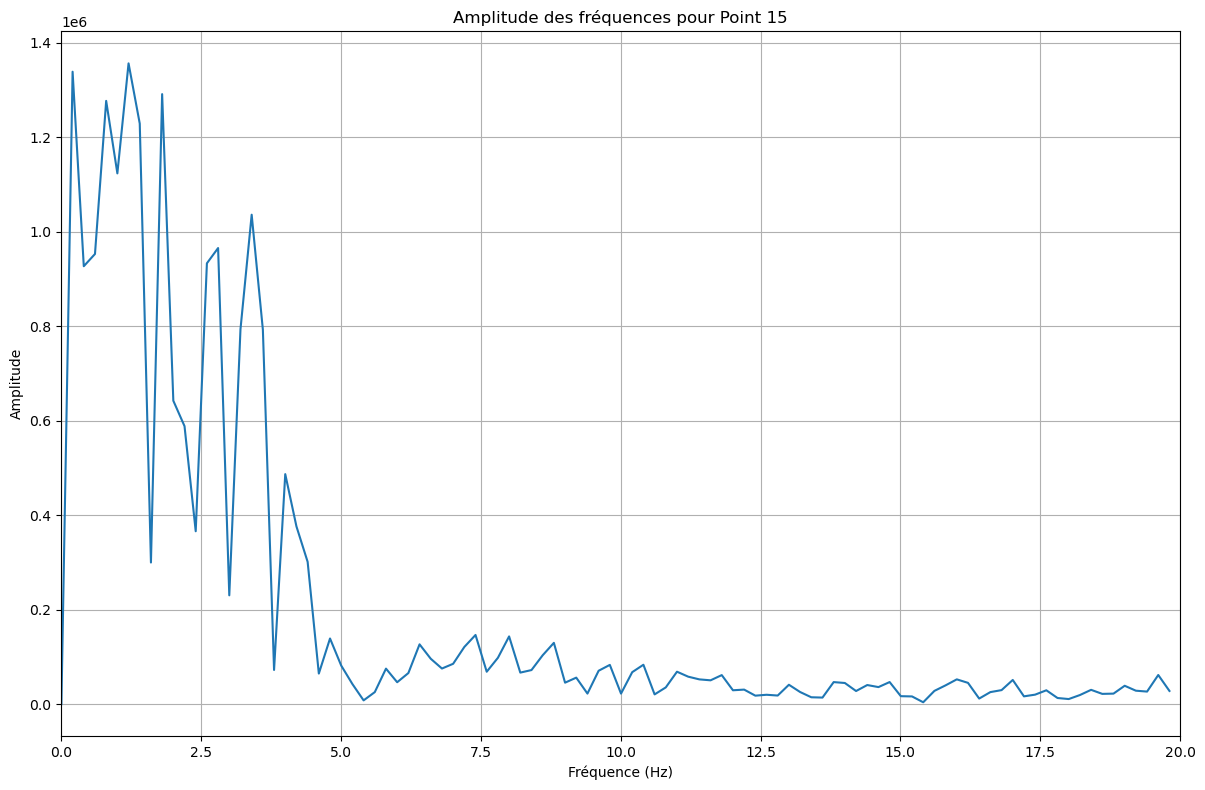

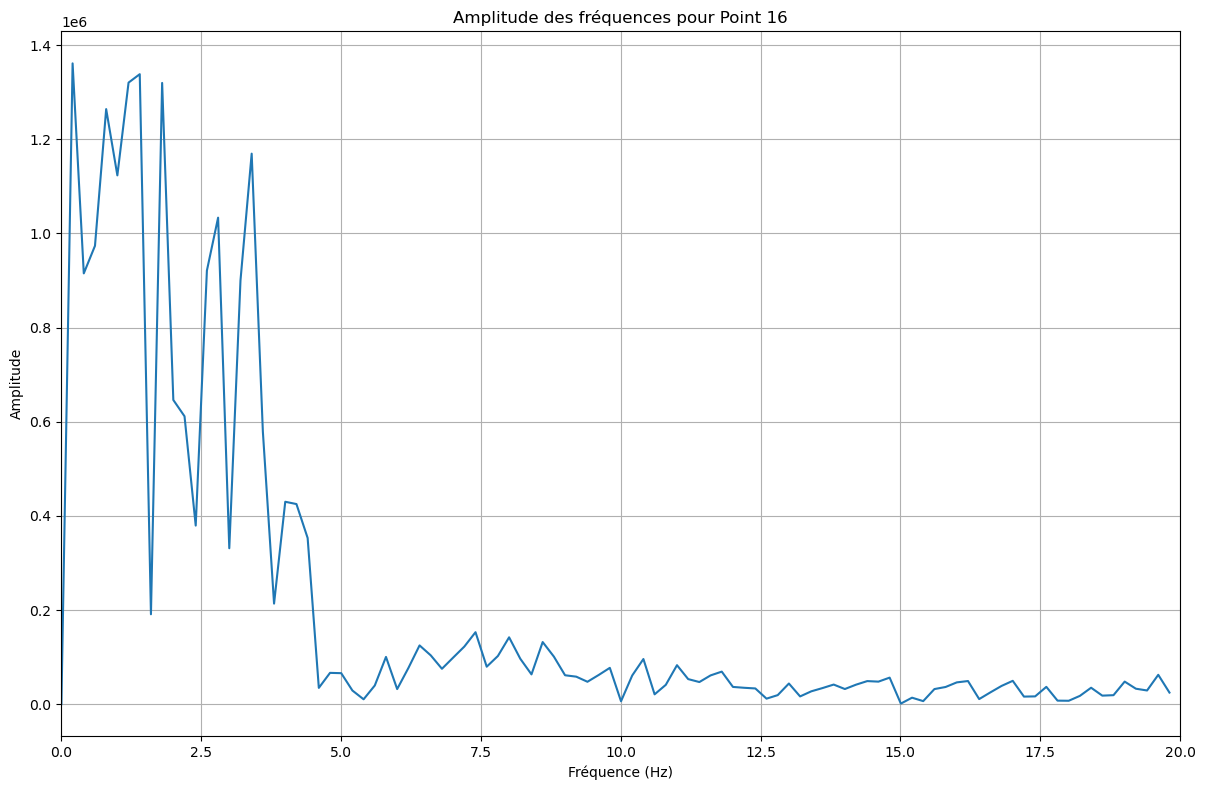

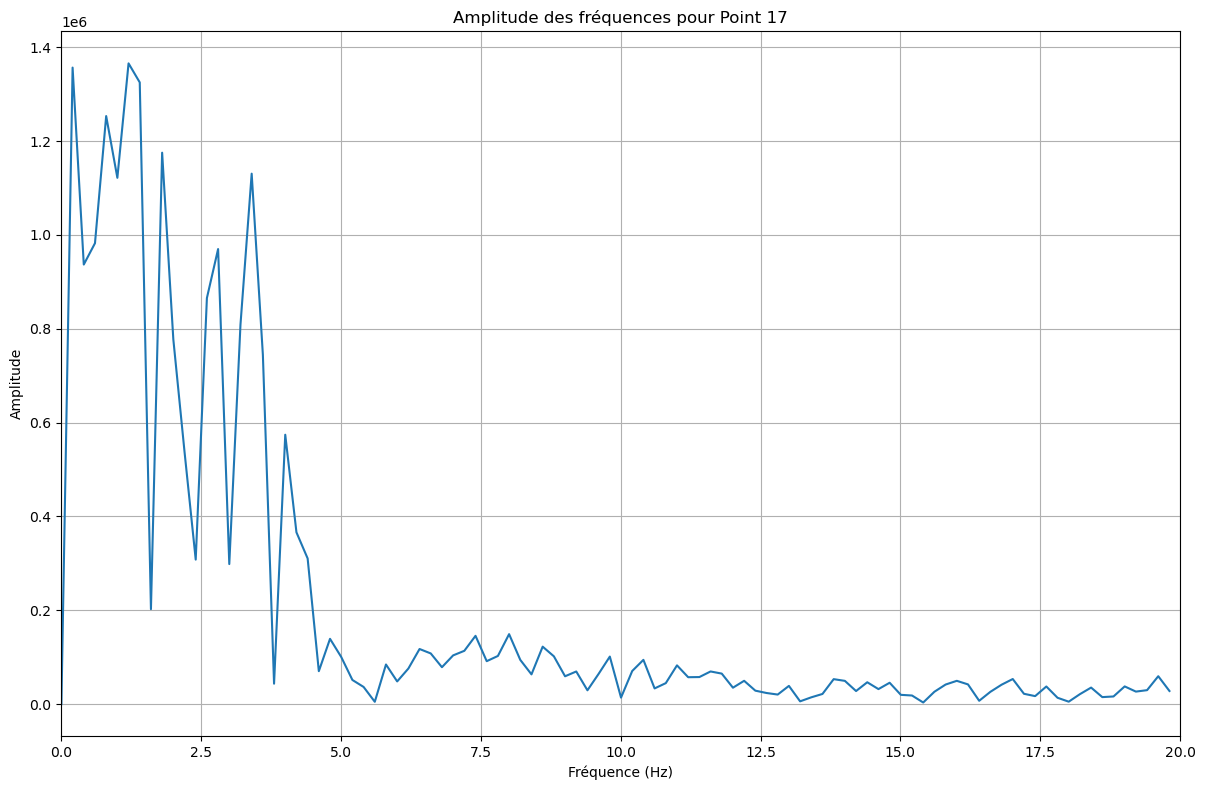

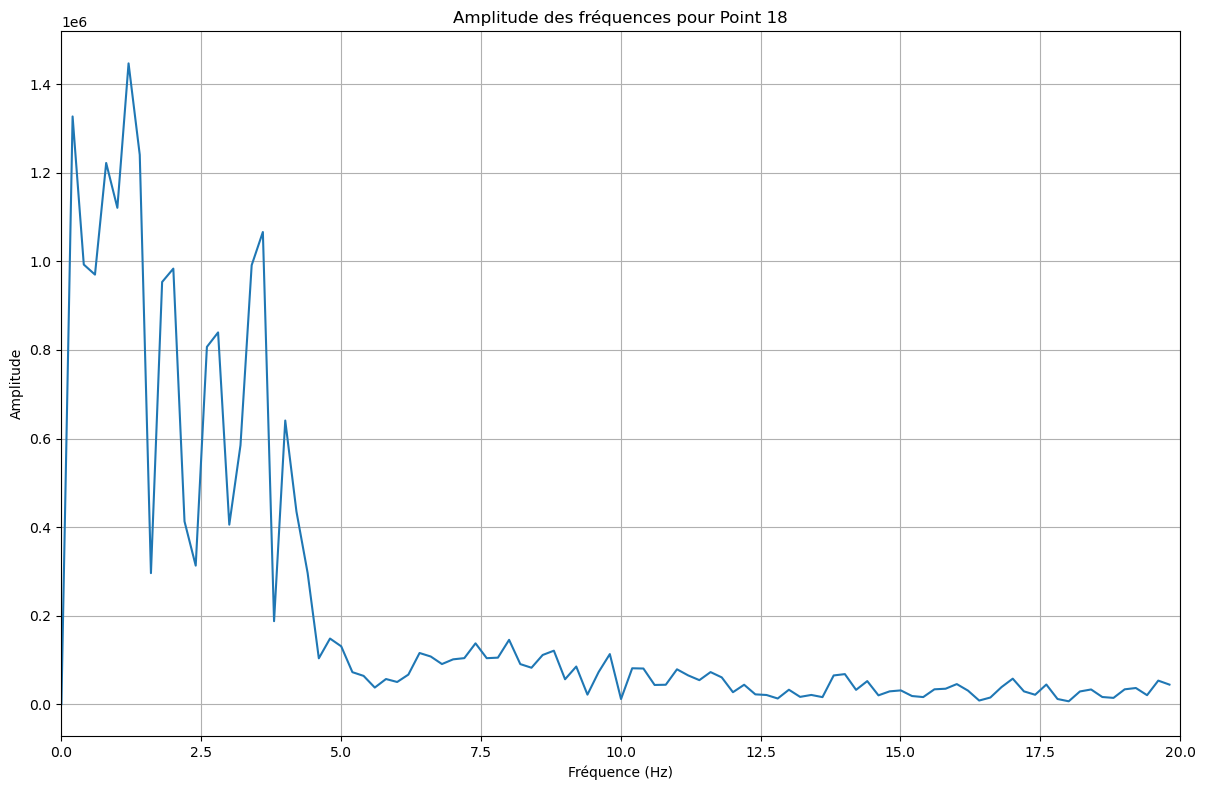

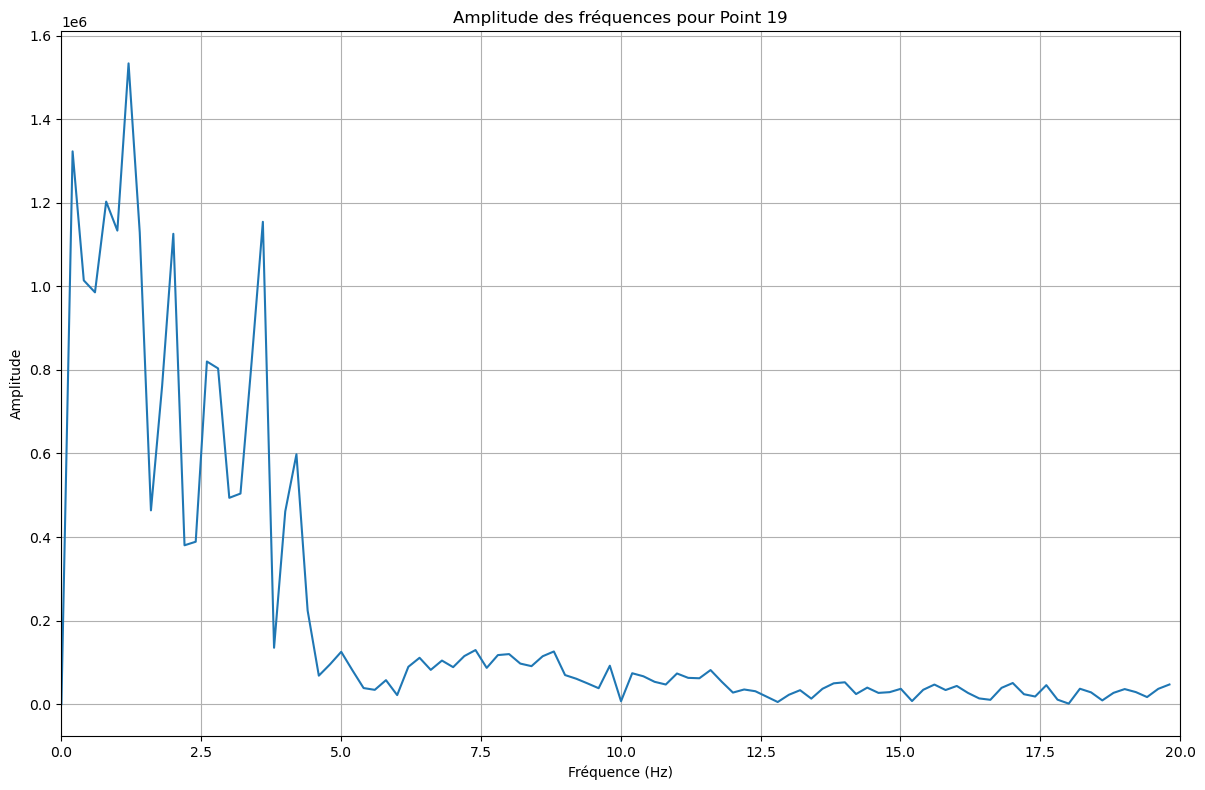

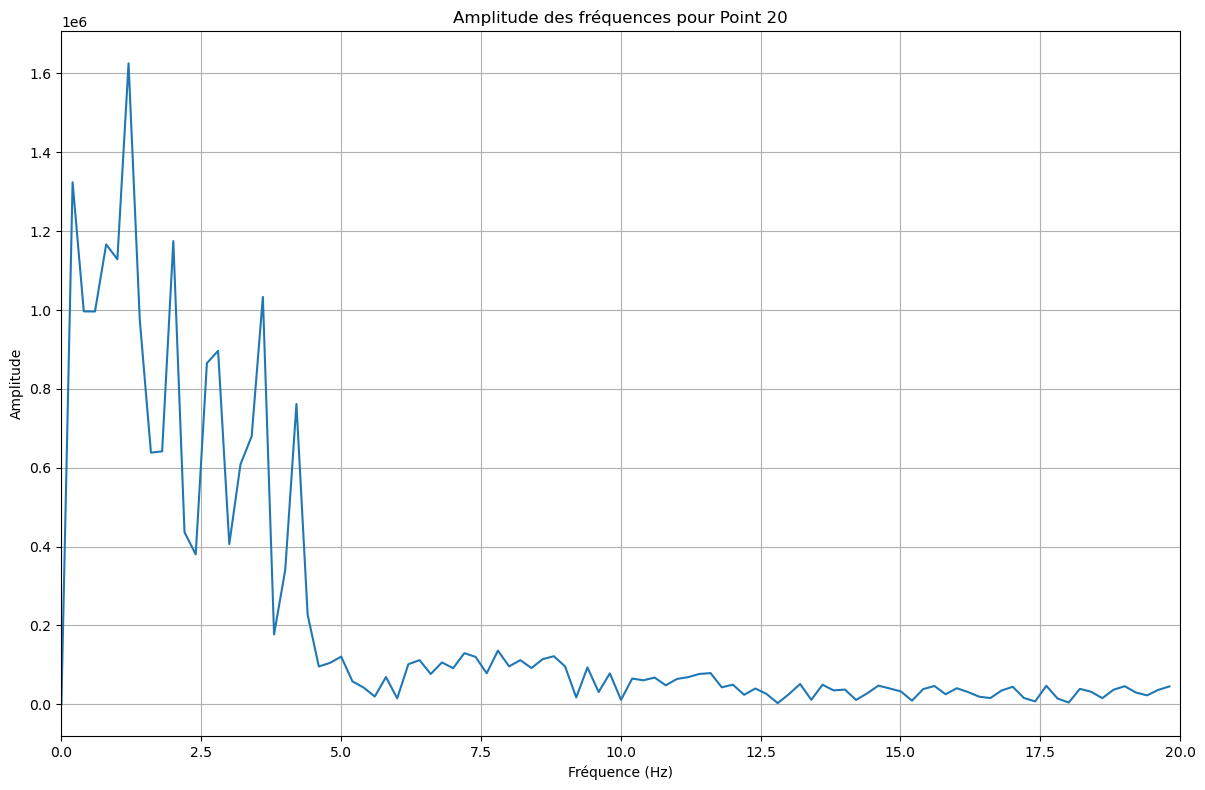

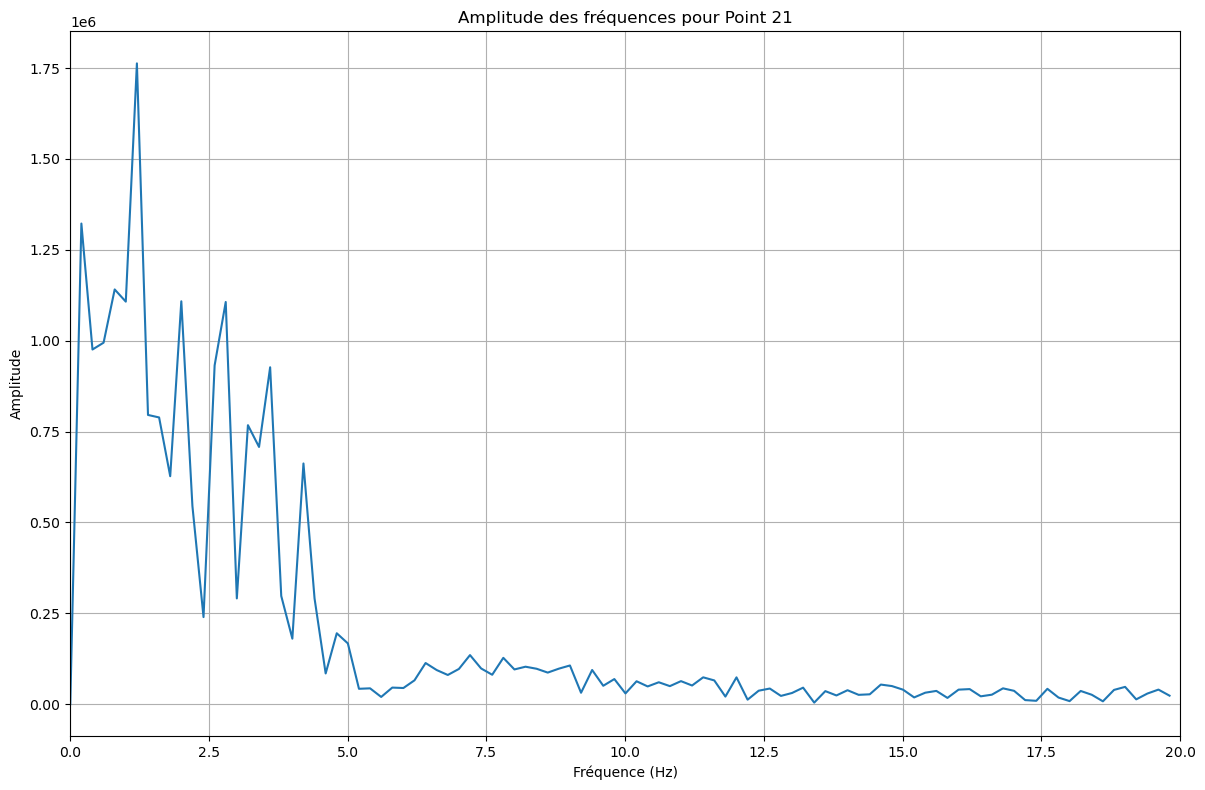

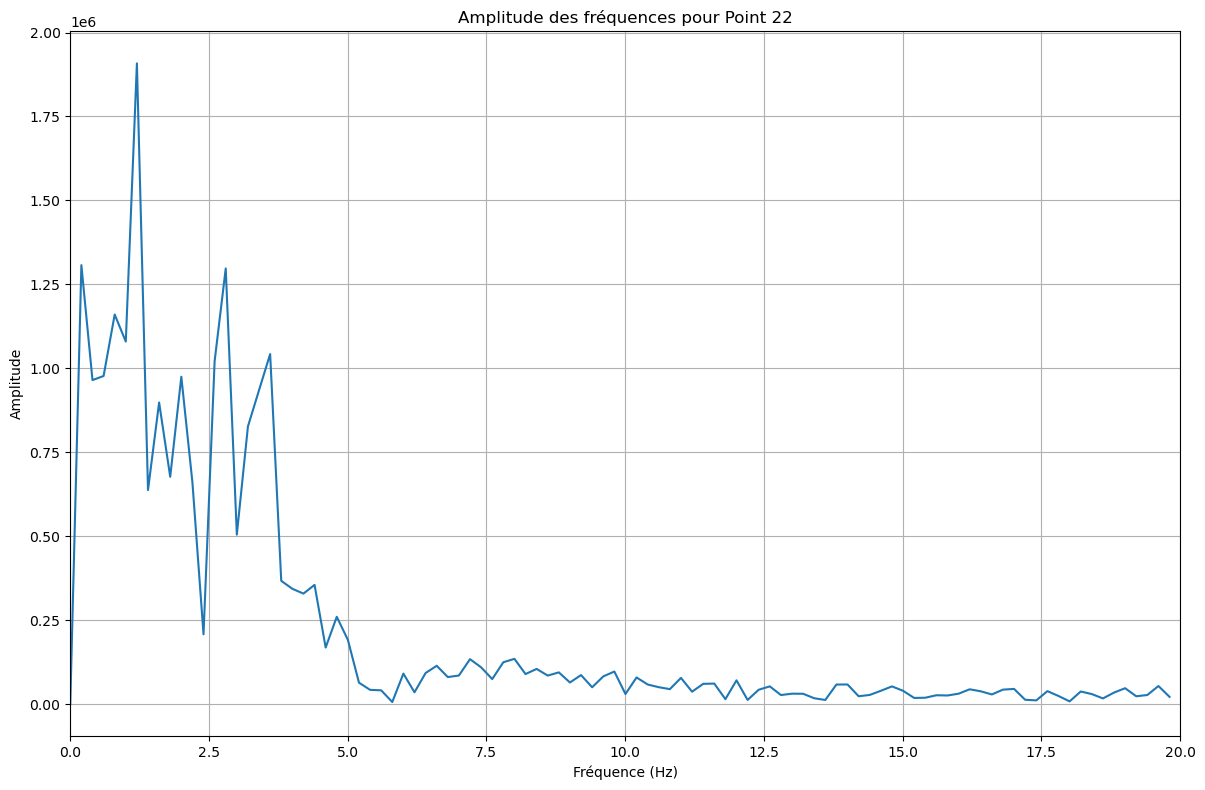

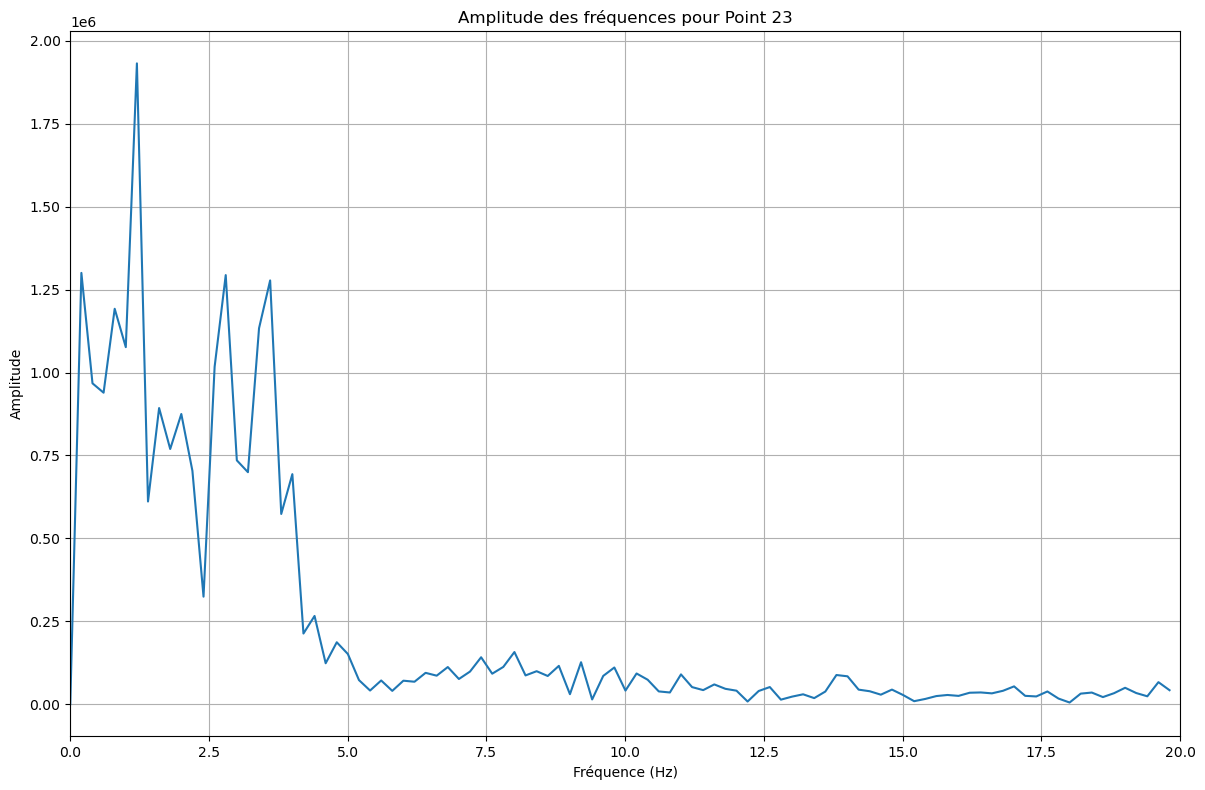

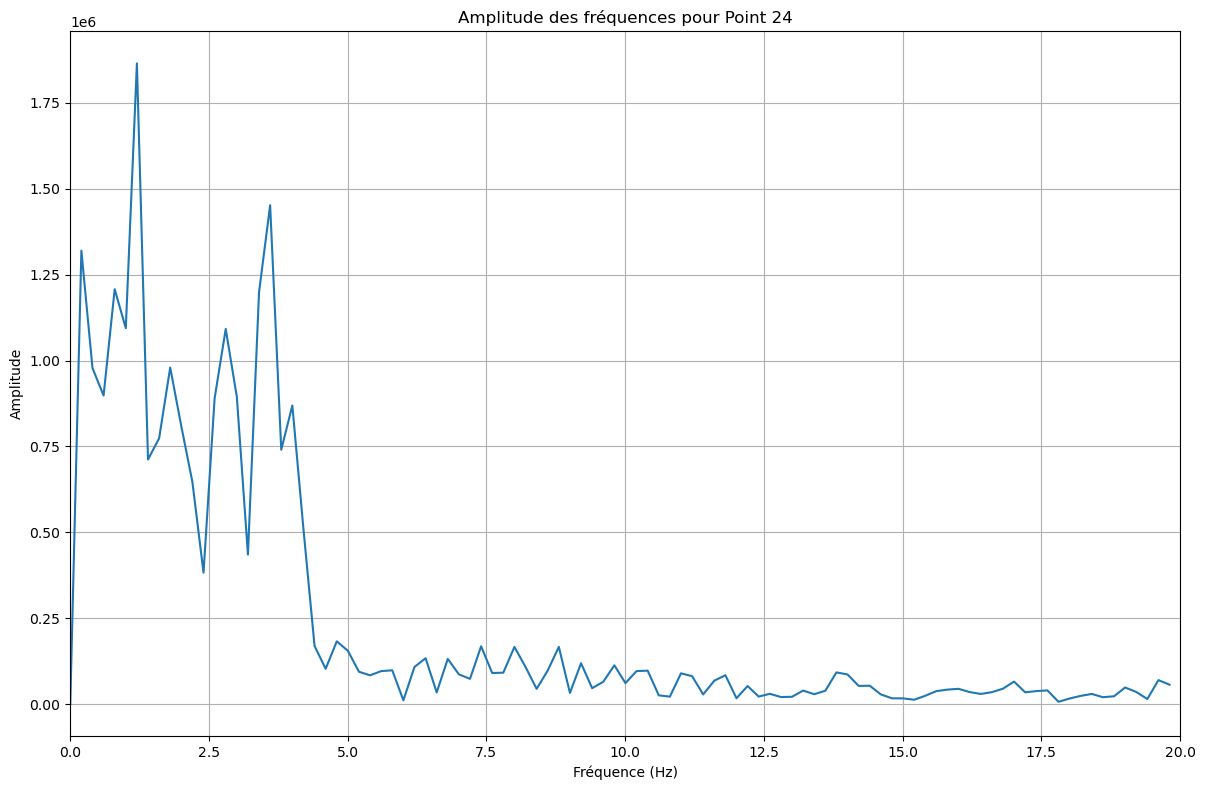

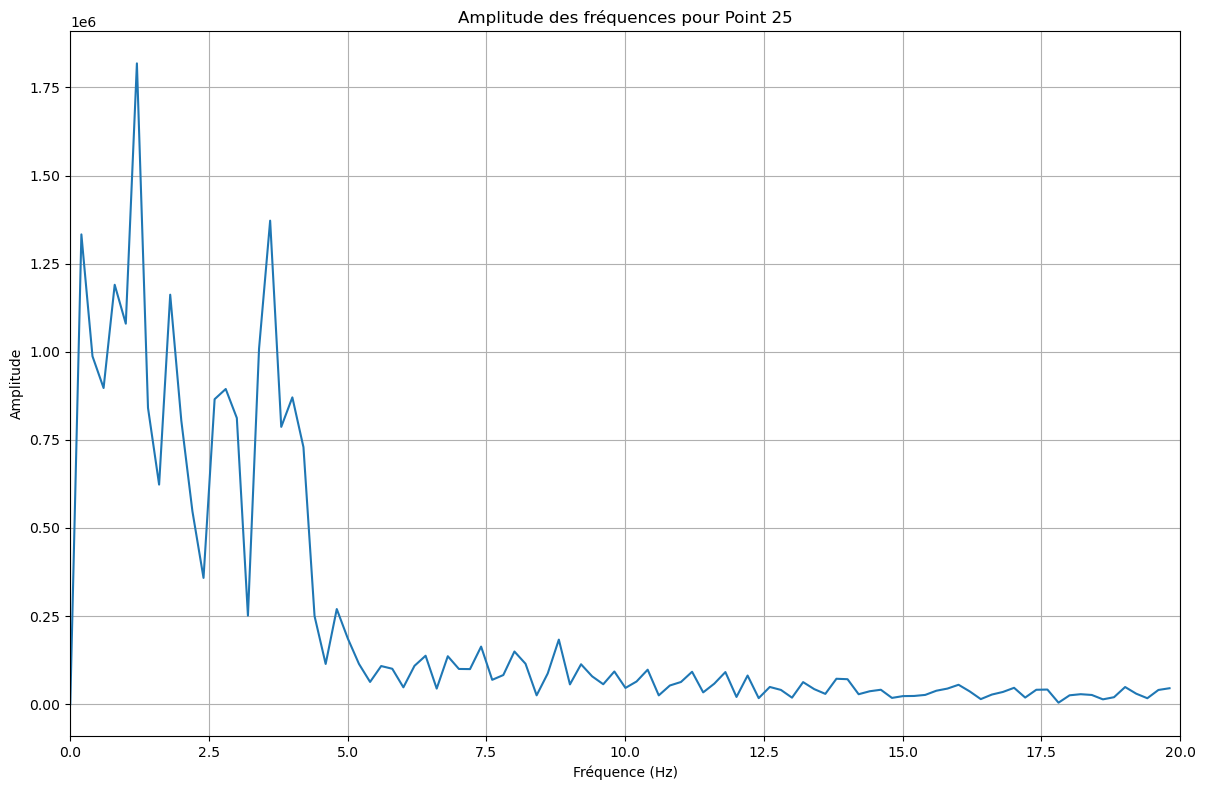

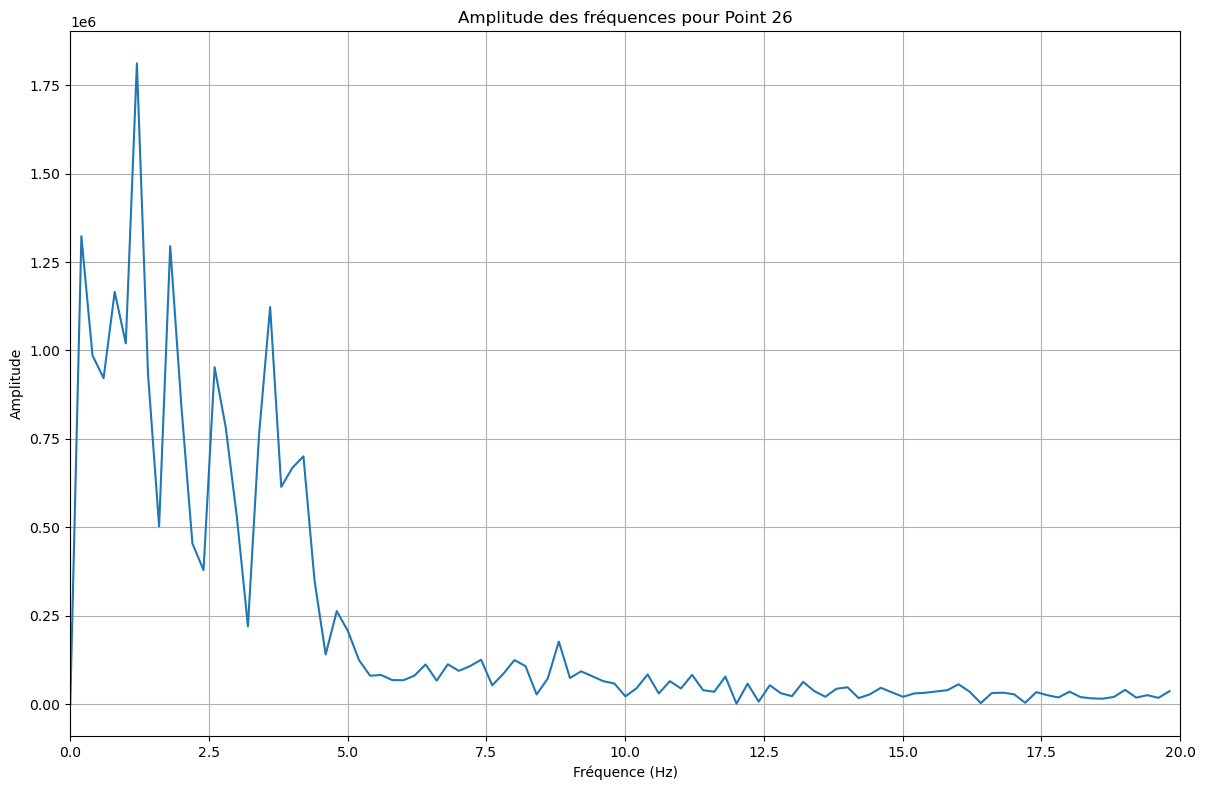

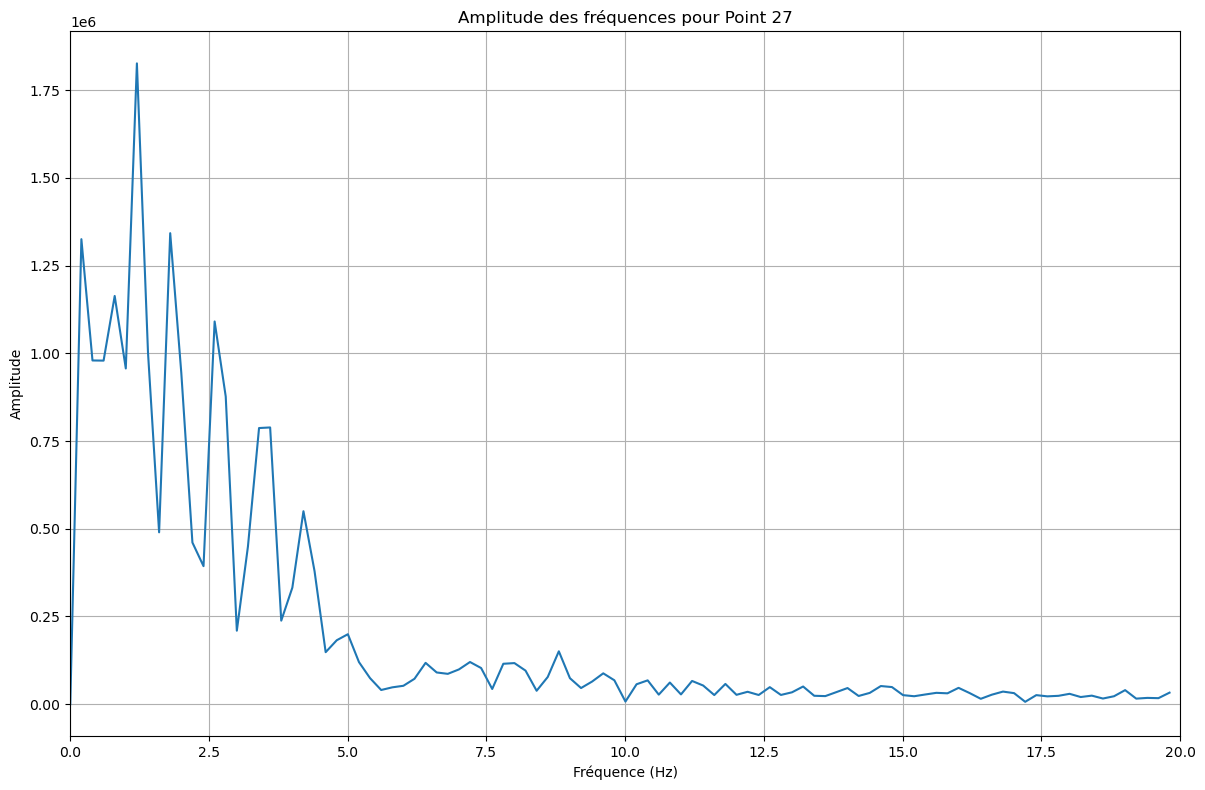

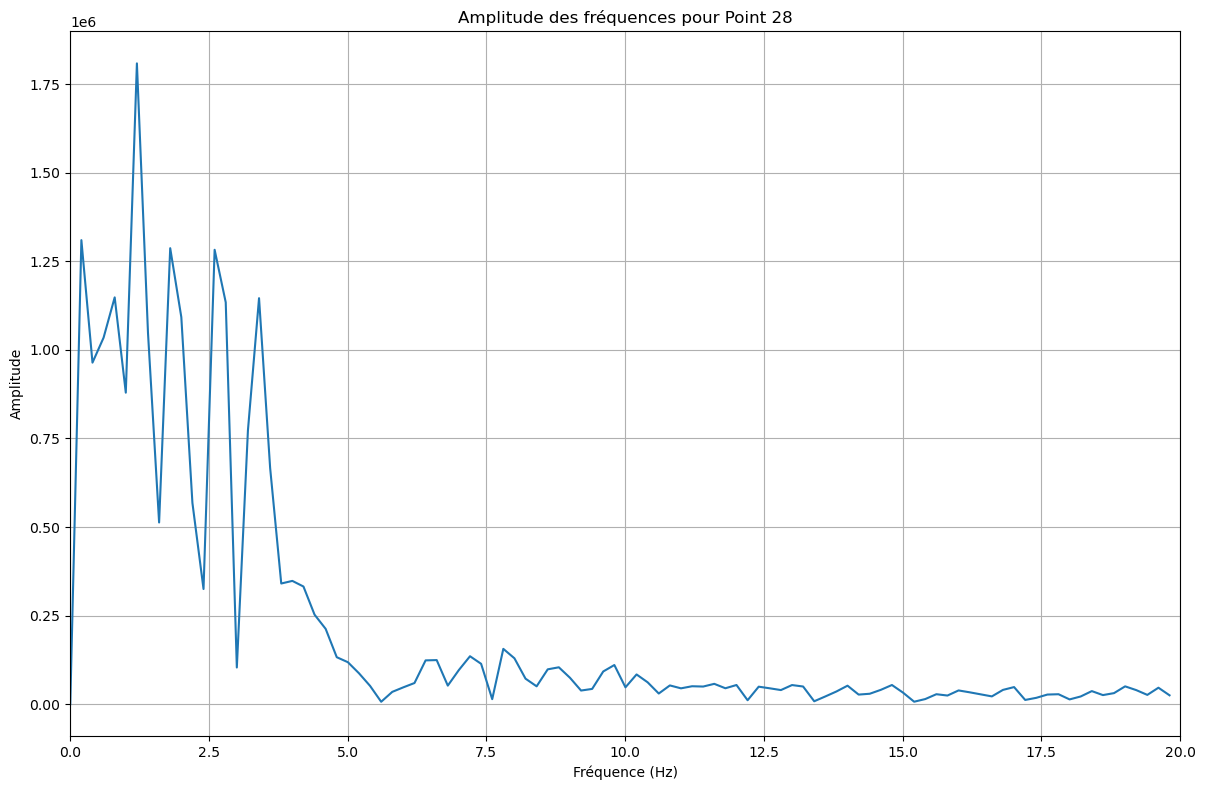

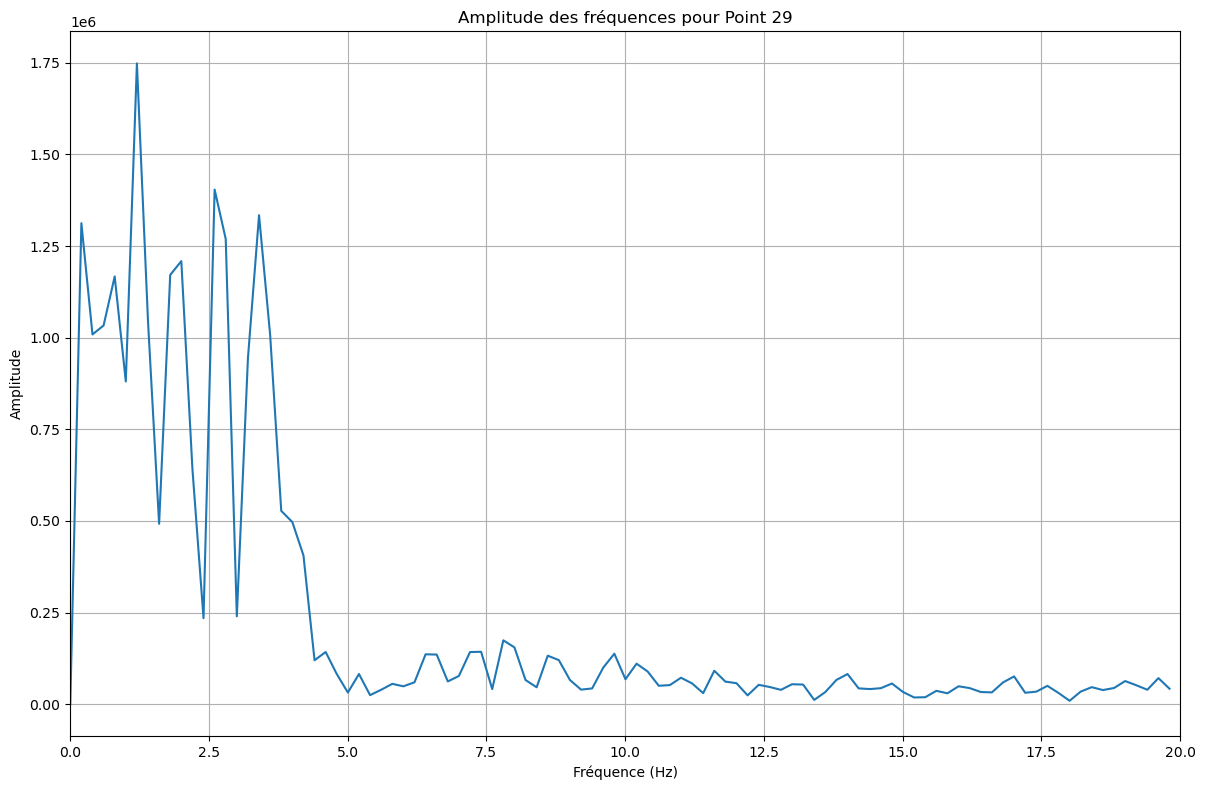

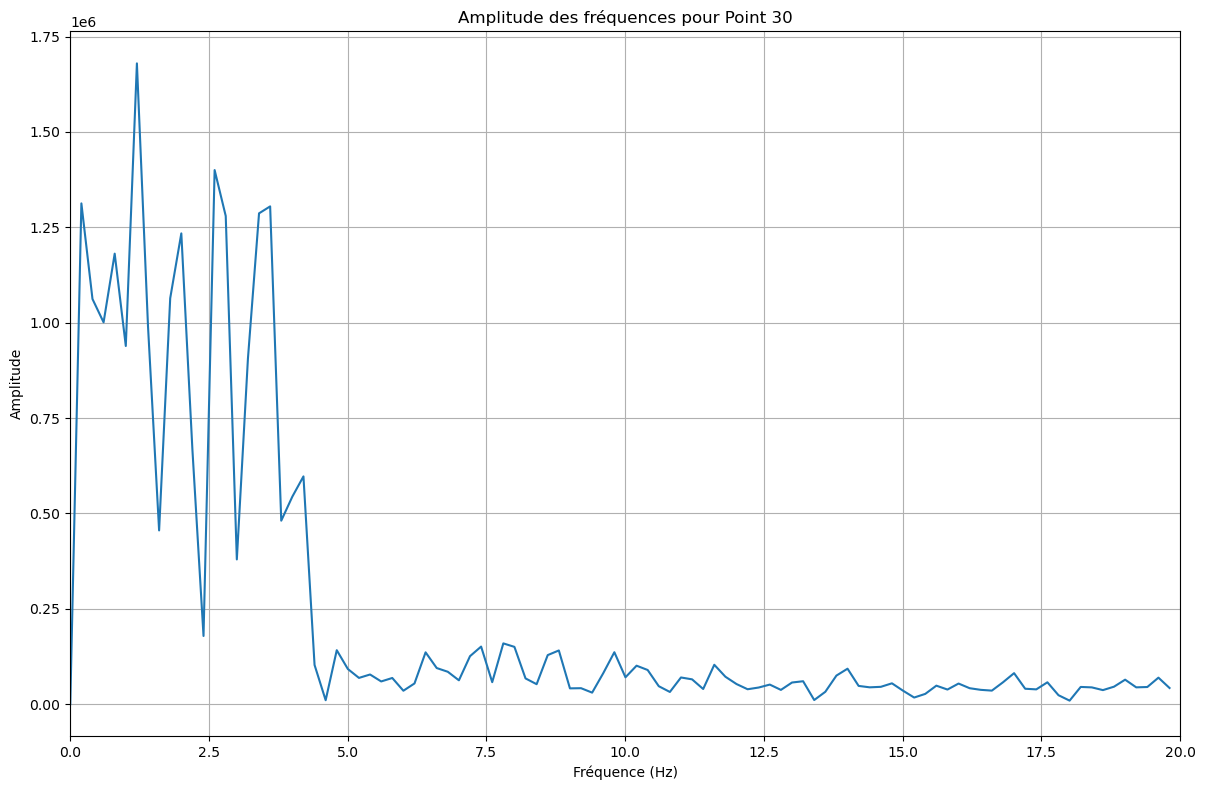

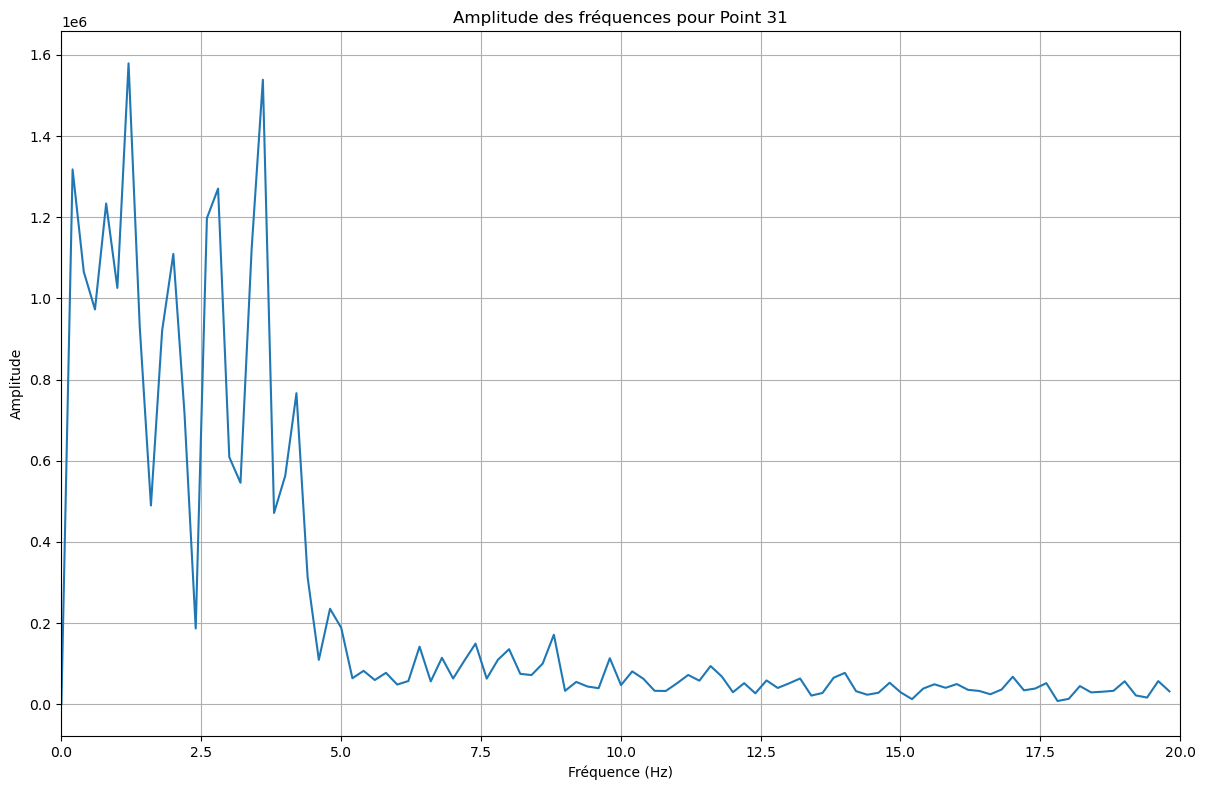

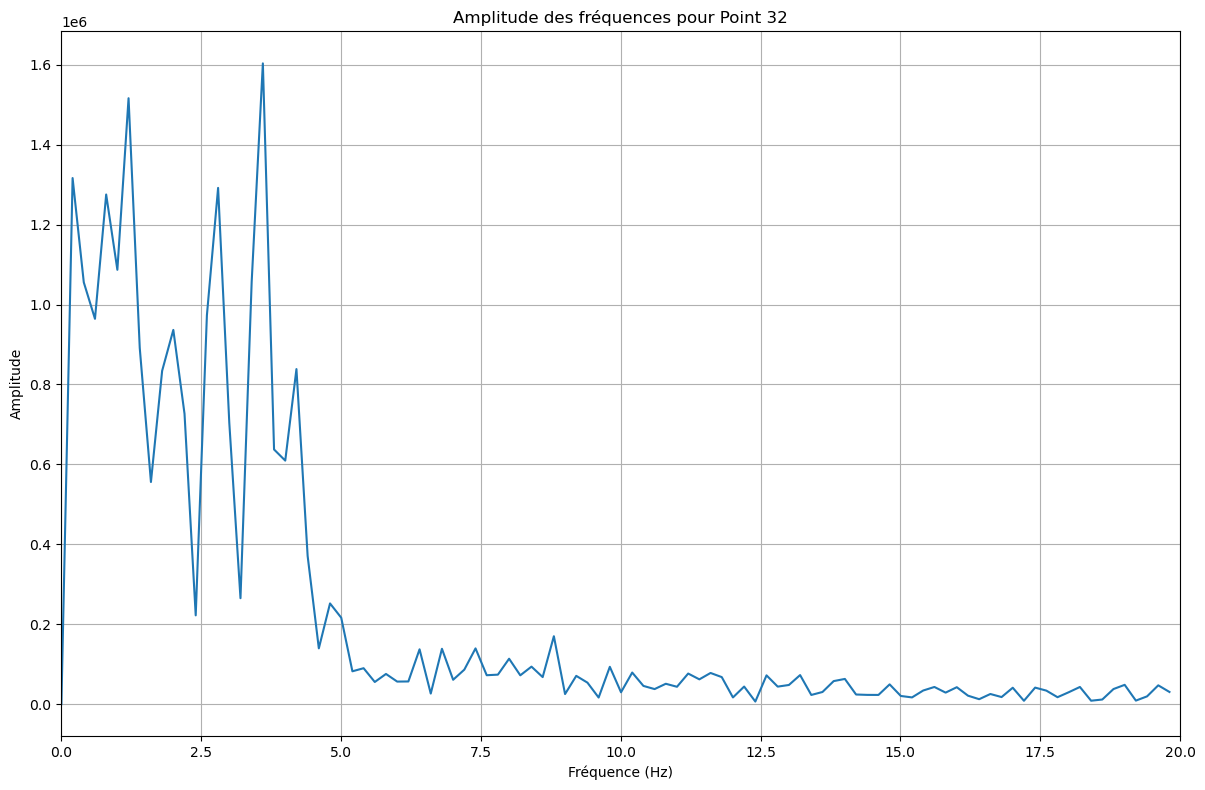

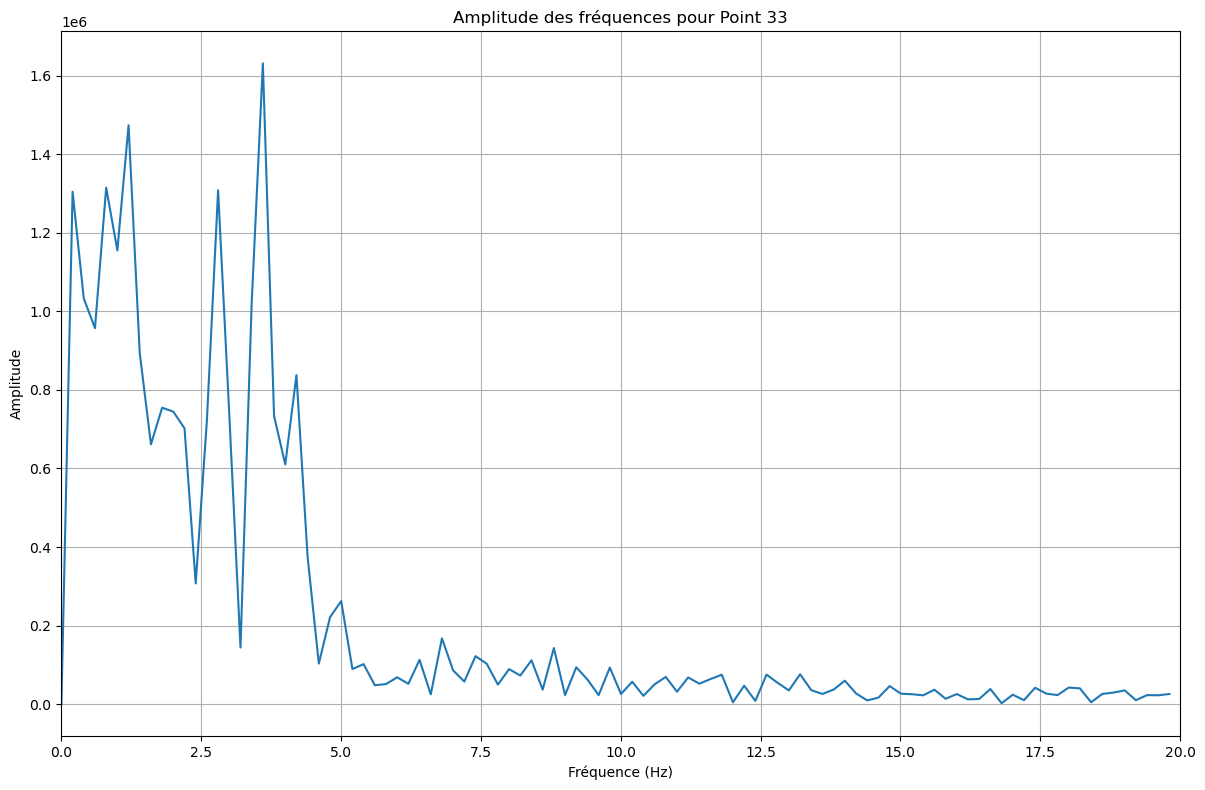

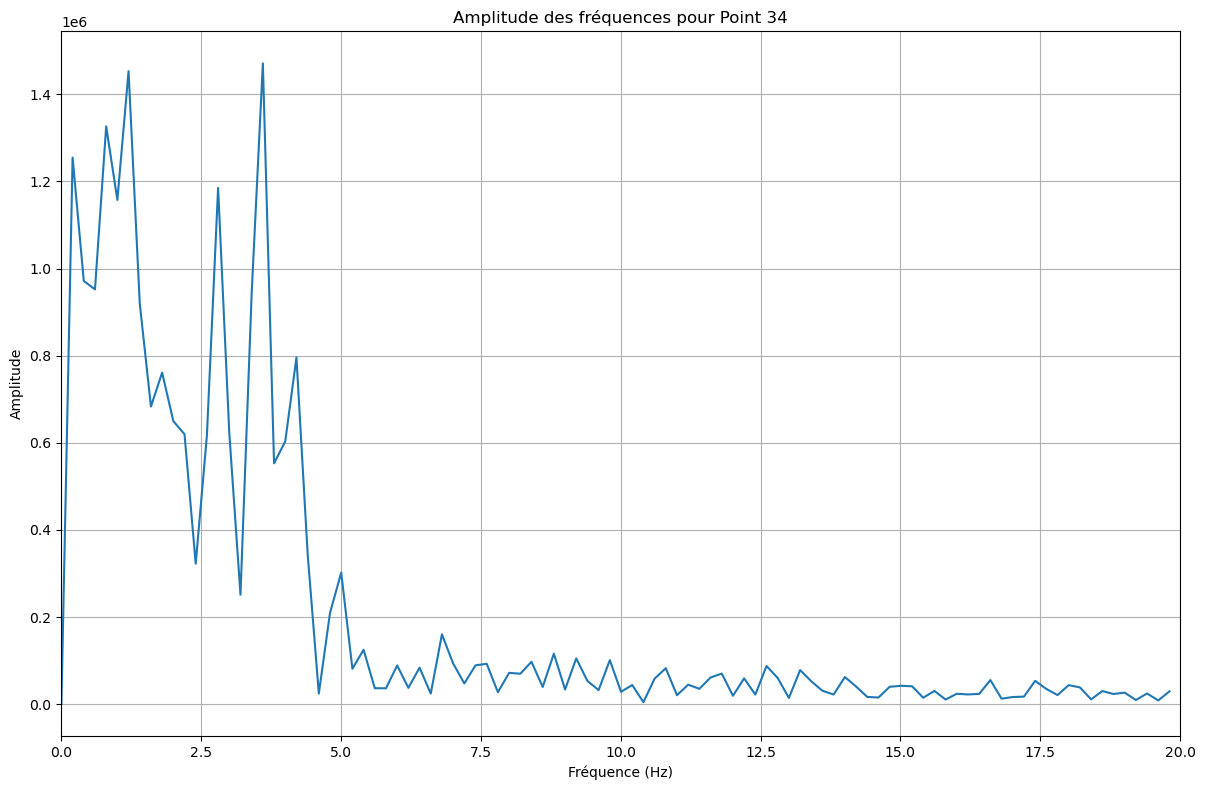

In [144]:
visualiser_matrice_fft_par_pointZOOM(fft_df_sans_dc)


In [267]:
##application de stft

In [269]:
# Obtenir les paramètres de l'utilisateur pour la STFT
fs, windowing, nperseg = get_user_input_2()

# Appliquer la STFT avec les paramètres de l'utilisateur
frequencies, times, stft_results, stft_dfs = appliquer_stft_interactive(data, fs, windowing, nperseg)


Enter the sampling frequency:  1000
Enter the window type (e.g., 'hann', 'hamming', 'blackman'):  


Windowing type cannot be empty. Using default 'hann' window.


Enter the number of points per segment:  256


In [271]:
for point, stft_df in stft_dfs.items():
    print(f"\nSTFT DataFrame pour {point} :")
    display(stft_df)


STFT DataFrame pour Point 1 :


0.000       0.128      0.256      0.384      0.512      0.640  \
0.00000    41.939133  102.934107  90.686041  67.320065  38.197270   3.739828   
3.90625    33.747062   53.868441  45.868236  33.790750  22.514266  10.000532   
7.81250    16.861593    2.367451   1.921142   2.117839   3.500947   2.896138   
11.71875    6.688405    0.218509   0.790593   1.137142   0.988241   0.596871   
15.62500    5.095996    0.260643   0.724164   0.423406   1.468375   0.543427   
...              ...         ...        ...        ...        ...        ...   
484.37500   6.118020    0.029438   0.046983   0.062751   0.080460   0.046882   
488.28125   6.154222    0.018581   0.049537   0.035473   0.043156   0.050508   
492.18750   6.166122    0.035904   0.078499   0.020828   0.018121   0.056746   
496.09375   6.142400    0.037876   0.083911   0.068003   0.018412   0.040918   
500.00000   6.120731    0.005674   0.063369   0.097464   0.006406   0.023862   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    31.313895  48.459313  55.111014  53.352379  ...   53.084581   
3.90625    15.728155  24.811166  27.902298  27.184801  ...  115.705034   
7.81250     1.399781   0.778613   0.719865   0.711439  ...   18.292622   
11.71875    1.016456   0.391358   0.478670   0.184402  ...   22.151517   
15.62500    0.064963   0.170840   0.308272   0.190683  ...    8.371203   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.084292   0.038374   0.049074   0.072521  ...    0.605416   
488.28125   0.055765   0.052840   0.041734   0.082755  ...    0.510541   
492.18750   0.046719   0.095528   0.037470   0.093188  ...    0.198260   
496.09375   0.013100   0.069912   0.041434   0.078665  ...    0.558056   
500.00000   0.016021   0.033235   0.033639   0.058983  ...    0.701444   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    260.369839  120.331379  302.645441   62.160697  315.621941   
3.90625    184.187335  123.073148  170.075644  131.169256  161.767672   
7.81250     56.762456   20.157947    3.776818   37.554155   28.845261   
11.71875    24.438602   27.528404    7.816456   29.262363   17.792839   
15.62500    10.585763   10.361766    9.499392   20.307956   14.703043   
...               ...         ...         ...         ...         ...   
484.37500    0.231400    0.771430    0.089553    0.113209    0.342763   
488.28125    0.511199    1.031087    0.258103    0.188072    0.573885   
492.18750    0.337511    0.688569    0.321086    0.599691    0.707156   
496.09375    0.549426    0.347926    0.048924    0.554798    0.635440   
500.00000    0.073373    0.134534    0.246072    0.342086    0.610823   

                7.808       7.936       8.064       8.192  
0.00000    325.805759  184.446174  198.525527  105.752389  
3.90625    177.289789   83.246853  101.400423   85.828745  
7.81250     14.041758    7.786124    6.096669   45.349542  
11.71875     3.443725    1.197420    1.430562   22.538464  
15.62500     5.571804    3.487244    0.467221   18.000906  
...               ...         ...         ...         ...  
484.37500    0.159615    0.123528    0.055284    0.796455  
488.28125    0.075301    0.085738    0.124638    0.768910  
492.18750    0.068461    0.109279    0.134254    0.784147  
496.09375    0.086714    0.057839    0.029242    0.757978  
500.00000    0.159515    0.025308    0.061708    0.717907  

[129 rows x 65 columns]


STFT DataFrame pour Point 2 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    39.827889  98.579741  86.348922  64.528196  36.964539   6.609268   
3.90625    32.028737  51.740697  43.673875  32.464290  21.939683  11.481515   
7.81250    15.953973   2.418417   1.684564   1.713982   3.456401   3.376706   
11.71875    6.277185   0.168232   0.618469   0.866865   0.983192   0.131438   
15.62500    4.773729   0.194313   0.578362   0.399615   1.320764   0.825944   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.254438   0.062443   0.031051   0.125132   0.138899   0.079791   
488.28125   6.206759   0.057771   0.025446   0.229003   0.247526   0.071024   
492.18750   6.197906   0.045793   0.080725   0.224790   0.132981   0.033037   
496.09375   6.160709   0.104819   0.115442   0.067492   0.005050   0.026867   
500.00000   6.129442   0.078351   0.031375   0.001526   0.039520   0.000598   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    37.556462  50.102426  53.166693  51.444258  ...   38.709826   
3.90625    19.318418  25.428768  26.770772  26.023096  ...  117.566511   
7.81250     0.935508   0.275460   0.295992   0.301535  ...   24.356471   
11.71875    0.907807   0.154468   0.278787   0.171485  ...   22.422823   
15.62500    0.402641   0.251873   0.172428   0.197597  ...   11.411246   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.206621   0.136278   0.141694   0.020964  ...    1.256037   
488.28125   0.199903   0.048856   0.112538   0.083255  ...    0.736595   
492.18750   0.146522   0.132038   0.152628   0.131929  ...    2.649133   
496.09375   0.095784   0.125597   0.150553   0.137184  ...    3.823859   
500.00000   0.001813   0.200304   0.094857   0.147588  ...    3.725106   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    334.108553  184.089940  428.709808   41.727006  235.882610   
3.90625    237.674665  163.785290  235.010447  128.116278  124.642049   
7.81250     75.510608   24.513896    4.146080   41.110802   30.743650   
11.71875    30.220784   35.774761    8.363459   30.828920   17.475314   
15.62500    16.438616   14.103293    9.592083   23.765173   15.249864   
...               ...         ...         ...         ...         ...   
484.37500    1.056602    1.226259    0.030219    0.244895    0.920914   
488.28125    1.168872    0.879430    0.192994    0.989032    0.722886   
492.18750    1.708779    0.639199    0.051432    1.478137    0.324976   
496.09375    0.262277    0.862008    0.318809    1.568322    0.799390   
500.00000    1.961645    0.967072    0.357033    0.720660    1.025736   

                7.808       7.936       8.064      8.192  
0.00000    363.531024  388.662950  247.598906  69.207320  
3.90625    182.200571  203.712865  129.508166  55.753972  
7.81250      6.570564   15.354545   18.287948  27.507948  
11.71875     2.367914    3.655915    3.259690   8.740565  
15.62500     2.852044    3.715620    2.365163   5.813020  
...               ...         ...         ...        ...  
484.37500    0.687327    0.113213    0.560210   0.264628  
488.28125    0.480821    0.108882    0.303257   0.425974  
492.18750    0.180936    0.175391    0.168030   0.582222  
496.09375    0.376527    0.279855    0.388193   0.434238  
500.00000    0.397153    0.321268    0.556332   0.090409  

[129 rows x 65 columns]


STFT DataFrame pour Point 3 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    39.075499  96.553192  84.192353  62.871715  37.129210   7.668973   
3.90625    31.436411  50.691445  42.707868  31.492905  21.896677  12.634726   
7.81250    15.689117   2.533636   2.019835   1.642624   3.221376   3.840780   
11.71875    6.181159   0.310458   0.821065   1.050222   0.865529   0.716777   
15.62500    4.651449   0.465390   0.814025   0.412922   1.266861   0.589400   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.215279   0.123062   0.087087   0.069921   0.082195   0.134349   
488.28125   6.119556   0.064057   0.070200   0.015495   0.058518   0.162031   
492.18750   6.049218   0.062063   0.070991   0.056056   0.114210   0.157288   
496.09375   6.071964   0.106639   0.114517   0.081540   0.257740   0.208407   
500.00000   6.117874   0.132855   0.124245   0.087717   0.340735   0.106709   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    41.421847  52.432646  52.585331  50.572383  ...  106.848913   
3.90625    21.241074  26.530548  26.416420  25.573982  ...   78.214146   
7.81250     0.913286   0.100535   0.389513   0.371711  ...   17.873913   
11.71875    1.059576   0.384819   0.396918   0.219019  ...   14.415847   
15.62500    0.093901   0.065323   0.309870   0.160788  ...    8.592410   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.095110   0.100319   0.163520   0.112867  ...    0.483527   
488.28125   0.169437   0.020791   0.082587   0.035501  ...    0.071066   
492.18750   0.168264   0.032465   0.075522   0.122354  ...    0.528929   
496.09375   0.161312   0.088691   0.031843   0.197726  ...    0.681690   
500.00000   0.218276   0.132248   0.039091   0.185033  ...    0.650191   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    241.350186  231.832917  439.830133  135.116303  154.500219   
3.90625    183.517908  168.436065  236.313933  115.522011  102.855799   
7.81250     63.479502   22.095968    3.774626   31.062451   41.586632   
11.71875    24.071306   28.416170    6.280407   26.205303   16.961344   
15.62500    15.079852    9.725317    8.086331   18.247647   15.150688   
...               ...         ...         ...         ...         ...   
484.37500    0.233384    0.661221    0.346907    0.447817    0.725256   
488.28125    0.176703    0.099290    0.035920    1.056075    0.667221   
492.18750    0.340472    0.359127    0.234039    0.945013    1.371036   
496.09375    0.560500    0.276993    0.151187    0.311940    1.356195   
500.00000    0.523553    0.379476    0.178983    0.094547    0.407294   

                7.808       7.936       8.064      8.192  
0.00000    475.282191  490.873433  274.624431  83.152723  
3.90625    258.803022  259.277928  141.053767  66.951643  
7.81250     29.632646   31.278622   20.147342  33.172435  
11.71875     3.061114    8.559486    4.115041  12.002282  
15.62500     5.757190    8.492831    1.643047   9.083998  
...               ...         ...         ...        ...  
484.37500    0.510247    0.635362    0.329854   0.372828  
488.28125    0.500896    0.271466    0.177349   0.297934  
492.18750    0.461815    0.121616    0.483386   0.536240  
496.09375    0.706156    0.258756    0.278565   0.460728  
500.00000    0.900888    0.322415    0.619195   0.143227  

[129 rows x 65 columns]


STFT DataFrame pour Point 4 :


0.000       0.128      0.256      0.384      0.512      0.640  \
0.00000    42.989292  103.251519  90.287526  68.059686  42.166972   1.651045   
3.90625    34.609922   53.980647  45.740121  34.083651  23.908370  12.000287   
7.81250    17.379775    2.447387   2.043889   1.687961   2.996620   3.573239   
11.71875    7.074403    0.321670   0.740426   1.271423   0.869183   0.399194   
15.62500    5.291279    0.410178   0.477523   0.692833   1.248630   0.549605   
...              ...         ...        ...        ...        ...        ...   
484.37500   6.057159    0.039378   0.084005   0.038791   0.148334   0.185512   
488.28125   6.033595    0.117645   0.170383   0.056261   0.200389   0.114550   
492.18750   6.113478    0.037743   0.103074   0.149524   0.262080   0.146006   
496.09375   6.167676    0.108949   0.074652   0.072240   0.069819   0.149156   
500.00000   6.168101    0.066958   0.016909   0.082509   0.237312   0.133078   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    36.596480  48.358816  48.002124  45.227001  ...  201.803430   
3.90625    19.076069  24.478304  24.066526  23.082672  ...  105.709357   
7.81250     1.149802   0.049439   0.099452   0.615595  ...    1.562507   
11.71875    1.232863   0.269432   0.097503   0.153401  ...    3.471696   
15.62500    0.503651   0.143087   0.158132   0.170488  ...    1.589875   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.103958   0.107094   0.047814   0.087625  ...    0.564719   
488.28125   0.067770   0.072506   0.036613   0.036805  ...    0.709289   
492.18750   0.066151   0.035313   0.101850   0.032293  ...    0.380588   
496.09375   0.070318   0.063122   0.080599   0.029804  ...    0.037679   
500.00000   0.060813   0.075241   0.039705   0.061663  ...    0.161817   

               7.168       7.296       7.424       7.552       7.680  \
0.00000    36.414821  226.153392  389.982819  240.537545  118.770844   
3.90625    66.312686  128.558494  203.478534  149.466755  140.038834   
7.81250    20.638531   13.078506    3.340359   37.298291   71.503535   
11.71875    6.552917   18.687982    2.163521   23.067174   23.981258   
15.62500   10.375374    7.996720    1.525252   19.730840   24.391484   
...              ...         ...         ...         ...         ...   
484.37500   0.750030    0.685201    0.402558    0.752506    1.710051   
488.28125   0.790751    0.466969    0.450895    0.474959    1.834076   
492.18750   0.487232    0.131746    0.158084    0.810707    1.195012   
496.09375   0.486409    0.410746    0.374752    1.459799    1.761088   
500.00000   0.371216    0.279064    0.553190    1.763577    1.811889   

                7.808       7.936       8.064       8.192  
0.00000    587.939155  522.509339  289.534464  101.622499  
3.90625    329.259248  276.003340  145.394784   82.185839  
7.81250     45.325793   40.656455   13.826635   41.737489  
11.71875     6.385995   11.103586    2.809639   16.498271  
15.62500     3.151918   10.281886    1.013577   12.494083  
...               ...         ...         ...         ...  
484.37500    0.905146    1.298953    0.385447    0.674822  
488.28125    0.794169    1.170483    0.268575    0.446191  
492.18750    0.727561    0.392725    0.270834    0.480699  
496.09375    0.059901    0.210982    0.234542    0.521041  
500.00000    0.352102    0.170778    0.100967    0.449474  

[129 rows x 65 columns]


STFT DataFrame pour Point 5 :


0.000       0.128      0.256      0.384      0.512      0.640  \
0.00000    46.778866  110.788335  96.950635  74.703193  48.692669   5.587138   
3.90625    37.657286   57.689888  49.023041  37.457826  27.078064  11.872485   
7.81250    18.899770    2.261297   1.988927   1.631894   3.067655   3.452938   
11.71875    7.731472    0.215918   0.863500   0.810493   0.790699   0.572526   
15.62500    5.881395    0.149271   0.789166   0.251583   1.131604   0.727381   
...              ...         ...        ...        ...        ...        ...   
484.37500   6.050041    0.098113   0.055845   0.020363   0.096927   0.073961   
488.28125   6.051001    0.192593   0.141355   0.053465   0.083753   0.058216   
492.18750   6.144817    0.090958   0.157949   0.107083   0.087323   0.070624   
496.09375   6.223823    0.046973   0.046328   0.072148   0.091772   0.191782   
500.00000   6.246976    0.114713   0.142106   0.052235   0.020812   0.299709   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    29.717101  44.958463  44.711247  39.583955  ...  206.870647   
3.90625    15.801005  22.934253  22.580652  20.120350  ...  126.995983   
7.81250     1.202520   0.158356   0.358327   0.712031  ...    8.204901   
11.71875    1.257197   0.108138   0.092141   0.397938  ...   10.152421   
15.62500    0.223317   0.303584   0.066442   0.401614  ...    3.258795   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.072705   0.087554   0.028065   0.104558  ...    0.432498   
488.28125   0.133573   0.046569   0.043399   0.050549  ...    0.114438   
492.18750   0.153525   0.109359   0.033813   0.079540  ...    0.246946   
496.09375   0.163527   0.060726   0.080559   0.180426  ...    0.282284   
500.00000   0.240150   0.042146   0.004400   0.211507  ...    0.071959   

               7.168       7.296       7.424       7.552       7.680  \
0.00000    97.383902  263.582296  365.150511  226.247010  125.375514   
3.90625    86.990376  132.966507  188.927766  148.766494  130.793827   
7.81250    17.441318    6.987816    3.414948   44.097279   65.431983   
11.71875    4.812014    9.679003    1.847110   23.014282   24.673341   
15.62500   10.152350    3.759287    0.748145   22.268532   22.360863   
...              ...         ...         ...         ...         ...   
484.37500   0.402951    0.446644    0.037427    0.169628    0.885187   
488.28125   0.104831    0.406472    0.165168    0.737743    0.583289   
492.18750   0.371625    0.130560    0.305741    0.946468    0.894248   
496.09375   0.568973    0.205748    0.399003    0.602981    0.559047   
500.00000   0.820091    0.380716    0.462370    0.314684    0.612067   

                7.808       7.936       8.064      8.192  
0.00000    576.896431  568.924433  339.733664  94.676746  
3.90625    320.214779  296.087714  176.073300  77.557813  
7.81250     40.294814   34.623187   19.763548  40.841736  
11.71875     5.831451    8.864300    3.989265  13.684828  
15.62500     6.875010    8.690428    3.370250   7.252162  
...               ...         ...         ...        ...  
484.37500    0.313955    0.413646    0.598999   0.680700  
488.28125    0.917525    0.468747    0.377844   0.581386  
492.18750    0.892559    0.442385    0.286499   0.398157  
496.09375    0.654143    0.523233    0.328707   0.466969  
500.00000    0.641358    0.526163    0.249219   0.541897  

[129 rows x 65 columns]


STFT DataFrame pour Point 6 :


0.000       0.128      0.256      0.384      0.512      0.640  \
0.00000    47.823347  112.955916  98.761157  75.946520  49.500455   7.561600   
3.90625    38.492097   58.892814  49.860884  38.007768  27.373403  11.698736   
7.81250    19.316324    2.446657   1.846998   1.745293   3.230777   3.382933   
11.71875    7.971994    0.167071   0.692308   0.893966   0.944701   0.461744   
15.62500    6.124438    0.282580   0.707800   0.285112   1.299113   0.688101   
...              ...         ...        ...        ...        ...        ...   
484.37500   6.091156    0.102413   0.053328   0.041326   0.035538   0.158457   
488.28125   6.118320    0.107225   0.101801   0.057900   0.080299   0.100948   
492.18750   6.198928    0.062649   0.113364   0.088916   0.135858   0.040057   
496.09375   6.221081    0.043791   0.113182   0.038761   0.142277   0.048138   
500.00000   6.221713    0.048710   0.100251   0.024567   0.148165   0.028929   

               0.768      0.896      1.024      1.152  ...      7.040  \
0.00000    26.481213  44.330599  45.975480  40.375176  ...  72.683732   
3.90625    14.123883  22.697812  23.262478  20.601796  ...  55.018844   
7.81250     1.475447   0.148722   0.248048   0.618871  ...   9.405059   
11.71875    1.280536   0.443978   0.161442   0.376897  ...   5.716654   
15.62500    0.193315   0.128028   0.132920   0.235571  ...   2.154949   
...              ...        ...        ...        ...  ...        ...   
484.37500   0.039310   0.070830   0.090960   0.195058  ...   0.356677   
488.28125   0.095523   0.013990   0.091112   0.139682  ...   0.444572   
492.18750   0.092922   0.024587   0.085746   0.030335  ...   0.569201   
496.09375   0.031013   0.025765   0.082459   0.023454  ...   0.212310   
500.00000   0.004978   0.008364   0.096535   0.004798  ...   0.012212   

               7.168       7.296       7.424       7.552       7.680  \
0.00000    99.127803  325.188303  446.268899   84.459889  226.453786   
3.90625    64.115741  172.817710  239.855407  131.229072  124.247069   
7.81250    13.095975   15.173910    4.172263   41.245320   37.034474   
11.71875    6.337489   17.537786    7.339431   30.083410   18.429302   
15.62500    8.663561    6.256546    8.142541   23.516244   16.205227   
...              ...         ...         ...         ...         ...   
484.37500   0.280576    0.835151    0.370540    0.804621    1.409483   
488.28125   0.298754    1.053601    0.315612    0.488787    1.061077   
492.18750   0.308848    0.833416    0.217703    0.326917    0.788712   
496.09375   0.447200    0.151134    0.290517    0.565173    0.249114   
500.00000   0.775972    0.710251    0.641958    0.572391    0.088434   

                7.808       7.936       8.064      8.192  
0.00000    466.932418  586.527103  359.224234  47.913739  
3.90625    239.594369  307.982365  202.889909  45.069788  
7.81250     17.902628   18.964973   40.222057  34.357889  
11.71875     5.349784    3.218005    9.740291  19.686728  
15.62500     7.282666    5.626754    7.924362  13.018070  
...               ...         ...         ...        ...  
484.37500    0.069025    0.102631    0.745227   0.487128  
488.28125    0.406540    0.542933    0.759369   0.357861  
492.18750    0.239088    0.498775    1.346258   0.350053  
496.09375    0.345435    0.390355    2.069385   1.347367  
500.00000    0.522368    0.289251    2.696914   1.837311  

[129 rows x 65 columns]


STFT DataFrame pour Point 7 :


0.000       0.128      0.256      0.384      0.512      0.640  \
0.00000    44.787940  107.770225  94.004829  70.326364  44.085069   2.206197   
3.90625    36.048591   56.328528  47.665908  35.128822  24.988225  10.936355   
7.81250    18.046034    2.483700   1.850848   1.758854   3.109938   3.575106   
11.71875    7.188057    0.359142   0.774557   1.098358   0.995478   0.518084   
15.62500    5.414481    0.414965   0.772614   0.487595   0.905532   0.636042   
...              ...         ...        ...        ...        ...        ...   
484.37500   6.193636    0.136616   0.007497   0.113596   0.125324   0.139559   
488.28125   6.219835    0.127913   0.010968   0.062409   0.041646   0.059367   
492.18750   6.180721    0.173089   0.049627   0.019079   0.086888   0.083597   
496.09375   6.135024    0.208303   0.062082   0.043023   0.132071   0.118921   
500.00000   6.122372    0.186195   0.007063   0.078908   0.131921   0.141410   

               0.768      0.896      1.024      1.152  ...      7.040  \
0.00000    29.932861  47.851185  51.441207  46.118316  ...  21.531670   
3.90625    15.405575  24.444066  25.933463  23.544549  ...  29.635637   
7.81250     1.621350   0.477798   0.171972   0.771818  ...   9.106971   
11.71875    1.182887   0.323845   0.264234   0.285792  ...   3.533360   
15.62500    0.321810   0.090621   0.287913   0.287701  ...   1.194499   
...              ...        ...        ...        ...  ...        ...   
484.37500   0.058666   0.120063   0.160694   0.125417  ...   0.630521   
488.28125   0.109958   0.035523   0.117243   0.117441  ...   0.440391   
492.18750   0.124586   0.072146   0.171766   0.146557  ...   0.269134   
496.09375   0.094237   0.083200   0.087555   0.118211  ...   0.396254   
500.00000   0.002742   0.164051   0.021000   0.007327  ...   0.594579   

               7.168       7.296       7.424       7.552       7.680  \
0.00000    98.359070  333.698348  435.389131    9.383341  260.079348   
3.90625    49.586946  181.533986  238.089550  134.369903  133.686662   
7.81250    15.449780   15.790012    4.237318   43.898533   27.832970   
11.71875    7.673198   20.020173    8.900886   29.179981   16.865107   
15.62500    8.120026    6.943817   10.583191   19.131219   14.908251   
...              ...         ...         ...         ...         ...   
484.37500   0.115809    0.312216    0.431646    0.567196    0.970055   
488.28125   0.415801    0.172743    0.577010    0.481016    0.780958   
492.18750   0.507659    0.374509    0.270432    0.593571    0.362321   
496.09375   0.630795    0.615688    0.880698    0.532898    0.542855   
500.00000   0.621286    0.453146    1.153032    0.188817    0.684603   

                7.808       7.936       8.064      8.192  
0.00000    395.193171  504.571961  271.698380   8.031934  
3.90625    192.579067  270.336994  164.137332  23.950612  
7.81250     10.510373   19.749120   38.601979  29.729953  
11.71875     5.149272    2.674495    7.457064  22.039160  
15.62500     5.347989    5.996055    5.744623  16.304617  
...               ...         ...         ...        ...  
484.37500    0.103887    0.429107    2.266210   0.937394  
488.28125    0.344514    0.230950    1.919156   0.357679  
492.18750    0.338498    0.097801    0.487331   0.808335  
496.09375    0.296776    0.319157    0.958577   1.612167  
500.00000    0.206541    0.367349    0.614180   1.843951  

[129 rows x 65 columns]


STFT DataFrame pour Point 8 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    36.108584  91.445113  78.427458  55.864613  29.991118   9.962814   
3.90625    29.074953  48.154604  39.903388  27.912425  18.371331  11.374978   
7.81250    14.507329   2.509292   2.135319   1.786036   3.132401   3.312959   
11.71875    5.414115   0.347116   0.734448   1.062678   0.830852   0.423419   
15.62500    4.031573   0.216895   0.673606   0.383267   1.181231   0.596620   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.301650   0.131482   0.101675   0.096495   0.088808   0.107210   
488.28125   6.341666   0.243785   0.056487   0.099380   0.106179   0.115873   
492.18750   6.267848   0.117206   0.175866   0.156406   0.090936   0.163682   
496.09375   6.184193   0.111624   0.144670   0.129265   0.136581   0.104632   
500.00000   6.163974   0.087682   0.049695   0.060774   0.136044   0.151269   

               0.768      0.896      1.024      1.152  ...      7.040  \
0.00000    40.241526  57.871246  63.476052  58.998801  ...  14.557373   
3.90625    20.258373  29.590064  32.213046  30.104387  ...  21.935044   
7.81250     1.293523   0.931677   0.733832   0.829355  ...   1.936744   
11.71875    1.066631   0.454848   0.399875   0.201264  ...   3.659647   
15.62500    0.152113   0.097468   0.251335   0.253078  ...   1.347341   
...              ...        ...        ...        ...  ...        ...   
484.37500   0.106863   0.110774   0.192054   0.113215  ...   0.413779   
488.28125   0.121430   0.254095   0.086447   0.039847  ...   0.347488   
492.18750   0.188568   0.066184   0.101712   0.099648  ...   0.268304   
496.09375   0.071765   0.163445   0.257714   0.198124  ...   0.493492   
500.00000   0.176068   0.006337   0.320179   0.248850  ...   0.157545   

                7.168       7.296       7.424      7.552       7.680  \
0.00000    157.308001  292.863138  240.433452  50.699622  221.189156   
3.90625     91.547709  157.158146  130.544904  92.445066  110.755982   
7.81250     14.552418    9.020142    4.012069  23.714679   17.860771   
11.71875     4.558206    5.343366    7.008231  21.989980   10.257551   
15.62500     8.037241    3.708191    7.156505  12.648297    8.689911   
...               ...         ...         ...        ...         ...   
484.37500    0.883945    0.888668    1.240317   1.273425    0.829729   
488.28125    0.493299    0.731995    0.880377   0.774319    0.483749   
492.18750    0.270445    0.320210    0.304801   0.181421    0.318543   
496.09375    0.299726    0.167949    0.753518   0.497955    0.733356   
500.00000    0.510925    0.383568    1.107623   0.007316    0.133286   

                7.808       7.936       8.064      8.192  
0.00000    338.817087  342.538884  122.351896  12.244729  
3.90625    172.483703  186.470562   84.621965  15.916476  
7.81250     12.499683   26.398122   27.578054  17.296689  
11.71875     1.936011    7.365709    6.453507  13.311604  
15.62500     4.000180    5.951653    2.505046   9.885746  
...               ...         ...         ...        ...  
484.37500    0.766211    0.419180    1.206986   0.350779  
488.28125    0.488132    0.215810    0.846057   0.466838  
492.18750    0.021528    0.255951    1.160389   0.455454  
496.09375    0.511800    0.340212    1.225346   0.522153  
500.00000    0.873946    0.248331    1.117110   0.700209  

[129 rows x 65 columns]


STFT DataFrame pour Point 9 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    31.461728  82.344249  70.298589  47.985317  22.476210  16.570579   
3.90625    25.348335  43.596016  35.747548  24.021746  15.155797  12.826671   
7.81250    12.685216   2.416253   1.948942   2.059175   3.170151   3.073409   
11.71875    4.714187   0.256309   0.882953   1.330607   1.067305   0.372745   
15.62500    3.398520   0.211909   0.859872   0.545417   1.492036   0.515593   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.156745   0.097061   0.105367   0.127475   0.145040   0.057755   
488.28125   6.145785   0.146074   0.164832   0.026400   0.167907   0.099659   
492.18750   6.204859   0.092890   0.161191   0.077179   0.128585   0.100819   
496.09375   6.237248   0.097085   0.102621   0.050307   0.115851   0.068969   
500.00000   6.248750   0.082793   0.021972   0.084149   0.211385   0.163218   

               0.768      0.896      1.024      1.152  ...      7.040  \
0.00000    46.461404  63.280591  68.466823  65.312617  ...  32.260548   
3.90625    23.392489  32.046064  34.545486  33.175221  ...  44.047194   
7.81250     1.394189   0.784424   0.629171   0.716238  ...   8.902860   
11.71875    1.243263   0.502113   0.298023   0.286519  ...   8.886502   
15.62500    0.082845   0.073153   0.163707   0.221194  ...   3.568455   
...              ...        ...        ...        ...  ...        ...   
484.37500   0.120233   0.058580   0.091021   0.110851  ...   0.314860   
488.28125   0.234244   0.026733   0.056859   0.070180  ...   0.425997   
492.18750   0.252850   0.042470   0.053833   0.093078  ...   0.360310   
496.09375   0.130987   0.068737   0.102182   0.075915  ...   0.278936   
500.00000   0.106682   0.017040   0.111015   0.051203  ...   0.154156   

                7.168       7.296      7.424      7.552       7.680  \
0.00000    225.461010  226.387628  85.858733  61.857413  187.724179   
3.90625    144.518871  125.851186  46.054331  58.463893   95.955194   
7.81250     23.974500   12.342175   3.291656  13.157291   19.301691   
11.71875     4.668373    7.687157   1.701059  13.046096    8.277453   
15.62500     6.750856    3.736953   3.572288   8.328173    7.677648   
...               ...         ...        ...        ...         ...   
484.37500    0.302617    0.121833   0.337911   0.641870    0.604693   
488.28125    0.169563    0.349812   0.452461   0.255111    0.328248   
492.18750    0.187259    0.574749   0.380029   0.233346    0.702962   
496.09375    0.102266    0.472946   0.593001   0.283551    0.648036   
500.00000    0.226452    0.031772   0.813822   0.219375    0.514298   

                7.808       7.936      8.064      8.192  
0.00000    277.816145  189.546707  88.716949  18.234913  
3.90625    149.143622   98.471738  47.934643  15.154091  
7.81250     11.483757   12.976142   8.595763   8.413809  
11.71875     2.474494    4.743570   1.703116   3.062621  
15.62500     1.083828    3.744445   0.979031   1.519585  
...               ...         ...        ...        ...  
484.37500    0.295740    0.156216   0.085210   0.212583  
488.28125    0.362464    0.113242   0.127445   0.258686  
492.18750    0.435699    0.225999   0.143868   0.275471  
496.09375    0.137271    0.290231   0.205011   0.246685  
500.00000    0.231650    0.053667   0.344763   0.215958  

[129 rows x 65 columns]


STFT DataFrame pour Point 10 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    29.230135  78.163770  65.365906  42.758806  18.410299  20.130130   
3.90625    23.520716  41.549961  33.528678  21.614250  13.333738  14.187144   
7.81250    11.656313   2.433859   2.224927   1.785618   3.188107   3.225020   
11.71875    4.098333   0.215747   0.913815   0.951368   1.131353   0.432952   
15.62500    3.048477   0.415143   0.827805   0.429380   1.432753   0.385281   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.233204   0.075609   0.139525   0.108719   0.086860   0.267608   
488.28125   6.230694   0.108564   0.139778   0.157702   0.098318   0.148135   
492.18750   6.257664   0.069566   0.021770   0.168445   0.090876   0.061880   
496.09375   6.248055   0.089528   0.063570   0.097424   0.061885   0.068045   
500.00000   6.224570   0.091723   0.058561   0.016479   0.085457   0.076592   

               0.768      0.896      1.024      1.152  ...      7.040  \
0.00000    50.017870  66.186963  70.386162  66.970601  ...  61.833105   
3.90625    25.081190  33.616512  35.469281  33.991808  ...  66.428205   
7.81250     1.195646   0.364563   0.510839   0.842192  ...  13.254117   
11.71875    1.056071   0.503489   0.291382   0.158444  ...  12.208160   
15.62500    0.130269   0.253896   0.198847   0.122715  ...   5.158331   
...              ...        ...        ...        ...  ...        ...   
484.37500   0.045975   0.095574   0.147999   0.012614  ...   0.162404   
488.28125   0.060644   0.079209   0.043101   0.040748  ...   0.261000   
492.18750   0.084406   0.015143   0.103895   0.135615  ...   0.167159   
496.09375   0.137316   0.043960   0.103912   0.109290  ...   0.291772   
500.00000   0.162464   0.005282   0.074249   0.023432  ...   0.476030   

                7.168       7.296      7.424      7.552       7.680  \
0.00000    251.274345  166.716039  20.433560  85.331545  169.713562   
3.90625    165.904025  109.432714  20.290463  48.150508   86.747889   
7.81250     30.706204   17.619049   4.082033  10.212898   16.994890   
11.71875     8.983584   14.585540   0.761680   7.775281    7.333280   
15.62500     5.802995    5.104367   1.255260   5.263592    6.777916   
...               ...         ...        ...        ...         ...   
484.37500    0.225884    0.294359   0.073530   0.146542    0.085422   
488.28125    0.060648    0.080419   0.235756   0.334720    0.273269   
492.18750    0.372177    0.183618   0.224746   0.182800    0.176307   
496.09375    0.805521    0.209509   0.205496   0.126582    0.256550   
500.00000    1.023661    0.169128   0.293729   0.211809    0.002888   

                7.808      7.936      8.064      8.192  
0.00000    189.139053  73.661252  90.321992  44.560538  
3.90625    108.928751  28.525930  48.529144  36.206248  
7.81250     12.123334   7.844654   5.185003  18.812446  
11.71875     3.555251   1.389484   1.343935   7.805930  
15.62500     4.697675   2.977667   0.278285   5.776158  
...               ...        ...        ...        ...  
484.37500    0.284357   0.287375   0.064152   0.342679  
488.28125    0.295828   0.155989   0.093221   0.297921  
492.18750    0.174037   0.231259   0.070405   0.258239  
496.09375    0.244648   0.303223   0.089505   0.247207  
500.00000    0.209448   0.236852   0.095641   0.260358  

[129 rows x 65 columns]


STFT DataFrame pour Point 11 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    28.647929  75.873825  63.220188  41.177827  17.613990  20.302571   
3.90625    23.127506  40.315780  32.379875  20.694993  12.946926  14.027271   
7.81250    11.638293   2.509774   1.917121   1.685346   3.066845   2.972040   
11.71875    4.121017   0.600317   0.821367   1.011693   1.135851   0.738890   
15.62500    2.825446   0.466609   1.009589   0.423705   1.760129   1.062571   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.199020   0.147035   0.119991   0.202138   0.180943   0.342036   
488.28125   6.152525   0.114880   0.234625   0.109241   0.213989   0.300971   
492.18750   6.153371   0.147700   0.162326   0.139612   0.168261   0.055740   
496.09375   6.143273   0.202025   0.125060   0.208869   0.270296   0.138524   
500.00000   6.139999   0.216641   0.240662   0.157306   0.288196   0.133746   

               0.768      0.896      1.024      1.152  ...      7.040  \
0.00000    50.614697  68.075142  70.890189  66.866101  ...  49.079141   
3.90625    25.508348  34.592592  35.611347  33.670702  ...  50.528047   
7.81250     1.339286   0.321977   0.115961   0.376215  ...   4.512900   
11.71875    1.046279   0.473782   0.096510   0.049028  ...   8.761448   
15.62500    0.204817   0.160885   0.190149   0.286205  ...   2.567820   
...              ...        ...        ...        ...  ...        ...   
484.37500   0.058290   0.024364   0.088923   0.051105  ...   0.598898   
488.28125   0.056567   0.079341   0.014549   0.119281  ...   0.335616   
492.18750   0.050773   0.103474   0.095977   0.141606  ...   0.280682   
496.09375   0.044525   0.107898   0.127355   0.241890  ...   0.233170   
500.00000   0.114138   0.154268   0.011760   0.319251  ...   0.027606   

                7.168       7.296      7.424       7.552       7.680  \
0.00000    168.081637  166.394919  12.338505  159.875955  150.648026   
3.90625    106.878274  102.148150  30.125485   96.425076   85.574454   
7.81250     15.578656   16.097986   5.849375   15.657419   10.469868   
11.71875     4.507353    8.178022   3.189556    7.599502    0.717351   
15.62500     5.277714    4.391636   5.076873    3.178757    1.643856   
...               ...         ...        ...         ...         ...   
484.37500    0.333885    0.498684   1.047950    0.538552    0.543685   
488.28125    0.264021    0.356378   0.298987    0.747679    0.211512   
492.18750    0.067434    0.249719   0.361217    0.482759    0.161592   
496.09375    0.034067    0.243840   0.089610    0.143762    0.177399   
500.00000    0.113359    0.058559   0.426992    0.380219    0.088426   

               7.808      7.936       8.064      8.192  
0.00000     4.737922  49.632807  139.751508  48.717962  
3.90625    36.096729  54.043001   75.363531  39.587168  
7.81250    19.936041  22.963775    5.725490  20.113624  
11.71875    2.426993   6.929082    3.506592   5.946738  
15.62500    1.747825   5.629943    2.961377   3.251836  
...              ...        ...         ...        ...  
484.37500   0.518885   0.947905    0.236802   0.684482  
488.28125   0.641455   0.924795    0.497680   0.525493  
492.18750   0.418810   0.251771    0.115116   0.275838  
496.09375   0.339544   0.373791    0.398508   0.164175  
500.00000   0.394437   0.498404    0.412657   0.156079  

[129 rows x 65 columns]


STFT DataFrame pour Point 12 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    25.444999  70.549017  58.087316  36.165515  12.741904  24.733991   
3.90625    20.510345  37.700253  29.927160  18.261093  10.815674  15.870508   
7.81250    10.216582   2.344813   2.173503   1.679083   2.591017   3.009918   
11.71875    3.432032   0.051005   0.847090   0.981657   0.899852   0.157769   
15.62500    2.455898   0.231792   0.527349   0.198637   1.297484   0.590905   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.365910   0.155158   0.101597   0.153207   0.114916   0.098499   
488.28125   6.277790   0.160748   0.099695   0.102357   0.158414   0.121836   
492.18750   6.174943   0.093237   0.069067   0.051447   0.209038   0.152019   
496.09375   6.090524   0.081438   0.003887   0.178574   0.150070   0.148400   
500.00000   6.041693   0.006943   0.052883   0.178476   0.088255   0.068332   

               0.768      0.896      1.024      1.152  ...      7.040  \
0.00000    54.611087  72.246754  74.478098  69.059613  ...  32.874298   
3.90625    27.260913  36.576008  37.431435  34.833306  ...  23.988215   
7.81250     1.528048   0.352521   0.198100   0.505376  ...   9.341869   
11.71875    1.023832   0.621345   0.295295   0.310493  ...   2.902591   
15.62500    0.588468   0.262007   0.320754   0.309581  ...   1.320518   
...              ...        ...        ...        ...  ...        ...   
484.37500   0.177340   0.154083   0.015970   0.120409  ...   0.195071   
488.28125   0.143575   0.101359   0.129227   0.077689  ...   0.421294   
492.18750   0.067620   0.029967   0.110237   0.083137  ...   0.470194   
496.09375   0.061079   0.066018   0.073908   0.065592  ...   0.385191   
500.00000   0.094680   0.016296   0.140667   0.045272  ...   0.450517   

               7.168       7.296      7.424       7.552       7.680  \
0.00000    46.429096  186.037126  85.922162  199.525357  139.666748   
3.90625    38.408324  109.726071  65.996344  138.295689  103.253648   
7.81250    17.744067   15.006768   3.285139   40.344074   30.702356   
11.71875    8.156933    4.619467   7.253373   14.107287    6.210911   
15.62500    6.587638    4.804017  11.921230    7.711128    8.544169   
...              ...         ...        ...         ...         ...   
484.37500   0.332117    0.047920   0.590183    0.660361    1.068806   
488.28125   0.515706    0.171755   0.385026    0.280945    0.097522   
492.18750   0.503108    0.127522   0.656174    0.583546    1.025290   
496.09375   0.402185    0.340363   1.113158    0.334394    1.731757   
500.00000   0.318831    0.491088   1.629342    0.900104    2.236029   

               7.808      7.936       8.064      8.192  
0.00000    76.456214  73.834716  151.891718  40.074130  
3.90625    64.196899  78.479622   82.176400  32.981327  
7.81250    26.662667  27.162949    8.861400  17.681466  
11.71875    5.912058   9.822714    3.372702   5.939099  
15.62500    1.271614   9.668649    2.767124   2.543477  
...              ...        ...         ...        ...  
484.37500   0.368699   0.599257    0.300933   0.306274  
488.28125   0.404040   0.376794    0.214165   0.490678  
492.18750   0.138115   0.541045    0.145046   0.540600  
496.09375   0.383923   0.604096    0.184924   0.537521  
500.00000   0.096543   0.588682    0.166378   0.537577  

[129 rows x 65 columns]


STFT DataFrame pour Point 13 :


0.000      0.128      0.256      0.384     0.512      0.640  \
0.00000    21.213844  61.796028  49.225383  27.759988  5.889322  30.306141   
3.90625    17.172482  33.380452  25.636854  14.157449  8.791445  17.753971   
7.81250     8.711045   2.625113   2.086191   1.604456  2.750506   2.868682   
11.71875    2.969611   0.409043   0.781140   0.795194  0.628088   0.321349   
15.62500    2.087403   0.235163   0.624316   0.237927  0.870217   0.631096   
...              ...        ...        ...        ...       ...        ...   
484.37500   6.248935   0.106833   0.258224   0.196727  0.126869   0.120065   
488.28125   6.234627   0.060756   0.099742   0.278792  0.101791   0.066519   
492.18750   6.250986   0.134107   0.186874   0.234458  0.032563   0.068546   
496.09375   6.257404   0.083640   0.186257   0.136273  0.025232   0.132743   
500.00000   6.247464   0.056981   0.104331   0.100358  0.089604   0.198078   

               0.768      0.896      1.024      1.152  ...      7.040  \
0.00000    60.129398  78.071055  79.962188  73.735591  ...  54.484407   
3.90625    29.921500  39.705336  40.345506  37.256963  ...  13.385227   
7.81250     1.657240   0.235769   0.426827   0.790627  ...  13.172762   
11.71875    1.415693   0.287385   0.256709   0.308138  ...   2.755914   
15.62500    0.234247   0.257128   0.177642   0.277603  ...   3.021228   
...              ...        ...        ...        ...  ...        ...   
484.37500   0.030828   0.138424   0.101527   0.096314  ...   0.312293   
488.28125   0.026861   0.099551   0.030913   0.050459  ...   0.030083   
492.18750   0.058817   0.108355   0.034786   0.154898  ...   0.075240   
496.09375   0.050414   0.074924   0.103040   0.197236  ...   0.146409   
500.00000   0.018175   0.013933   0.089433   0.245416  ...   0.157877   

               7.168       7.296       7.424       7.552       7.680  \
0.00000    83.981077  164.468282  207.624480  126.045817  109.480355   
3.90625    71.076805  113.351075  124.211468  115.389435   81.283605   
7.81250    25.602006   15.726549    1.937152   45.384704   25.530564   
11.71875   11.347967   18.552446   10.468144   19.089291    5.996370   
15.62500    7.050346    7.467926   12.271953    7.856662    6.484954   
...              ...         ...         ...         ...         ...   
484.37500   0.174491    0.702723    0.146664    0.028353    0.558339   
488.28125   0.176677    0.396420    0.206492    0.190212    0.253264   
492.18750   0.255770    0.101882    0.262208    0.301284    0.075277   
496.09375   0.369568    0.425677    0.497051    0.249543    0.297711   
500.00000   0.214772    0.826204    0.663048    0.046195    0.089523   

               7.808      7.936       8.064      8.192  
0.00000    42.416807  79.966874  105.429470  35.468158  
3.90625    40.814129  60.565565   54.967497  28.396470  
7.81250    20.924489  13.339798    6.391994  13.855671  
11.71875    4.631750   4.879658    1.710418   5.616801  
15.62500    2.727288   5.542348    1.256285   4.707156  
...              ...        ...         ...        ...  
484.37500   0.254914   0.229501    0.242718   0.397220  
488.28125   0.328495   0.111468    0.232561   0.244260  
492.18750   0.176394   0.095365    0.207605   0.194789  
496.09375   0.208162   0.194396    0.073770   0.207483  
500.00000   0.147909   0.307947    0.213197   0.138412  

[129 rows x 65 columns]


STFT DataFrame pour Point 14 :


0.000      0.128      0.256      0.384     0.512      0.640  \
0.00000    18.825388  57.645048  45.195308  24.642649  1.957011  33.998392   
3.90625    15.256867  31.393618  23.351771  12.856810  7.980509  19.364539   
7.81250     7.748223   2.484642   1.874793   1.841353  2.544955   3.022862   
11.71875    2.444436   0.197133   1.021542   1.054214  0.580577   0.660749   
15.62500    1.668855   0.410622   0.848096   0.512974  0.856759   0.274496   
...              ...        ...        ...        ...       ...        ...   
484.37500   6.085808   0.128184   0.337826   0.073372  0.026091   0.048017   
488.28125   6.089530   0.137082   0.208417   0.176404  0.114001   0.027769   
492.18750   6.103218   0.132268   0.109083   0.175521  0.130437   0.047197   
496.09375   6.161006   0.111695   0.061918   0.185012  0.086246   0.101368   
500.00000   6.215248   0.021575   0.048435   0.074046  0.035357   0.124028   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    64.261927  81.741959  83.035691  76.866780  ...  154.709790   
3.90625    31.914741  41.621963  41.855279  38.856213  ...   70.999297   
7.81250     1.804622   0.374147   0.623790   0.690117  ...    5.928609   
11.71875    1.394338   0.325917   0.473105   0.270755  ...    2.951459   
15.62500    0.156764   0.256018   0.102535   0.325165  ...    1.722322   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.103985   0.160749   0.157590   0.102376  ...    0.335392   
488.28125   0.123693   0.124403   0.107256   0.097868  ...    0.284249   
492.18750   0.068788   0.156933   0.105131   0.032573  ...    0.149492   
496.09375   0.052461   0.116881   0.093809   0.056211  ...    0.146606   
500.00000   0.063026   0.027830   0.071433   0.045525  ...    0.176190   

                7.168      7.296       7.424       7.552      7.680  \
0.00000    166.125574  97.632280  290.008028  103.317831  27.309648   
3.90625    106.170878  95.314082  159.112592   72.734261  24.531231   
7.81250     20.794826  18.630473    4.691448   18.696978  13.056812   
11.71875     8.377782  21.846433    5.168367   15.119940   6.715671   
15.62500     7.302851   7.412610    5.689109    9.320134   6.483776   
...               ...        ...         ...         ...        ...   
484.37500    0.820613   1.733708    0.573238    0.421424   0.566282   
488.28125    0.547019   1.856864    0.412448    0.393456   0.300846   
492.18750    0.238296   1.101490    0.279790    0.305821   0.261527   
496.09375    0.246365   0.613342    0.398276    0.401115   0.389201   
500.00000    0.308559   0.118488    0.513218    0.277559   0.286164   

               7.808      7.936      8.064      8.192  
0.00000    94.456730  85.801950  36.624605  30.035565  
3.90625    50.262750  49.386980  14.844536  25.392657  
7.81250     5.074683  11.278185   3.856633  16.615205  
11.71875    0.977352   3.596994   1.540034  11.841469  
15.62500    1.298588   2.813413   1.101438   9.567842  
...              ...        ...        ...        ...  
484.37500   0.194258   0.236168   0.199298   0.639214  
488.28125   0.142951   0.132298   0.278187   0.737889  
492.18750   0.225318   0.134910   0.192240   0.642468  
496.09375   0.189478   0.347078   0.177132   0.680507  
500.00000   0.166852   0.247144   0.383666   0.775118  

[129 rows x 65 columns]


STFT DataFrame pour Point 15 :


0.000      0.128      0.256      0.384     0.512      0.640  \
0.00000    20.312061  60.352211  48.588879  26.772563  4.664621  30.939972   
3.90625    16.438338  32.546563  25.261825  13.716195  8.406160  18.050082   
7.81250     8.320798   2.392224   2.131882   1.839371  2.905772   3.242625   
11.71875    2.768687   0.190757   0.824187   1.219138  0.992158   0.313394   
15.62500    1.979701   0.420226   0.763903   0.542043  1.154908   0.454846   
...              ...        ...        ...        ...       ...        ...   
484.37500   6.393140   0.246958   0.152684   0.078269  0.134214   0.226335   
488.28125   6.342064   0.099917   0.052995   0.209235  0.093285   0.237820   
492.18750   6.324008   0.079013   0.050661   0.117248  0.107198   0.129866   
496.09375   6.342234   0.112220   0.059626   0.042602  0.139356   0.039569   
500.00000   6.360061   0.070800   0.099478   0.049675  0.093998   0.048754   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    61.458908  78.942947  80.978010  75.175801  ...  254.992414   
3.90625    30.767952  40.134621  40.673465  37.926632  ...  131.774511   
7.81250     1.535547   0.381776   0.239830   0.591839  ...    3.568540   
11.71875    1.078850   0.387920   0.189057   0.371325  ...    0.909784   
15.62500    0.194872   0.312890   0.256443   0.365693  ...    1.007879   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.061928   0.140066   0.018823   0.072368  ...    0.183781   
488.28125   0.074380   0.233541   0.130315   0.168908  ...    0.263626   
492.18750   0.032738   0.204669   0.170676   0.231779  ...    0.151064   
496.09375   0.124921   0.102467   0.156115   0.091659  ...    0.133570   
500.00000   0.208151   0.006385   0.103342   0.015264  ...    0.221503   

                7.168      7.296       7.424       7.552      7.680  \
0.00000    181.357376  17.402792  324.705137  302.585960  33.897836   
3.90625     97.604522  78.094083  178.076306  176.933126  89.170714   
7.81250      6.933834  25.112501    9.139401   41.331179  46.503857   
11.71875     2.724573  20.019114    3.211963   15.027218  19.595149   
15.62500     5.764520   7.888878    5.253256   20.321942  19.322627   
...               ...        ...         ...         ...        ...   
484.37500    0.413946   0.720446    1.361008    1.375509   2.589980   
488.28125    0.172948   0.661673    0.828079    0.818285   1.883866   
492.18750    0.046382   0.418082    0.147066    1.020867   1.733446   
496.09375    0.335071   0.438637    0.737010    0.685776   1.766962   
500.00000    0.508115   0.734963    0.474822    0.896034   1.164789   

                7.808       7.936      8.064      8.192  
0.00000    200.545065  104.204468  26.363775  38.607354  
3.90625    118.878499   67.215419  10.050316  33.234427  
7.81250     19.490066   19.866619   5.316062  23.030479  
11.71875     2.415293    6.976936   3.112578  17.010462  
15.62500     1.343648    5.915438   2.597108  13.715606  
...               ...         ...        ...        ...  
484.37500    0.417514    0.603227   0.027998   0.426749  
488.28125    0.475860    0.276216   0.256910   0.168102  
492.18750    0.186397    0.055004   0.161320   0.307133  
496.09375    0.306457    0.106527   0.335208   0.634175  
500.00000    0.444768    0.188187   0.240515   0.783645  

[129 rows x 65 columns]


STFT DataFrame pour Point 16 :


0.000      0.128      0.256      0.384     0.512      0.640  \
0.00000    23.874775  66.959069  54.354785  32.289520  9.570080  26.035642   
3.90625    19.319022  36.045602  28.086195  16.381291  9.486187  16.174557   
7.81250     9.777515   2.756217   1.872106   1.774277  2.709517   3.141415   
11.71875    3.294178   0.668464   0.708982   0.972417  0.764169   0.306465   
15.62500    2.238060   0.507351   0.475226   0.412934  1.152879   0.467805   
...              ...        ...        ...        ...       ...        ...   
484.37500   6.222381   0.151048   0.104221   0.203121  0.273775   0.055263   
488.28125   6.235902   0.126000   0.048122   0.251480  0.336011   0.121441   
492.18750   6.280774   0.063656   0.019488   0.222275  0.223489   0.214978   
496.09375   6.272298   0.068096   0.028617   0.111281  0.145063   0.253940   
500.00000   6.264130   0.071689   0.038204   0.043118  0.170587   0.227718   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    56.440681  74.310770  76.599242  70.629614  ...  346.953143   
3.90625    28.230060  37.726433  38.785038  35.601742  ...  188.450862   
7.81250     1.675220   0.173820   0.678230   0.489143  ...   11.703483   
11.71875    1.115913   0.329041   0.445851   0.194237  ...    4.962720   
15.62500    0.262970   0.233174   0.304962   0.157464  ...    2.840839   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.011554   0.157247   0.246716   0.230658  ...    0.295579   
488.28125   0.129496   0.121764   0.178589   0.186384  ...    0.184761   
492.18750   0.148878   0.083729   0.131083   0.158326  ...    0.325552   
496.09375   0.112645   0.159664   0.105532   0.181298  ...    0.342151   
500.00000   0.168439   0.203324   0.055939   0.221809  ...    0.242619   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    200.078538   73.830693  372.356024  501.489218  129.825264   
3.90625     89.354621  107.707087  211.975706  293.690779  161.443093   
7.81250     12.995607   41.632516   17.783954   73.830195   78.987741   
11.71875     6.024859   20.542037   13.051831   19.506758   32.838898   
15.62500     2.346911   13.435739   11.629906   29.678278   26.283063   
...               ...         ...         ...         ...         ...   
484.37500    0.253954    1.430628    2.521068    0.859057    2.649070   
488.28125    0.072766    1.040352    2.357382    1.393562    2.123906   
492.18750    0.219028    0.197960    1.377633    1.220038    1.805975   
496.09375    0.194689    0.301780    1.719907    1.350315    3.206571   
500.00000    0.181334    0.304119    1.858863    1.808028    4.520284   

                7.808       7.936      8.064      8.192  
0.00000    248.772748  152.623391  97.188930  72.534765  
3.90625    152.611100   82.022092  46.989136  59.739254  
7.81250     28.920970   17.056324   6.396606  34.533026  
11.71875     4.823948    5.827581   2.686581  20.978857  
15.62500     0.458096    5.867293   2.060967  16.753659  
...               ...         ...        ...        ...  
484.37500    1.204365    0.779610   0.398624   0.489110  
488.28125    1.542086    0.564363   0.341064   0.742605  
492.18750    1.065852    0.281910   0.212892   0.742826  
496.09375    0.478704    0.276856   0.300873   0.690253  
500.00000    0.316081    0.398067   0.412861   0.645807  

[129 rows x 65 columns]


STFT DataFrame pour Point 17 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    27.639235  74.474217  61.242098  39.053393  16.069566  20.403999   
3.90625    22.295647  39.762835  31.355629  19.602776  11.918284  14.003252   
7.81250    11.143114   2.613856   2.092272   1.828772   2.683216   3.126390   
11.71875    3.821530   0.511534   0.878937   0.964428   0.918728   0.276157   
15.62500    2.771376   0.586743   0.854020   0.248544   1.178311   0.589941   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.092735   0.063630   0.087250   0.284709   0.011074   0.140317   
488.28125   6.135472   0.034642   0.122447   0.060225   0.164519   0.184486   
492.18750   6.209072   0.154547   0.182784   0.194018   0.083757   0.212090   
496.09375   6.265098   0.106736   0.082049   0.182832   0.310671   0.148791   
500.00000   6.266950   0.028065   0.019076   0.026404   0.478881   0.216360   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    51.567621  69.556841  72.165737  67.254978  ...  343.349805   
3.90625    26.056501  35.457903  36.252483  34.096377  ...  179.485829   
7.81250     1.335150   0.376066   0.356562   0.660563  ...    5.841548   
11.71875    1.123057   0.368717   0.362030   0.036945  ...    3.640589   
15.62500    0.215301   0.190899   0.398817   0.245748  ...    2.446055   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.136096   0.165913   0.035723   0.063836  ...    0.102412   
488.28125   0.092712   0.126666   0.031067   0.049878  ...    0.202174   
492.18750   0.061563   0.043446   0.044407   0.053941  ...    0.167696   
496.09375   0.189351   0.201302   0.051779   0.065422  ...    0.235405   
500.00000   0.209824   0.304189   0.083058   0.003936  ...    0.016360   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    259.769260   89.586693  408.180942  498.517739  166.294774   
3.90625    126.509834  130.538687  232.561170  285.075668  146.442381   
7.81250      7.852537   45.614396   17.944850   62.358274   61.596038   
11.71875     3.186570   24.859411   10.839463   15.995035   25.088354   
15.62500     2.615703   13.123568   11.579850   28.071756   22.852306   
...               ...         ...         ...         ...         ...   
484.37500    0.475296    1.199591    4.391185    0.445594    2.837005   
488.28125    0.487484    1.009474    2.452741    1.177477    1.455675   
492.18750    0.257281    0.516665    1.128795    0.698573    0.634863   
496.09375    0.040623    1.103347    1.661757    1.445555    0.276234   
500.00000    0.132095    1.386196    1.092749    0.872393    0.094785   

                7.808       7.936       8.064       8.192  
0.00000    146.066184  187.639806  265.986510  144.724774  
3.90625     94.483792   89.304898  138.322899  117.494536  
7.81250     20.502451   10.803685   11.005581   62.006174  
11.71875     3.145617    3.265983    2.632823   30.347867  
15.62500     0.842754    2.219593    0.370494   24.200198  
...               ...         ...         ...         ...  
484.37500    0.488868    0.494491    0.721465    1.487565  
488.28125    0.581867    0.663445    0.249575    1.150874  
492.18750    0.508771    0.576328    0.282208    1.036433  
496.09375    0.433808    0.214477    0.494638    1.274548  
500.00000    0.072974    0.060725    0.245282    1.449677  

[129 rows x 65 columns]


STFT DataFrame pour Point 18 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    29.539089  78.636485  65.980606  43.120061  19.689491  17.255480   
3.90625    23.779275  41.833026  33.894689  21.711405  13.490108  12.971591   
7.81250    11.797440   2.553126   2.111251   1.870394   2.977580   3.087243   
11.71875    4.235085   0.110824   0.859986   0.967361   1.077152   0.402515   
15.62500    3.285720   0.384884   0.622265   0.493228   1.189075   0.072150   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.160571   0.102326   0.023577   0.245539   0.017223   0.191559   
488.28125   6.231506   0.035544   0.160409   0.130398   0.146712   0.192959   
492.18750   6.276960   0.075295   0.157085   0.146253   0.121921   0.103689   
496.09375   6.223346   0.095698   0.196405   0.055203   0.118585   0.069505   
500.00000   6.164065   0.020990   0.273552   0.062768   0.082818   0.034134   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    49.090453  67.314208  70.136713  65.234441  ...  283.173197   
3.90625    24.829994  34.298239  35.293283  33.061725  ...  132.408260   
7.81250     1.368920   0.306688   0.200914   0.668274  ...    8.088267   
11.71875    0.971755   0.312409   0.063835   0.142125  ...    3.891937   
15.62500    0.384688   0.094890   0.111248   0.316374  ...    1.913581   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.065016   0.103455   0.171137   0.183536  ...    0.192901   
488.28125   0.094892   0.121230   0.151137   0.069690  ...    0.361658   
492.18750   0.097246   0.199435   0.031811   0.122337  ...    0.270041   
496.09375   0.126819   0.156921   0.126622   0.150824  ...    0.146157   
500.00000   0.132851   0.148767   0.102898   0.214135  ...    0.006181   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    345.058120   32.348858  447.657775  364.658695  150.476232   
3.90625    196.468883  143.684156  249.924533  200.331274   87.152361   
7.81250     20.144960   43.198100   15.225274   33.089725   26.785511   
11.71875     7.828198   38.582681    5.523222   13.991493   15.746516   
15.62500     4.480767   17.793880    4.190911   18.676704   12.828012   
...               ...         ...         ...         ...         ...   
484.37500    1.200675    3.395488    1.683791    1.578934    1.146342   
488.28125    1.072798    1.722678    0.867155    0.953846    0.576106   
492.18750    0.604736    0.530950    1.164489    0.314972    0.627200   
496.09375    0.586823    1.380058    0.647064    0.789531    0.589147   
500.00000    0.453187    1.596880    0.350184    0.918042    0.260489   

               7.808       7.936       8.064       8.192  
0.00000    41.057871  237.907368  465.741193  211.833267  
3.90625    38.831344  161.341247  244.819005  171.542417  
7.81250     9.525424   45.335630   15.782887   88.051299  
11.71875    6.177125   17.632988    4.581403   37.227718  
15.62500    3.415702   13.393899    2.268025   28.788419  
...              ...         ...         ...         ...  
484.37500   0.364033    1.728569    0.453029    1.057196  
488.28125   0.433777    0.724675    0.590511    0.716632  
492.18750   0.494044    0.252074    0.396593    0.975411  
496.09375   0.451832    0.807157    0.099564    1.465251  
500.00000   0.372099    1.586908    0.643645    1.694251  

[129 rows x 65 columns]


STFT DataFrame pour Point 19 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    30.111259  79.269541  65.910918  43.599367  20.066084  16.925174   
3.90625    24.268109  42.115417  33.744594  22.066941  13.591984  12.989428   
7.81250    12.108174   2.364449   2.093774   1.926371   2.753895   3.416830   
11.71875    4.402205   0.179748   1.059889   0.753165   0.643911   0.609951   
15.62500    3.374326   0.510096   0.821906   0.442766   0.869254   0.763946   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.008246   0.045316   0.118813   0.053401   0.120007   0.215493   
488.28125   6.041355   0.078795   0.160134   0.035901   0.104827   0.117169   
492.18750   6.161155   0.193590   0.214127   0.097890   0.091602   0.112875   
496.09375   6.127772   0.243530   0.277426   0.200659   0.163028   0.131482   
500.00000   6.036431   0.008390   0.213238   0.005042   0.037136   0.129692   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    48.465649  67.380241  69.897354  65.006311  ...  213.466841   
3.90625    24.310057  34.452386  35.176308  32.913697  ...   90.257641   
7.81250     1.541428   0.316121   0.299308   0.654570  ...   16.814279   
11.71875    1.216547   0.431873   0.229897   0.155099  ...    9.372435   
15.62500    0.483052   0.190121   0.221572   0.258182  ...    4.589715   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.133426   0.102168   0.060484   0.131959  ...    0.750090   
488.28125   0.112964   0.052779   0.037013   0.056051  ...    0.644589   
492.18750   0.147978   0.053803   0.076708   0.062150  ...    0.656042   
496.09375   0.136096   0.058427   0.089747   0.021330  ...    0.480953   
500.00000   0.055854   0.096363   0.110138   0.042723  ...    0.123196   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    395.131024   52.832787  467.923873  209.360487  123.047256   
3.90625    244.315933  167.445379  259.720099  116.076064   59.105715   
7.81250     43.893413   39.838606   10.834141   33.890044   11.702076   
11.71875    20.152040   41.762109    7.526489   18.220474    3.788355   
15.62500     9.305650   16.103728    7.677901   11.256128    2.365169   
...               ...         ...         ...         ...         ...   
484.37500    0.759336    0.744146    0.694754    0.779037    1.236472   
488.28125    1.981740    1.610398    0.635504    0.636230    1.070738   
492.18750    1.700947    0.983452    0.199734    0.518274    0.538352   
496.09375    0.187326    0.607652    0.424686    0.744128    0.156299   
500.00000    0.688952    0.668339    0.464499    0.856803    0.081067   

                7.808       7.936       8.064       8.192  
0.00000    210.562723  264.342996  567.319198  228.639347  
3.90625    142.229134  226.856273  297.200495  185.371667  
7.81250     37.116029   74.424754   15.012660   94.839660  
11.71875    12.139146   29.916834    9.198859   35.978610  
15.62500     8.131042   23.971569    6.849437   25.055768  
...               ...         ...         ...         ...  
484.37500    0.918106    1.490144    0.634126    1.158804  
488.28125    2.379267    1.084836    0.189252    1.514842  
492.18750    1.519557    0.685577    0.283640    1.404241  
496.09375    0.176836    0.856342    0.652023    0.980103  
500.00000    0.755664    0.128372    1.118255    0.526672  

[129 rows x 65 columns]


STFT DataFrame pour Point 20 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    29.334838  78.500634  65.811511  43.238336  19.556476  18.327346   
3.90625    23.667993  41.792834  33.685126  21.895779  13.447646  13.591621   
7.81250    11.858992   2.560241   2.172477   2.200717   2.762282   3.192921   
11.71875    4.239435   0.247385   1.237374   1.007663   0.931219   0.659796   
15.62500    3.133378   0.280428   0.990999   0.340843   1.248211   0.580629   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.153581   0.036086   0.097385   0.181951   0.054491   0.031524   
488.28125   6.162014   0.091315   0.032535   0.028674   0.109766   0.107724   
492.18750   6.025730   0.163454   0.115444   0.051445   0.134496   0.161619   
496.09375   5.936477   0.145580   0.166540   0.153701   0.095877   0.075187   
500.00000   5.955267   0.083491   0.222571   0.240736   0.122208   0.029450   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    49.971674  67.949476  70.935628  65.594244  ...  169.793689   
3.90625    25.034575  34.525809  35.822260  33.102827  ...   86.545580   
7.81250     1.579527   0.262891   0.449255   0.688979  ...   19.633425   
11.71875    1.177982   0.397539   0.402311   0.220047  ...   14.971525   
15.62500    0.157456   0.242609   0.232620   0.321928  ...    6.322462   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.139092   0.126173   0.091252   0.088182  ...    0.783009   
488.28125   0.087898   0.068072   0.140614   0.076493  ...    0.821402   
492.18750   0.145030   0.111861   0.100621   0.123882  ...    0.586881   
496.09375   0.128322   0.169247   0.085089   0.091637  ...    0.434225   
500.00000   0.194003   0.124735   0.140905   0.082899  ...    0.454593   

                7.168       7.296       7.424       7.552      7.680  \
0.00000    404.779674  113.834644  461.477814  105.499706  77.051340   
3.90625    260.950440  173.213942  258.219042   91.912951  68.403185   
7.81250     57.690761   33.193991    8.651693   46.389337  29.421426   
11.71875    26.602620   43.757598   10.197329   22.746590   0.985528   
15.62500    14.256203   15.114634   12.862545   11.152379   4.209321   
...               ...         ...         ...         ...        ...   
484.37500    1.047119    1.190771    1.114619    1.609760   1.080876   
488.28125    1.214345    1.003700    1.313413    1.513516   1.050046   
492.18750    1.021356    0.789285    0.783977    0.450764   0.523260   
496.09375    0.915922    0.453988    0.774015    0.915351   0.469356   
500.00000    1.133190    0.733397    0.772390    1.194865   0.071921   

                7.808       7.936       8.064       8.192  
0.00000    293.250137  240.469628  568.191636  211.905394  
3.90625    193.411991  242.210227  299.626748  171.649584  
7.81250     49.185570   81.191624   16.521116   86.859948  
11.71875    15.143416   29.819342    9.109149   30.327032  
15.62500     6.526804   22.922851    7.240561   21.398579  
...               ...         ...         ...         ...  
484.37500    0.586834    3.874944    0.410269    0.987944  
488.28125    1.975037    3.017708    0.644231    0.440749  
492.18750    0.830458    1.723212    0.542777    0.139098  
496.09375    0.793781    2.008404    0.464244    0.333398  
500.00000    1.352694    2.201095    0.076788    0.282461  

[129 rows x 65 columns]


STFT DataFrame pour Point 21 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    27.621865  74.294042  61.878864  39.819414  15.142596  22.629714   
3.90625    22.252598  39.606385  31.682100  20.090924  11.911805  14.967238   
7.81250    11.080202   2.438769   2.083261   1.842354   2.814996   3.267773   
11.71875    3.876916   0.270330   1.106415   1.019705   0.722098   0.506113   
15.62500    2.867820   0.404784   1.059052   0.397972   1.175387   0.721217   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.187346   0.097852   0.043754   0.043807   0.087153   0.040372   
488.28125   6.221136   0.027738   0.029470   0.153834   0.152370   0.056656   
492.18750   6.284630   0.054143   0.069710   0.154878   0.161843   0.107150   
496.09375   6.259655   0.073919   0.069820   0.034927   0.124402   0.204704   
500.00000   6.219922   0.021022   0.097319   0.111879   0.165433   0.182608   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    53.472557  71.063535  73.075512  69.282646  ...  178.928883   
3.90625    26.616815  36.277721  36.731776  35.007081  ...  120.271184   
7.81250     1.670675   0.316825   0.486647   0.773484  ...   22.629459   
11.71875    1.314624   0.422009   0.446032   0.169694  ...   16.958788   
15.62500    0.245022   0.054629   0.135518   0.182860  ...    6.636560   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.131076   0.086794   0.067543   0.075764  ...    2.515089   
488.28125   0.078929   0.129515   0.049716   0.072996  ...    1.722679   
492.18750   0.108759   0.110077   0.096278   0.120737  ...    0.939445   
496.09375   0.120819   0.132910   0.049852   0.111515  ...    1.330619   
500.00000   0.158726   0.006039   0.099447   0.034374  ...    1.783950   

                7.168       7.296       7.424      7.552      7.680  \
0.00000    375.002916  162.485325  428.779269  51.795673  16.145013   
3.90625    249.598057  166.414832  239.605890  92.747974  61.026261   
7.81250     65.239183   29.548495    6.549556  46.938074  26.651134   
11.71875    24.830496   36.226523    9.905263  23.537351   1.711997   
15.62500    17.186031   13.152994   11.945740  10.742239   1.836029   
...               ...         ...         ...        ...        ...   
484.37500    0.652564    2.761977    1.119814   1.465327   1.154926   
488.28125    0.935916    2.170467    0.753933   1.365071   1.052227   
492.18750    0.552932    1.228856    0.329480   0.224025   1.872617   
496.09375    0.373480    0.745037    0.728422   1.256231   1.805324   
500.00000    0.863697    0.053574    0.804113   1.959860   2.032245   

                7.808       7.936       8.064       8.192  
0.00000    266.793981  157.034345  482.943573  187.044571  
3.90625    175.776205  203.889686  256.781694  151.216667  
7.81250     47.151566   77.460109   16.238205   76.290485  
11.71875    11.111391   28.321741    6.814128   28.295971  
15.62500     3.660577   24.621090    5.437553   20.137889  
...               ...         ...         ...         ...  
484.37500    0.924072    4.531143    0.563681    1.349366  
488.28125    2.276297    3.415784    0.844865    1.748203  
492.18750    1.410600    1.939208    0.112985    1.812008  
496.09375    0.686454    1.815134    0.529414    1.795972  
500.00000    1.104224    1.790638    0.652816    1.787846  

[129 rows x 65 columns]


STFT DataFrame pour Point 22 :


0.000      0.128      0.256      0.384     0.512      0.640  \
0.00000    20.574340  61.479864  49.934197  28.652001  4.857293  34.115338   
3.90625    16.660525  33.304649  25.780133  14.607749  9.346636  19.758215   
7.81250     8.440376   2.601402   1.951011   2.044962  3.108710   3.009270   
11.71875    2.821089   0.215452   0.913559   1.203311  0.856632   0.287660   
15.62500    2.098055   0.368392   0.719300   0.525570  1.281783   0.650328   
...              ...        ...        ...        ...       ...        ...   
484.37500   6.297941   0.214491   0.039515   0.071750  0.042122   0.211652   
488.28125   6.269075   0.154793   0.095452   0.036827  0.117193   0.179098   
492.18750   6.192721   0.049308   0.040285   0.100449  0.084201   0.099749   
496.09375   6.194694   0.057830   0.004823   0.084264  0.053380   0.104382   
500.00000   6.212740   0.079377   0.000680   0.045552  0.120243   0.045021   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    64.023644  80.048575  83.229941  79.762814  ...  224.946030   
3.90625    32.061861  40.556608  41.868227  40.301170  ...  150.745196   
7.81250     1.154378   0.392281   0.524725   0.542701  ...   21.056223   
11.71875    1.055101   0.492978   0.416031   0.082808  ...   19.453480   
15.62500    0.234103   0.152420   0.121713   0.203034  ...    8.279252   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.158175   0.171203   0.020805   0.169964  ...    2.374678   
488.28125   0.070685   0.059232   0.124018   0.127906  ...    1.674335   
492.18750   0.037784   0.094100   0.097818   0.070188  ...    0.656050   
496.09375   0.048485   0.100861   0.066116   0.091889  ...    0.817166   
500.00000   0.063529   0.072372   0.073824   0.049480  ...    0.089234   

                7.168       7.296       7.424      7.552      7.680  \
0.00000    308.388308  207.725908  346.283072  47.551723  14.255961   
3.90625    228.654708  151.070575  189.606666  75.214529  33.870420   
7.81250     74.431756   14.579747    2.792242  33.773972  12.835629   
11.71875    25.388367   28.962894    7.343652  16.569771   2.776079   
15.62500    21.247171   11.625946    9.495196   8.011163   1.032532   
...               ...         ...         ...        ...        ...   
484.37500    0.734155    0.858300    0.703364   0.604230   0.391821   
488.28125    0.462525    0.766899    0.541755   0.636234   0.358976   
492.18750    0.869265    0.493924    0.069497   0.448777   0.342997   
496.09375    2.352778    1.534401    0.224662   0.305417   0.331291   
500.00000    2.726625    2.463446    0.610726   0.505871   0.313432   

                7.808       7.936       8.064       8.192  
0.00000    140.499079   50.546231  299.784271  150.500122  
3.90625     92.416307  110.390851  160.797429  121.825621  
7.81250     25.385803   48.787547   14.598518   62.827734  
11.71875     5.500781   17.076619    4.540375   27.844285  
15.62500     1.574975   14.628764    2.097604   21.622577  
...               ...         ...         ...         ...  
484.37500    0.359057    0.585927    0.024157    1.436563  
488.28125    0.621630    0.581716    0.417302    1.221156  
492.18750    0.297196    0.881011    0.546225    0.915656  
496.09375    0.310840    0.506390    0.544856    0.512247  
500.00000    0.533725    0.493670    0.324139    0.169986  

[129 rows x 65 columns]


STFT DataFrame pour Point 23 :


0.000      0.128      0.256      0.384     0.512      0.640  \
0.00000    16.385249  53.210635  42.365821  20.463117  3.712936  42.278832   
3.90625    13.370100  29.049930  22.136110  11.042627  8.535658  23.373388   
7.81250     6.974647   2.314855   1.750199   1.614171  3.165719   3.277109   
11.71875    2.351376   0.061373   0.788680   0.992785  0.996656   0.568859   
15.62500    1.769589   0.377826   0.778808   0.507382  1.208958   0.900713   
...              ...        ...        ...        ...       ...        ...   
484.37500   6.311830   0.109358   0.144623   0.129874  0.127482   0.152524   
488.28125   6.321859   0.111289   0.080430   0.136598  0.135467   0.141115   
492.18750   6.330707   0.120648   0.098783   0.031840  0.153316   0.107871   
496.09375   6.332697   0.115468   0.057966   0.082653  0.064293   0.062312   
500.00000   6.336812   0.122867   0.027023   0.034384  0.063476   0.145154   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    70.980279  86.596140  90.386181  85.776444  ...  267.522358   
3.90625    35.363351  43.680224  45.488648  43.473103  ...  159.986835   
7.81250     1.408530   0.468821   0.505091   0.942158  ...   19.983415   
11.71875    1.256006   0.418413   0.510181   0.389624  ...   14.459342   
15.62500    0.173121   0.385654   0.472885   0.278876  ...    8.421790   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.051388   0.057767   0.067224   0.055994  ...    0.881346   
488.28125   0.074108   0.101633   0.061084   0.083156  ...    1.113920   
492.18750   0.144730   0.138790   0.065269   0.077822  ...    0.395669   
496.09375   0.255884   0.075747   0.096801   0.041460  ...    1.188194   
500.00000   0.350656   0.126258   0.141747   0.036437  ...    1.275663   

                7.168       7.296       7.424      7.552      7.680  \
0.00000    227.845686  223.807918  274.243986  73.230423  10.587136   
3.90625    193.938913  144.172408  145.944855  53.210017   9.221000   
7.81250     71.965364   17.027479    0.842625  16.245426   6.415904   
11.71875    21.278089   17.321275    5.730042  13.327730   4.638798   
15.62500    22.521079    8.940885    5.776996   6.248351   3.542720   
...               ...         ...         ...        ...        ...   
484.37500    1.159796    1.143366    0.588177   0.598815   0.069359   
488.28125    1.241967    0.948164    0.613708   0.683500   0.289854   
492.18750    0.684837    0.972599    0.445813   0.444088   0.267993   
496.09375    1.101657    0.551445    0.257948   0.109152   0.096344   
500.00000    1.455442    0.169666    0.344032   0.119710   0.004897   

               7.808      7.936       8.064      8.192  
0.00000     5.179889   8.500987  105.819321  94.265938  
3.90625    13.139998  23.315314   64.587211  77.416268  
7.81250     4.654111  13.295356   15.604060  44.127095  
11.71875    0.331296   4.449047    3.584080  26.504986  
15.62500    1.793958   3.424985    2.953330  21.912326  
...              ...        ...         ...        ...  
484.37500   0.077051   0.612433    0.555516   0.873830  
488.28125   0.324637   0.412109    0.527774   1.343950  
492.18750   0.203943   0.142708    0.106927   1.423672  
496.09375   0.059685   0.179109    0.177351   1.477941  
500.00000   0.036537   0.209282    0.266408   1.570375  

[129 rows x 65 columns]


STFT DataFrame pour Point 24 :


0.000      0.128      0.256      0.384     0.512      0.640  \
0.00000    16.164452  52.753233  41.564276  20.417418  4.413310  43.183628   
3.90625    13.180067  28.910860  21.592059  10.869011  9.258496  23.583609   
7.81250     6.874225   2.502559   1.862207   1.991469  3.353638   3.331711   
11.71875    2.318596   0.206182   0.991738   1.077557  0.943997   0.570148   
15.62500    1.642258   0.253366   0.814321   0.298662  1.385453   0.894363   
...              ...        ...        ...        ...       ...        ...   
484.37500   6.274299   0.101876   0.085445   0.112061  0.066561   0.178912   
488.28125   6.271002   0.085179   0.099679   0.080102  0.073859   0.143678   
492.18750   6.312606   0.090585   0.039168   0.033802  0.125495   0.240669   
496.09375   6.365822   0.049654   0.036655   0.014123  0.153187   0.283486   
500.00000   6.380756   0.040375   0.050986   0.019087  0.136289   0.310187   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    71.220120  87.815263  91.680639  86.538712  ...  271.657381   
3.90625    35.367522  44.452511  45.997717  43.932833  ...  151.271400   
7.81250     1.403425   0.467429   0.356646   1.126402  ...   13.648613   
11.71875    1.106178   0.462365   0.375460   0.323817  ...    7.878301   
15.62500    0.245900   0.253119   0.343779   0.450027  ...    4.150824   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.087172   0.068200   0.070861   0.105974  ...    1.427908   
488.28125   0.042639   0.052949   0.047664   0.023869  ...    1.119781   
492.18750   0.030375   0.094502   0.111259   0.060071  ...    0.108588   
496.09375   0.143330   0.058606   0.206501   0.057343  ...    0.885842   
500.00000   0.195295   0.111615   0.243732   0.059155  ...    1.056641   

                7.168       7.296       7.424       7.552      7.680  \
0.00000    152.855395  182.924379  255.115575  106.737132  14.003306   
3.90625    133.689494  113.786840  133.817441   65.054126  30.030021   
7.81250     45.035158    9.998491    1.286517   13.233163  16.201477   
11.71875    11.183011   14.858533    3.603253   11.623465   6.932661   
15.62500    17.285778    6.298452    3.945365    6.884512   6.965891   
...               ...         ...         ...         ...        ...   
484.37500    1.869047    1.159807    0.277543    0.708385   0.610469   
488.28125    1.588907    1.149737    0.269952    0.750910   0.464356   
492.18750    0.237863    0.217746    0.286726    0.451883   0.331316   
496.09375    1.296242    1.131045    0.469493    0.154706   0.135868   
500.00000    1.666248    1.765572    0.637979    0.568276   0.002946   

                7.808      7.936      8.064      8.192  
0.00000    108.759689   6.709055  75.685902   1.673721  
3.90625     66.426837  51.424482  46.055474  12.019395  
7.81250     13.544506  21.996774   8.297885  15.612653  
11.71875     2.838991   7.037580   4.197030  12.057283  
15.62500     0.991477   6.113912   4.532621   8.925243  
...               ...        ...        ...        ...  
484.37500    0.139514   0.655153   0.146513   0.560707  
488.28125    0.444642   0.461394   0.153659   0.465247  
492.18750    0.165504   0.317365   0.479382   0.492374  
496.09375    0.418104   0.106569   0.820330   0.981244  
500.00000    0.009668   0.237234   0.632031   1.253818  

[129 rows x 65 columns]


STFT DataFrame pour Point 25 :


0.000      0.128      0.256      0.384     0.512      0.640  \
0.00000    17.914237  56.161862  44.768777  22.821213  1.931425  41.038074   
3.90625    14.586090  30.563037  23.349399  11.990168  8.999249  22.767724   
7.81250     7.577179   2.557269   2.002095   1.743165  3.256873   3.227388   
11.71875    2.634233   0.401337   0.850517   1.008978  0.827325   0.384998   
15.62500    1.871258   0.354412   0.909442   0.502357  1.128638   0.782679   
...              ...        ...        ...        ...       ...        ...   
484.37500   6.230569   0.035136   0.018410   0.104046  0.128584   0.100562   
488.28125   6.217311   0.053266   0.121863   0.212997  0.296390   0.192808   
492.18750   6.236641   0.033416   0.243883   0.156249  0.227493   0.098872   
496.09375   6.274573   0.103928   0.150193   0.054546  0.035150   0.150796   
500.00000   6.287342   0.093097   0.024743   0.001917  0.044002   0.039851   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    69.943128  87.109721  89.907909  82.213673  ...  241.141557   
3.90625    34.737428  44.007662  45.274866  41.646420  ...  127.077362   
7.81250     1.624646   0.626894   0.236923   0.854366  ...    8.144993   
11.71875    1.389927   0.513686   0.120326   0.548949  ...    3.341434   
15.62500    0.171429   0.289253   0.226340   0.466517  ...    2.496109   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.152052   0.177565   0.031295   0.152121  ...    0.448651   
488.28125   0.068639   0.187030   0.025040   0.036475  ...    0.427599   
492.18750   0.055456   0.187581   0.053038   0.114745  ...    0.402046   
496.09375   0.104065   0.153910   0.073005   0.151347  ...    0.551509   
500.00000   0.120935   0.171926   0.041967   0.144929  ...    0.370094   

                7.168       7.296       7.424      7.552      7.680  \
0.00000    103.088134  171.955087  243.367032  96.705607  17.457730   
3.90625    102.590600  102.742883  129.031712  61.279190  25.787957   
7.81250     36.329928    7.928026    1.509887  13.527979  13.056048   
11.71875     9.737338   12.309158    3.473054  11.387882   5.384029   
15.62500    14.195937    4.406822    3.631101   7.346096   5.127039   
...               ...         ...         ...        ...        ...   
484.37500    0.969300    1.302134    0.440326   0.643446   0.253574   
488.28125    0.766682    1.122777    0.304791   0.595125   0.138459   
492.18750    0.896287    0.648563    0.240613   0.216975   0.276571   
496.09375    0.671471    0.446729    0.280456   0.071212   0.207216   
500.00000    0.629066    0.659343    0.239272   0.149959   0.216504   

                7.808      7.936       8.064      8.192  
0.00000    129.037653  66.390975  109.182052  58.097407  
3.90625     75.029103  72.221951   66.352948  47.402981  
7.81250     13.888935  30.846390   13.063451  24.895020  
11.71875     1.536118  10.134495    3.953364   9.661327  
15.62500     2.234886   8.193312    0.935140   6.392112  
...               ...        ...         ...        ...  
484.37500    0.373763   1.244230    0.490246   0.463301  
488.28125    0.363817   0.922113    0.688944   0.372568  
492.18750    0.085902   0.012702    0.185695   0.114204  
496.09375    0.187225   0.530115    0.193747   0.147737  
500.00000    0.114069   0.596306    0.283772   0.254566  

[129 rows x 65 columns]


STFT DataFrame pour Point 26 :


0.000      0.128      0.256      0.384     0.512      0.640  \
0.00000    20.397363  60.227359  48.761394  27.641232  3.236568  36.165887   
3.90625    16.513675  32.558466  25.248954  14.140685  9.209139  20.779148   
7.81250     8.388760   2.613869   1.945530   1.786321  3.111429   3.373121   
11.71875    2.806457   0.523016   0.937892   1.148896  0.920366   0.426274   
15.62500    1.889998   0.326204   0.952243   0.461755  1.230518   0.835703   
...              ...        ...        ...        ...       ...        ...   
484.37500   6.334483   0.078819   0.102201   0.068146  0.148594   0.124763   
488.28125   6.385415   0.066953   0.131832   0.107683  0.097950   0.108093   
492.18750   6.397599   0.161884   0.064203   0.130300  0.098137   0.134276   
496.09375   6.390703   0.191717   0.032064   0.150978  0.220504   0.035339   
500.00000   6.393276   0.201139   0.114740   0.131185  0.246101   0.118724   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    66.647307  83.890932  84.374863  75.664656  ...  248.341535   
3.90625    33.209362  42.523337  42.450219  38.219052  ...  128.624027   
7.81250     1.596488   0.246057   0.179486   1.025596  ...    3.352789   
11.71875    0.958555   0.401214   0.227705   0.459015  ...    2.638969   
15.62500    0.380783   0.181726   0.079443   0.410827  ...    2.374032   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.077434   0.238028   0.214272   0.077732  ...    0.126809   
488.28125   0.199387   0.125974   0.180591   0.142483  ...    0.051563   
492.18750   0.233689   0.116422   0.095513   0.063674  ...    0.211253   
496.09375   0.067438   0.179969   0.050272   0.018780  ...    0.142281   
500.00000   0.061346   0.116084   0.005686   0.032613  ...    0.326312   

               7.168       7.296       7.424      7.552      7.680  \
0.00000    56.832466  179.127035  186.177207  62.978477  15.268928   
3.90625    90.601993  102.880468   97.555362  40.024287  19.170507   
7.81250    34.760438    8.735450    0.578191   9.456172   9.469551   
11.71875    8.922661    8.356229    2.808014   8.483328   3.115272   
15.62500   13.520407    4.762700    3.518342   4.064259   3.030733   
...              ...         ...         ...        ...        ...   
484.37500   1.076406    0.628908    0.542415   0.353318   0.650786   
488.28125   0.310298    0.739211    0.405205   0.114721   0.348302   
492.18750   0.482067    0.462331    0.212834   0.163170   0.275557   
496.09375   0.337367    0.412142    0.074015   0.391818   0.216781   
500.00000   0.673394    0.599260    0.166221   0.506012   0.244661   

                7.808       7.936      8.064      8.192  
0.00000    124.132891  131.921716  55.678698  70.685140  
3.90625     71.753386   87.835707  55.991583  58.179292  
7.81250     13.042454   27.847449  21.707157  33.164443  
11.71875     2.759530    8.533909   4.992506  18.862219  
15.62500     4.153638    6.739530   2.745571  14.888053  
...               ...         ...        ...        ...  
484.37500    0.853147    0.841375   0.753208   0.207805  
488.28125    0.407155    0.788299   1.143300   0.439457  
492.18750    0.359134    0.384883   0.644911   0.465798  
496.09375    0.320255    0.454622   0.492654   0.709328  
500.00000    0.421284    0.203726   0.765671   0.954535  

[129 rows x 65 columns]


STFT DataFrame pour Point 27 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    23.969390  66.587766  55.205354  33.719829  10.107132  30.601151   
3.90625    19.300306  35.628707  28.380626  17.000234  10.405631  18.879230   
7.81250     9.598163   2.359181   1.864037   1.886176   2.889336   3.610482   
11.71875    3.314213   0.161195   0.676449   1.245394   1.091723   0.598459   
15.62500    2.367252   0.373096   0.640446   0.464420   1.605865   0.645339   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.335437   0.072134   0.053755   0.042650   0.093166   0.114066   
488.28125   6.276082   0.086284   0.080362   0.098456   0.061769   0.032372   
492.18750   6.340050   0.134822   0.137089   0.166448   0.097838   0.095433   
496.09375   6.424960   0.157383   0.213954   0.194303   0.081907   0.113742   
500.00000   6.435738   0.004794   0.047910   0.086773   0.156056   0.048251   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    63.260625  79.953029  78.201220  70.054455  ...  284.483493   
3.90625    31.471764  40.650974  39.225843  35.361566  ...  150.635371   
7.81250     1.804730   0.094556   0.065728   0.689709  ...    6.210864   
11.71875    1.352144   0.580064   0.148439   0.440389  ...    3.926315   
15.62500    0.108239   0.117469   0.451144   0.203702  ...    2.281147   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.128589   0.175549   0.099293   0.137586  ...    0.104613   
488.28125   0.091601   0.046798   0.127009   0.092224  ...    0.336998   
492.18750   0.046800   0.013896   0.190093   0.141919  ...    0.120578   
496.09375   0.083085   0.054885   0.139460   0.109088  ...    0.090081   
500.00000   0.107227   0.018610   0.092488   0.019096  ...    0.021592   

               7.168       7.296       7.424      7.552      7.680      7.808  \
0.00000    48.332291  185.469691  138.918981  16.597759  15.682872  96.240266   
3.90625    99.199460  107.377538   74.277817  19.203254   8.474565  56.807156   
7.81250    38.481395   13.029433    2.832634  11.468555   2.890736  11.881265   
11.71875    9.071150    4.772636    4.291330   6.494300   0.456569   1.919891   
15.62500   15.259017    4.590702    3.566476   2.024045   0.574005   4.371781   
...              ...         ...         ...        ...        ...        ...   
484.37500   1.537186    0.523280    0.800800   0.259673   0.267969   0.258628   
488.28125   1.390128    0.558825    0.538366   0.209172   0.329561   0.126265   
492.18750   0.959578    0.320846    0.101941   0.173515   0.120233   0.115870   
496.09375   0.537741    0.026526    0.193320   0.211991   0.058515   0.225850   
500.00000   0.242825    0.033289    0.053242   0.102059   0.119580   0.214992   

                7.936      8.064      8.192  
0.00000    167.011313  38.975177  43.645665  
3.90625     93.627710  51.506019  38.319833  
7.81250     12.729981  20.180013  27.284568  
11.71875     2.329917   4.705582  19.016699  
15.62500     3.767811   5.035545  15.181369  
...               ...        ...        ...  
484.37500    0.306617   1.274043   1.161319  
488.28125    0.408095   1.117939   1.235306  
492.18750    0.218051   0.386993   0.995525  
496.09375    0.089013   0.565968   0.679874  
500.00000    0.269382   0.982498   0.342418  

[129 rows x 65 columns]


STFT DataFrame pour Point 28 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    26.780751  72.345537  60.823022  40.012863  15.827820  25.770113   
3.90625    21.526958  38.695407  31.018222  20.197577  12.734559  16.734574   
7.81250    10.637173   2.638020   1.792873   1.978945   3.110829   3.160718   
11.71875    3.823795   0.359663   0.709277   0.849484   0.690862   0.653358   
15.62500    2.890596   0.406453   0.602543   0.307865   1.096756   0.406368   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.200125   0.126410   0.094558   0.111098   0.117172   0.132210   
488.28125   6.125997   0.127877   0.095736   0.085280   0.191996   0.086264   
492.18750   6.143962   0.155525   0.082295   0.104357   0.186829   0.151463   
496.09375   6.138660   0.064005   0.134518   0.070226   0.134691   0.073060   
500.00000   6.109036   0.009645   0.145193   0.040560   0.035117   0.068375   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    59.624339  72.528546  70.585246  65.417632  ...  254.504252   
3.90625    30.240262  36.651550  35.446714  32.867499  ...  136.272899   
7.81250     1.259900   0.393470   0.139147   0.301250  ...   10.852599   
11.71875    1.311713   0.249105   0.302212   0.083550  ...    4.970234   
15.62500    0.417131   0.136871   0.200049   0.083251  ...    4.055718   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.148078   0.063272   0.104534   0.066179  ...    0.168096   
488.28125   0.200399   0.160454   0.047132   0.070633  ...    0.556655   
492.18750   0.099771   0.123365   0.010310   0.061172  ...    0.627970   
496.09375   0.073553   0.013980   0.083922   0.083525  ...    0.509487   
500.00000   0.064704   0.035304   0.117672   0.069482  ...    0.277907   

                7.168       7.296       7.424      7.552      7.680  \
0.00000     88.727037  183.042917  141.800313  50.498635  64.007999   
3.90625    113.115472  109.091667   80.892397  54.769875  35.643365   
7.81250     45.421325   13.757541    2.494023  23.475179   7.708167   
11.71875    10.448124    7.668932    4.781530  10.157630   2.302490   
15.62500    15.553123    5.869861    8.076650   3.892684   1.912122   
...               ...         ...         ...        ...        ...   
484.37500    0.712571    0.309767    0.517978   0.510661   0.319584   
488.28125    0.508111    0.503626    0.224987   0.527220   0.259726   
492.18750    0.428551    0.266057    0.269856   0.341776   0.126196   
496.09375    0.503749    0.599386    0.219340   0.190522   0.088797   
500.00000    0.185323    0.717445    0.035474   0.000366   0.001729   

               7.808       7.936       8.064      8.192  
0.00000    66.244870  166.138368  122.925826   5.148099  
3.90625    32.725254   91.290324   71.832746  14.123554  
7.81250     8.449803    6.121287   13.443835  17.446958  
11.71875    3.166119    2.084101    3.422415  13.234865  
15.62500    3.785021    3.236406    2.560210  10.209925  
...              ...         ...         ...        ...  
484.37500   0.385996    0.273615    0.730935   0.357945  
488.28125   0.555361    0.257020    0.621101   0.080495  
492.18750   0.268898    0.150687    0.534527   0.125288  
496.09375   0.119248    0.211673    0.692541   0.308976  
500.00000   0.034771    0.204943    0.757790   0.433659  

[129 rows x 65 columns]


STFT DataFrame pour Point 29 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    29.885380  78.123224  66.115042  44.744276  20.058093  22.346477   
3.90625    23.988254  41.623475  33.777016  22.486321  14.486812  15.842785   
7.81250    11.797024   2.693292   2.075802   1.907777   3.260091   3.988373   
11.71875    4.260120   0.347277   1.102357   1.100532   0.869055   0.996345   
15.62500    3.250645   0.341522   0.871421   0.538872   1.426907   0.888935   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.357055   0.222696   0.024329   0.139403   0.074017   0.097539   
488.28125   6.392231   0.165056   0.079065   0.126892   0.035916   0.181636   
492.18750   6.363919   0.086777   0.186442   0.064725   0.059095   0.214975   
496.09375   6.358069   0.113114   0.174584   0.098602   0.115590   0.123398   
500.00000   6.355656   0.137893   0.078008   0.187032   0.112344   0.088723   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    54.996634  65.258317  64.526975  61.428843  ...  139.722833   
3.90625    27.897358  32.870875  32.223005  30.928997  ...   86.931134   
7.81250     0.944823   0.142776   0.132257   0.242212  ...   11.897483   
11.71875    0.974644   0.387489   0.105938   0.050596  ...   10.871029   
15.62500    0.295430   0.019712   0.206995   0.127067  ...    5.467139   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.143745   0.098406   0.072634   0.150369  ...    1.363985   
488.28125   0.091503   0.022372   0.048292   0.214866  ...    0.943437   
492.18750   0.040000   0.107186   0.104275   0.187592  ...    0.773682   
496.09375   0.173200   0.066495   0.046940   0.093398  ...    0.671276   
500.00000   0.194957   0.113780   0.035043   0.070745  ...    0.596004   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    190.592922  165.150019  221.654206  102.556770  160.588220   
3.90625    144.806648  118.768704  127.884516  109.382377   91.585635   
7.81250     48.270752   16.759773    2.145978   35.375613   13.023102   
11.71875    17.772306   18.492510    8.140715   18.763565    2.140142   
15.62500    14.308717    8.167603   10.457861    7.546495    0.898353   
...               ...         ...         ...         ...         ...   
484.37500    1.596594    1.545707    1.193101    0.637704    0.786070   
488.28125    1.313501    1.324990    1.083018    0.946734    0.839042   
492.18750    0.413179    0.296139    0.646989    0.962305    0.488904   
496.09375    1.949684    0.600715    0.814693    0.782214    0.149614   
500.00000    2.354813    0.554582    1.004789    0.517783    0.112737   

               7.808       7.936       8.064      8.192  
0.00000    47.202853  143.880836  173.945421  34.575881  
3.90625    15.716672   87.503972   94.603262  31.282415  
7.81250    17.406469   16.891290   10.064761  21.978067  
11.71875    3.084530    6.140475    4.575405  11.350496  
15.62500    1.864597    5.952464    3.954147   6.487533  
...              ...         ...         ...        ...  
484.37500   0.311651    0.710841    0.616523   1.019502  
488.28125   0.840654    0.512466    0.559418   1.284047  
492.18750   0.471046    0.313580    0.472659   1.060109  
496.09375   0.229748    0.431102    0.575705   0.981582  
500.00000   0.127142    0.460564    0.658881   1.126484  

[129 rows x 65 columns]


STFT DataFrame pour Point 30 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    34.452148  86.721702  74.524530  52.537876  26.645115  16.702813   
3.90625    27.685755  45.683501  37.905370  26.274861  17.258340  14.197979   
7.81250    13.721710   2.372827   1.938730   1.961216   3.343229   3.792833   
11.71875    5.217428   0.192453   0.680841   1.279915   0.797803   0.498119   
15.62500    3.926402   0.465727   0.546949   0.666588   1.269365   0.552275   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.292395   0.065951   0.074161   0.148065   0.127244   0.067678   
488.28125   6.253714   0.067136   0.123343   0.069617   0.049685   0.140753   
492.18750   6.267626   0.184360   0.208593   0.074684   0.031311   0.191993   
496.09375   6.353817   0.124429   0.282698   0.223643   0.061077   0.201094   
500.00000   6.393472   0.106761   0.097392   0.346416   0.097030   0.149054   

               0.768      0.896      1.024      1.152  ...      7.040  \
0.00000    47.738239  58.127704  59.837902  58.438329  ...  17.161527   
3.90625    24.236340  29.298631  29.931730  29.762525  ...  93.136329   
7.81250     0.784012   0.108320   0.225769   0.708327  ...  16.553515   
11.71875    0.946372   0.358120   0.130413   0.304693  ...  18.933594   
15.62500    0.120330   0.322127   0.070899   0.408716  ...   8.333916   
...              ...        ...        ...        ...  ...        ...   
484.37500   0.150959   0.084728   0.090578   0.188307  ...   2.075077   
488.28125   0.171078   0.034188   0.094642   0.132131  ...   1.061264   
492.18750   0.056778   0.046497   0.058271   0.053829  ...   0.435759   
496.09375   0.111966   0.116892   0.045526   0.171625  ...   0.705376   
500.00000   0.196891   0.203700   0.099543   0.197557  ...   1.077446   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    271.538881  139.558589  291.936174  138.130262  244.795347   
3.90625    189.135282  135.211902  170.654507  150.933548  135.396280   
7.81250     53.968713   22.897937    4.766984   46.288035   12.183265   
11.71875    21.189187   29.053798   10.645241   24.893672    6.078283   
15.62500    10.253745   10.756849   13.109330   12.237087    3.518442   
...               ...         ...         ...         ...         ...   
484.37500    1.164964    4.315124    1.610856    1.984837    0.461372   
488.28125    1.921275    3.500650    0.753423    1.132501    0.326268   
492.18750    0.931275    1.636758    0.373988    0.517380    0.049172   
496.09375    0.786853    0.448504    0.274341    1.424697    0.126200   
500.00000    0.421648    0.453997    0.620868    1.776473    0.029206   

               7.808       7.936       8.064      8.192  
0.00000    57.121664  130.846613  198.152014  31.570204  
3.90625    45.189943   92.055114  110.346269  31.915590  
7.81250    28.088093   28.881124   12.960428  27.061226  
11.71875    4.397105    9.450730    6.152649  16.940115  
15.62500    1.820818    8.207463    4.767997  11.106487  
...              ...         ...         ...        ...  
484.37500   0.690854    1.358329    0.531297   1.306757  
488.28125   0.912395    1.128763    0.614326   1.020860  
492.18750   0.462544    0.747061    0.532198   0.942281  
496.09375   0.373662    0.534667    1.126523   1.133945  
500.00000   0.337274    0.421579    1.402431   1.272954  

[129 rows x 65 columns]


STFT DataFrame pour Point 31 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    35.568136  88.692269  76.667533  54.770052  26.586076  15.509054   
3.90625    28.617553  46.604679  38.851562  27.790580  17.507901  12.828195   
7.81250    14.264997   2.256701   1.763289   1.608908   3.581399   3.166367   
11.71875    5.437463   0.346000   0.798932   1.018871   1.083771   0.701116   
15.62500    4.055077   0.398570   0.863745   0.398705   1.205243   0.288997   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.058028   0.074863   0.113645   0.021994   0.099833   0.148064   
488.28125   6.108889   0.066160   0.135588   0.122506   0.057099   0.123388   
492.18750   6.142072   0.159163   0.148181   0.174285   0.082748   0.046803   
496.09375   6.134140   0.120693   0.189123   0.240370   0.089198   0.061790   
500.00000   6.141284   0.087221   0.203744   0.276486   0.036301   0.106137   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    42.963058  55.520202  60.734674  59.301719  ...   59.225521   
3.90625    21.573027  28.020938  30.741594  30.117764  ...  126.756423   
7.81250     0.958668   0.421919   0.741722   0.558579  ...   20.439355   
11.71875    0.746883   0.407246   0.278213   0.082494  ...   20.864737   
15.62500    0.160614   0.178884   0.171447   0.285364  ...    8.976087   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.054472   0.188505   0.284355   0.161335  ...    4.098185   
488.28125   0.134919   0.342699   0.256910   0.204865  ...    2.844110   
492.18750   0.200628   0.329479   0.205352   0.136757  ...    1.379801   
496.09375   0.172188   0.094493   0.108526   0.045918  ...    1.940648   
500.00000   0.113014   0.077555   0.005177   0.044074  ...    2.552384   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    244.940065  144.378333  251.753125  124.925575  244.558937   
3.90625    180.122077  124.176372  145.143712  136.051847  129.260268   
7.81250     61.008162   17.550145    2.500030   40.339867    6.472939   
11.71875    25.515167   24.713025    8.950487   21.485945    6.613759   
15.62500    11.995948    7.398802   12.051950   10.517816    4.068918   
...               ...         ...         ...         ...         ...   
484.37500    0.954262    1.476756    1.620652    1.563790    0.108148   
488.28125    1.810953    2.383256    1.899043    1.467489    0.567476   
492.18750    2.167462    1.689781    0.735192    0.766582    0.765221   
496.09375    1.442218    0.149195    0.921710    0.798667    0.592997   
500.00000    0.397121    0.854852    1.226288    1.344052    0.874026   

                7.808       7.936       8.064      8.192  
0.00000    119.293725  160.840433  161.566734   0.465321  
3.90625     58.371351   92.559149   97.007179  20.696795  
7.81250     21.197512   19.002086   17.256763  26.549697  
11.71875     3.335545    5.952121    5.582869  20.072912  
15.62500     1.193891    5.180238    5.635144  15.169547  
...               ...         ...         ...        ...  
484.37500    0.378362    0.980449    1.793038   2.168010  
488.28125    0.097974    0.463942    1.353667   2.723054  
492.18750    0.419244    0.188704    0.449876   2.322569  
496.09375    0.857550    0.412558    0.521272   1.915302  
500.00000    0.526400    0.539700    0.590499   1.959803  

[129 rows x 65 columns]


STFT DataFrame pour Point 32 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    34.608287  87.175266  75.294195  52.438807  24.201941  16.741822   
3.90625    27.825620  45.978842  38.318502  26.447332  16.328245  13.046077   
7.81250    13.822431   2.499120   1.892737   1.985655   3.458421   3.126499   
11.71875    5.336003   0.471556   0.608006   1.105694   0.990277   0.148381   
15.62500    4.156303   0.744288   0.527440   0.416499   1.336119   0.626893   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.143416   0.251047   0.093856   0.102786   0.049617   0.135191   
488.28125   6.130176   0.174827   0.048779   0.097694   0.107227   0.184015   
492.18750   6.170621   0.092640   0.068527   0.150853   0.202051   0.200927   
496.09375   6.177910   0.082760   0.079059   0.111893   0.206600   0.188694   
500.00000   6.192845   0.019588   0.031619   0.091115   0.035636   0.169240   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    42.572243  57.416032  64.294128  61.515172  ...   74.424567   
3.90625    21.165197  28.844794  32.452519  31.282521  ...  113.045965   
7.81250     1.523124   1.035313   0.701352   0.950662  ...   16.306227   
11.71875    1.032203   0.456475   0.542844   0.203891  ...   21.736317   
15.62500    0.067827   0.301029   0.379949   0.135228  ...    6.927488   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.204917   0.166307   0.189698   0.123146  ...    2.129589   
488.28125   0.136724   0.108296   0.159410   0.083040  ...    1.466830   
492.18750   0.072296   0.144072   0.299018   0.170027  ...    0.893901   
496.09375   0.031324   0.194822   0.253382   0.178427  ...    2.319659   
500.00000   0.076619   0.150806   0.049414   0.060209  ...    3.644742   

                7.168       7.296       7.424       7.552       7.680  \
0.00000    143.246083  158.172061  162.504400  120.992753  196.011216   
3.90625    123.437620  110.089227   96.253244  104.942022  100.434305   
7.81250     54.922245   18.453690    2.119350   27.131167    2.786286   
11.71875    22.106319   13.244928    7.472879   16.263956    2.841428   
15.62500    10.870461    8.029044    9.639375    6.601937    1.518507   
...               ...         ...         ...         ...         ...   
484.37500    1.176029    1.212698    1.329639    0.940053    0.226880   
488.28125    1.415461    1.163453    1.020836    0.757692    0.305335   
492.18750    0.890236    0.209987    0.323148    0.495118    0.220325   
496.09375    0.863738    0.803916    0.724976    0.383697    0.144438   
500.00000    0.417065    0.911324    1.136944    0.404460    0.038362   

                7.808       7.936       8.064      8.192  
0.00000    175.009574  214.693227  101.359510  32.650809  
3.90625     80.739745  114.945847   76.244246  33.277067  
7.81250      6.851191    7.587497   23.854158  30.597876  
11.71875     1.889372    1.069838    7.005047  23.577645  
15.62500     1.884580    2.248648    5.902319  18.195876  
...               ...         ...         ...        ...  
484.37500    0.358300    0.775741    1.134992   1.304402  
488.28125    0.171905    0.448688    0.265379   1.100303  
492.18750    0.192645    0.293354    0.326662   0.624083  
496.09375    0.128161    0.219758    0.520675   0.308739  
500.00000    0.151315    0.560105    0.113992   0.356081  

[129 rows x 65 columns]


STFT DataFrame pour Point 33 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    34.939523  87.822235  75.368981  51.041837  22.645316  15.354883   
3.90625    28.080897  46.250393  38.512732  25.883599  15.468387  11.758804   
7.81250    13.926396   2.285587   2.073883   2.103077   3.444817   2.760688   
11.71875    5.279232   0.122249   0.931700   1.036005   1.053912   0.193768   
15.62500    3.973280   0.287460   0.731406   0.514313   1.339166   0.625934   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.257635   0.100972   0.033912   0.098550   0.175274   0.132704   
488.28125   6.253368   0.172480   0.047895   0.045901   0.052807   0.085529   
492.18750   6.280435   0.157658   0.064119   0.022637   0.090343   0.080545   
496.09375   6.337199   0.096665   0.135940   0.028338   0.099439   0.076594   
500.00000   6.355959   0.102593   0.173427   0.047604   0.097250   0.071368   

               0.768      0.896      1.024      1.152  ...      7.040  \
0.00000    40.381700  58.891777  65.927759  62.420104  ...  11.264966   
3.90625    19.960876  30.114849  33.270502  31.729295  ...  54.410418   
7.81250     1.471008   1.131974   0.648000   0.777655  ...  13.263760   
11.71875    1.227079   0.600568   0.288519   0.130955  ...   8.700106   
15.62500    0.109205   0.223207   0.139698   0.209523  ...   4.046679   
...              ...        ...        ...        ...  ...        ...   
484.37500   0.115541   0.177611   0.060789   0.144229  ...   0.787213   
488.28125   0.115741   0.117929   0.052125   0.041218  ...   0.242021   
492.18750   0.048847   0.008511   0.069458   0.105053  ...   0.607263   
496.09375   0.076640   0.029457   0.037964   0.155731  ...   0.678999   
500.00000   0.005109   0.008173   0.080628   0.071074  ...   0.363149   

               7.168       7.296      7.424       7.552       7.680  \
0.00000    11.600848  217.435105  95.274747  126.960150  148.370644   
3.90625    75.470877  129.723959  63.205942   91.516696   73.841502   
7.81250    40.634588   20.681823   5.203159   24.678375    5.542684   
11.71875   12.216817    2.834122   6.291696   11.102469    1.872377   
15.62500   12.331655    6.670650   8.536244    4.358403    1.887744   
...              ...         ...        ...         ...         ...   
484.37500   0.231643    0.420801   0.719580    0.379901    0.051858   
488.28125   0.245603    0.143095   0.299260    0.382388    0.069862   
492.18750   0.335689    0.535266   0.098353    0.283338    0.118605   
496.09375   0.681063    0.575504   0.505976    0.479463    0.214809   
500.00000   0.857355    0.324759   0.489686    0.732613    0.209477   

                7.808       7.936      8.064      8.192  
0.00000    206.326357  306.340548  78.020199  65.015973  
3.90625    103.843806  172.122539  89.665294  57.445579  
7.81250     16.047850   26.155561  38.060248  42.493769  
11.71875     4.817743    5.427866  10.091856  32.126431  
15.62500     7.564287    6.122554   6.048743  26.244871  
...               ...         ...        ...        ...  
484.37500    0.229601    0.275331   0.623375   0.837763  
488.28125    0.179427    0.250375   0.939028   1.122870  
492.18750    0.272359    0.575467   0.573865   0.941364  
496.09375    0.236234    0.326249   0.665661   1.180970  
500.00000    0.023603    0.141844   1.400966   1.523556  

[129 rows x 65 columns]


STFT DataFrame pour Point 34 :


0.000      0.128      0.256      0.384      0.512      0.640  \
0.00000    35.942432  89.591428  77.282015  52.095793  23.414462  12.763542   
3.90625    28.846309  47.098556  39.494465  26.368952  15.549485  10.633614   
7.81250    14.239333   2.363068   2.292262   2.347965   3.418984   2.926172   
11.71875    5.521891   0.297909   1.086748   1.265881   1.089676   0.476796   
15.62500    4.225707   0.389040   1.056209   0.507669   1.227777   0.547608   
...              ...        ...        ...        ...        ...        ...   
484.37500   6.420788   0.218186   0.085705   0.263989   0.070137   0.018550   
488.28125   6.294594   0.135258   0.073217   0.132049   0.055462   0.121081   
492.18750   6.240774   0.071602   0.281094   0.131938   0.147762   0.142809   
496.09375   6.244308   0.052747   0.323617   0.285827   0.170360   0.039721   
500.00000   6.250390   0.094324   0.151446   0.514232   0.407220   0.054882   

               0.768      0.896      1.024      1.152  ...       7.040  \
0.00000    38.685358  57.852633  63.702380  59.645651  ...  119.767081   
3.90625    19.309197  29.467084  32.131810  30.692167  ...   75.352029   
7.81250     1.807232   0.712911   0.507592   1.406497  ...   14.367267   
11.71875    0.878790   0.266873   0.524791   0.517298  ...    4.790755   
15.62500    0.367562   0.599692   0.360949   0.417980  ...    2.893631   
...              ...        ...        ...        ...  ...         ...   
484.37500   0.067721   0.079131   0.114018   0.190261  ...    1.171408   
488.28125   0.056302   0.104679   0.190672   0.063866  ...    1.300873   
492.18750   0.078731   0.152296   0.203417   0.178831  ...    0.763437   
496.09375   0.116091   0.148826   0.136484   0.201408  ...    0.666325   
500.00000   0.181731   0.191553   0.082541   0.017110  ...    1.133623   

                7.168       7.296      7.424       7.552       7.680  \
0.00000    115.276645  314.902959  82.083199  140.467539  121.110889   
3.90625    129.611700  184.911867  65.444150   95.711469   61.931228   
7.81250     47.364769   28.794026  10.025831   29.651667   11.574391   
11.71875     9.596753    3.701285   6.968888   10.145049    4.854757   
15.62500    15.855997    8.357418   9.608404    6.883094    4.769703   
...               ...         ...        ...         ...         ...   
484.37500    2.374593    0.820078   3.355315    0.494998    0.541496   
488.28125    1.664350    0.156873   2.043797    1.083200    0.506403   
492.18750    1.135669    0.602674   1.273032    0.618439    0.263936   
496.09375    0.939831    0.237676   1.197707    0.905918    0.202648   
500.00000    1.331281    0.702069   0.839831    0.869104    0.061897   

                7.808       7.936       8.064      8.192  
0.00000    200.415830  404.511411  140.803103  59.718729  
3.90625    108.133783  225.948614  126.108093  54.513032  
7.81250     25.893877   26.037330   47.958243  42.515629  
11.71875     5.832298    3.240510   10.468418  31.803810  
15.62500     8.884250    7.909557    8.222142  26.654321  
...               ...         ...         ...        ...  
484.37500    1.563482    0.872219    3.552812   1.122132  
488.28125    1.123538    1.747567    3.000773   0.582822  
492.18750    0.325922    1.081040    1.758970   0.299956  
496.09375    0.362713    0.642366    1.853803   1.282615  
500.00000    0.102660    0.451584    2.405096   1.924221  

[129 rows x 65 columns]

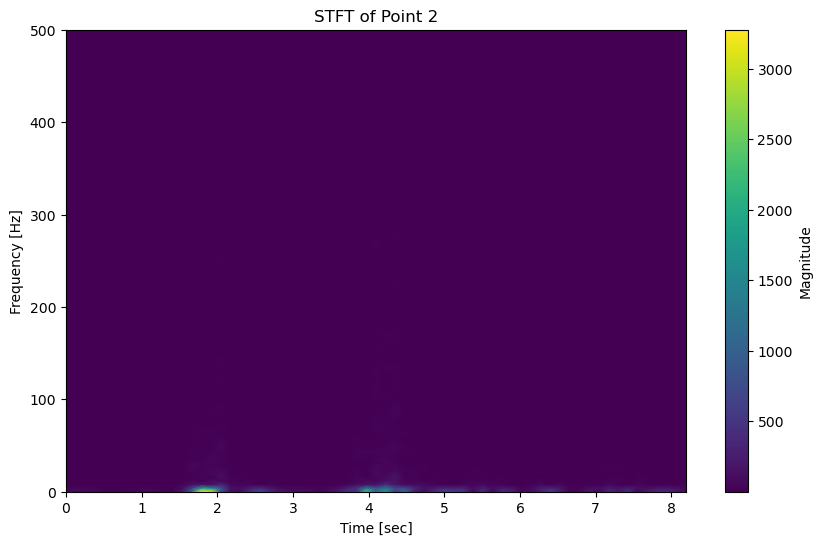

In [273]:
# Choisir un point de mesure pour lequel tracer la STFT
point_to_plot = data.columns[2]  # Remplacez cela par le point que vous voulez visualiser
plot_stft(frequencies, times, stft_results, point_to_plot)

In [275]:
def plot_stft_meilleur(f, t, stft_results, column, freq_lim=None, time_lim=None):
    """Tracer les résultats de la STFT pour un point de mesure spécifique avec zoom et échelle logarithmique."""
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(stft_results[column] + 1e-10), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'STFT of {column}')
    plt.colorbar(label='Magnitude (dB)')
    if freq_lim:
        plt.ylim(freq_lim)
    if time_lim:
        plt.xlim(time_lim)
    plt.show()

Le graphe montre comment les fréquences changent et évoluent au fil du temps.

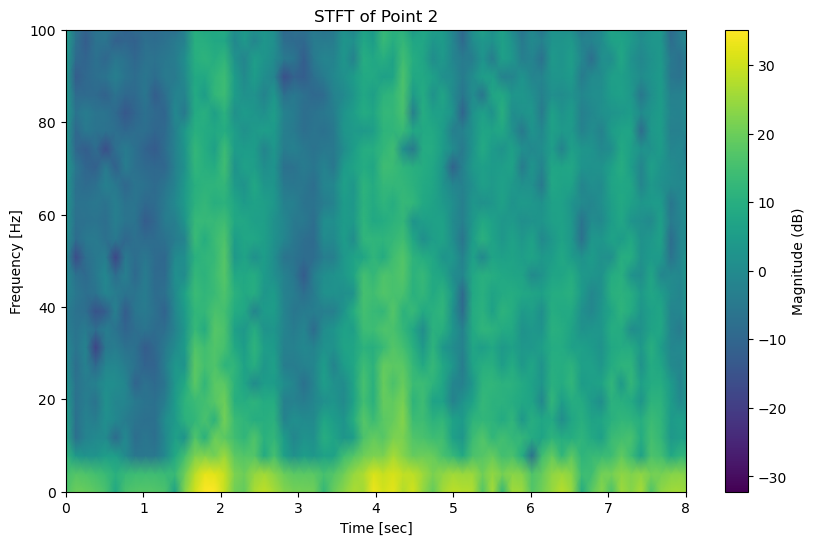

In [277]:
plot_stft_meilleur(frequencies, times, stft_results, point_to_plot, freq_lim=(0, 100), time_lim=(0, 8))


Les bandes colorées montrent l'intensité de différentes fréquences au cours du temps.
Par exemple, une bande jaune près de 20 Hz indique qu'il y a une forte composante de fréquence à 20 Hz à ce moment-là.
On observe des zones jaunes autour de 2 secondes et 4 secondes, indiquant des événements importants dans le signal à ces moments précis.

Les différentes couleurs dans un graphe STFT permettent de visualiser les variations de la magnitude du signal à différentes fréquences et moments. En interprétant correctement ces couleurs, on peut identifier des objets enfouis, analyser les couches de sol, et comprendre les caractéristiques des matériaux dans les données GPR. Les couleurs chaudes indiquent des magnitudes élevées et des réflexions fortes, tandis que les couleurs froides indiquent des magnitudes faibles et des réflexions faibles.